In [1]:
import json
import re
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import en_core_web_sm

In [2]:
nlp = en_core_web_sm.load()
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)
def removeEmoji(alldata):
    for restaurant in alldata:
        reviews=restaurant["review"]
        for review in reviews:
            content=review["content"]
            content=emoji_pattern.sub(r'', content)
            review["content"]=content

In [3]:
def analyze_sentiments(alldata):
    # Download the VADER lexicon
    nltk.download('vader_lexicon', quiet=True)

    # Initialize the VADER sentiment intensity analyzer
    sia = SentimentIntensityAnalyzer()

    # Perform sentiment analysis on each review and store the results with sentiment categories
    for restaurant in alldata:
        for review in restaurant["review"]:
            for content in review["sentenselist"]:
                sentiment = sia.polarity_scores(content["sentense"])
                compound_score = sentiment['compound']
                if compound_score >= 0.05:
                    content["sentiment"]='Positive'
                elif compound_score <= -0.05:
                    content["sentiment"]='Negative'
                else:
                    content["sentiment"]='Neutral'

In [4]:
def tokenize(doc, lemmatized=False, remove_stopword=False,
             remove_punct=True, pos_tag=False):
    spacy_doc = nlp(doc)
    tokens = []
    for token in spacy_doc:
        if remove_punct and token.is_punct:
            continue
        if remove_stopword and token.is_stop:
            continue
        if not token.text.strip():
            continue
        words = token.lemma_ if lemmatized else token.text
        if pos_tag:
            tokens.append((words.lower(), token.pos_))
        else:
            tokens.append(words.lower())
    return tokens

In [5]:
def splitSentence(alldata,mincharacter):
    for restaurant in alldata:
        reviews=restaurant["review"]
        for review in reviews:
            sentenselist=re.split(r'(?<=[.?!])', review["content"])
            review["sentenselist"]=[]
            for sentense in sentenselist:
                count=0
                for c in sentense:
                    if c.isalpha():
                        count+=1
                if count>mincharacter:
                    review["sentenselist"].append({"sentense":sentense})

In [7]:
#loading data from our data repository
with open("data/data.json","r") as file:
    alldata=json.load(file)

In [8]:
removeEmoji(alldata)
print(alldata[0]["review"][0])

{'time': '2 months ago', 'star': 4, 'content': "The Cheese Cake Factory at the mall is fantastic! I like that it's in the mall because you can burn off some calories while shopping  We went there mainly for the cheesecakes and tried the Original Cheesecake, Chocolate Tuxedo Cream …"}


In [9]:
splitSentence(alldata,8)
print(alldata[0]["review"][0]["sentenselist"])

[{'sentense': 'The Cheese Cake Factory at the mall is fantastic!'}, {'sentense': " I like that it's in the mall because you can burn off some calories while shopping  We went there mainly for the cheesecakes and tried the Original Cheesecake, Chocolate Tuxedo Cream …"}]


In [10]:
#add sentiment categories
analyze_sentiments(alldata)
print(alldata[0]["review"][0]["sentenselist"])

[{'sentense': 'The Cheese Cake Factory at the mall is fantastic!', 'sentiment': 'Positive'}, {'sentense': " I like that it's in the mall because you can burn off some calories while shopping  We went there mainly for the cheesecakes and tried the Original Cheesecake, Chocolate Tuxedo Cream …", 'sentiment': 'Positive'}]


In [11]:
def getAllSentense(alldata):
    sentenses=[]
    for restaurant in alldata:
        reviews=restaurant["review"]
        for review in reviews:
            for sentense in review["sentenselist"]:
                sentenses.append(sentense["sentense"])
    return sentenses

In [14]:
from joblib import load
def setTfidf(alldata):
    allsentense=getAllSentense(alldata)
    tfidf_maker=load("data/tfidf_vectorizer.joblib")
    tfidf = tfidf_maker.transform(allsentense).toarray()
    index=0
    for restaurant in alldata:
        reviews=restaurant["review"]
        for review in reviews:
            for sentense in review["sentenselist"]:
                sentense["tfidf"]=tfidf[index]
                index+=1


In [15]:
setTfidf(alldata)
print(alldata[0]["review"][0]["sentenselist"])


[{'sentense': 'The Cheese Cake Factory at the mall is fantastic!', 'sentiment': 'Positive', 'tfidf': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.44757853, 0.        , 0.        , 0.        , 0.44239129,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.34306478, 0.        , 0.51648581,
       0.        , 0.       

In [19]:
import tensorflow as tf
def setTopic(alldata):
    model = tf.keras.models.load_model('data/my_CNN_TOPIC.h5')
    scaler=load("data/my_scaler.joblib")
    lb=load("data/my_lb.joblib")
    print(lb.classes_)
    for restaurant in alldata:
        reviews=restaurant["review"]
        for review in reviews:
            for sentense in review["sentenselist"]:
                tfidf=sentense["tfidf"].reshape(1, -1)
                tfidf=scaler.transform(tfidf.reshape(1, -1))
                y_pred=model.predict(tfidf)
                predicted_class_index = np.argmax(y_pred, axis=1)
                
                predicted_class = lb.classes_[predicted_class_index[0]]
                sentense["Topics"]=predicted_class
                print(predicted_class)



In [20]:
setTopic(alldata)
print(alldata[0]["review"][0]["sentenselist"])



['atmosphere' 'food' 'hygiene' 'location' 'none' 'service']
1/1 [==============================] - 0s 92ms/step
food
1/1 [==============================] - 0s 17ms/step
food
1/1 [==============================] - 0s 15ms/step
food
1/1 [==============================] - 0s 16ms/step
none
1/1 [==============================] - 0s 15ms/step
service
1/1 [==============================] - 0s 16ms/step
service
1/1 [==============================] - 0s 17ms/step
food
1/1 [==============================] - 0s 16ms/step
food
1/1 [==============================] - 0s 15ms/step
service
1/1 [==============================] - 0s 15ms/step
food
1/1 [==============================] - 0s 15ms/step
service
1/1 [==============================] - 0s 15ms/step
service
1/1 [==============================] - 0s 14ms/step
service
1/1 [==============================] - 0s 15ms/step
food
1/1 [==============================] - 0s 14ms/step
service
1/1 [==============================] - 0s 14ms/step
food
1/1 [

In [48]:
print(alldata[0]["review"][0]["sentenselist"])
from joblib import dump
dump(alldata,"data/processed_data.joblib")


[{'sentense': 'The Cheese Cake Factory at the mall is fantastic!', 'sentiment': 'Positive', 'tfidf': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.44757853, 0.        , 0.        , 0.        , 0.44239129,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.34306478, 0.        , 0.51648581,
       0.        , 0.       

['processed_data.joblib']

In [54]:
alldata=load("data/processed_data.joblib")
print(alldata[0]["review"][0]["sentenselist"])

[{'sentense': 'The Cheese Cake Factory at the mall is fantastic!', 'sentiment': 'Positive', 'tfidf': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.44757853, 0.        , 0.        , 0.        , 0.44239129,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.34306478, 0.        , 0.51648581,
       0.        , 0.       

In [55]:
def tokenize(doc, lemmatized=False, remove_stopword=False,
             remove_punct=True, pos_tag=False):
    spacy_doc = nlp(doc)
    tokens = []
    for token in spacy_doc:
        if remove_punct and token.is_punct:
            continue
        if remove_stopword and token.is_stop:
            continue
        if not token.text.strip():
            continue
        words = token.lemma_ if lemmatized else token.text
        if pos_tag:
            tokens.append((words.lower(), token.pos_))
        else:
            tokens.append(words.lower())
    return tokens

def catchNOUN(alldata):
    for restaurant in alldata:
        reviews=restaurant["review"]
        for review in reviews:
            for sentense in review["sentenselist"]:
                tokens=tokenize(sentense["sentense"],True,True,True,True)
                nouns=[]
                for token in tokens:
                    text,tag=token
                    if tag=="NOUN" or tag=="PROPN":
                        nouns.append(text)
                sentense["Keywords"]=set(nouns)

In [56]:
catchNOUN(alldata)
print(alldata[0]["review"][0]["sentenselist"])

[{'sentense': 'The Cheese Cake Factory at the mall is fantastic!', 'sentiment': 'Positive', 'tfidf': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.44757853, 0.        , 0.        , 0.        , 0.44239129,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.34306478, 0.        , 0.51648581,
       0.        , 0.       

In [57]:
dump(alldata,"data/processed_data.joblib")

['processed_data.joblib']

In [2]:
#Save your time, run from here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
from joblib import load
alldata=load("data/processed_data.joblib")

In [3]:
def addSettoDict(myset,mydict):
    for item in myset:
        mydict[item]=mydict.setdefault(item,0)+1

def calculateOverAllData(alldata):
    labels=['atmosphere', 'food', 'hygiene', 'location', 'service']
    for restaurant in alldata:
        restaurant["overall"]={}
        for label in labels:
            restaurant["overall"][label]={"Positive":[0,{}],"Negative":[0,{}]}
        reviews=restaurant["review"]
        for review in reviews:
            for sentense in review["sentenselist"]:
                if sentense["Topics"]!="none":
                    if sentense["sentiment"]=="Positive":
                        restaurant["overall"][sentense["Topics"]]["Positive"][0]+=1
                        addSettoDict(sentense["Keywords"],restaurant["overall"][sentense["Topics"]]["Positive"][1])
                    else:
                        restaurant["overall"][sentense["Topics"]]["Negative"][0]+=1
                        addSettoDict(sentense["Keywords"],restaurant["overall"][sentense["Topics"]]["Negative"][1])

In [4]:
calculateOverAllData(alldata)
print(alldata[0]["overall"])

{'atmosphere': {'Positive': [61, {'place': 25, 'bar': 5, 'service': 5, 'atmosphere': 18, 'interior': 1, 'cake': 1, 'ambiance': 4, 'seating': 1, 'option': 2, 'staff': 4, 'setting': 1, 'gathering': 2, 'group': 1, 'tranquil': 1, 'dining': 6, 'visit': 2, 'experience': 5, 'expectation': 2, 'dinner': 3, 'birthday': 2, 'lot': 1, 'light': 1, 'booth': 2, 'backdrop': 1, 'time': 4, 'family': 8, 'cheesecake': 1, 'factory': 1, 'thing': 3, 'sort': 1, 'neighborhood': 1, 'year': 1, 'feel': 1, 'food': 3, 'restaurant': 4, 'pm': 1, 'table': 2, 'friend': 2, 'lover': 1, 'quality': 1, 'visitor': 1, 'spaghetti': 1, 'wife': 1, 'tiramisu': 1, 'kid': 2, 'section': 1, 'writing': 1, 'mouse': 1, 'awesome': 1, 'standard': 1, 'chain': 1, 'an': 1, 'drink': 1, 'vegetarian': 1, 'vibe': 1, 'evening': 1, 'saturday': 1, 'point': 1, 'price': 1, 'offering': 1, 'talk': 1, 'burger': 1, 'husband': 2, 'lighting': 1, 'daughter': 1}], 'Negative': [20, {'place': 3, 'saturday': 1, 'atmosphere': 3, 'lunch': 1, 'night': 1, 'date': 1,

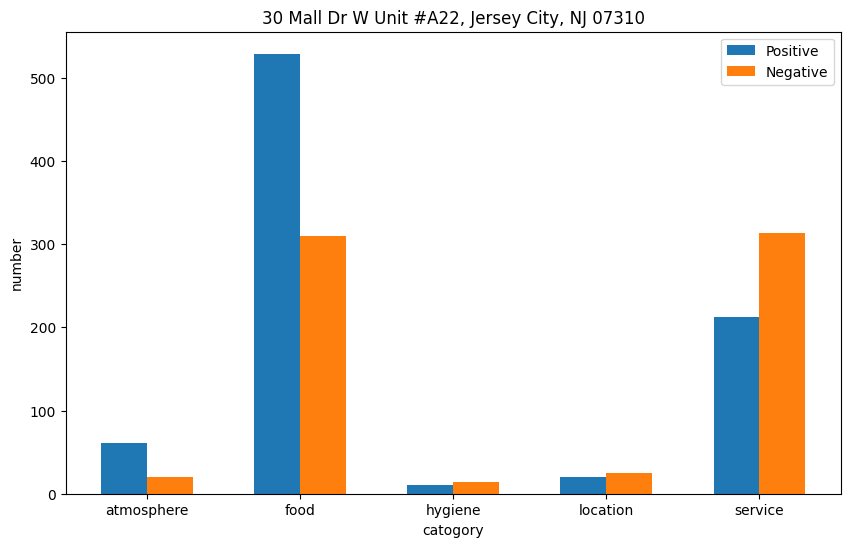

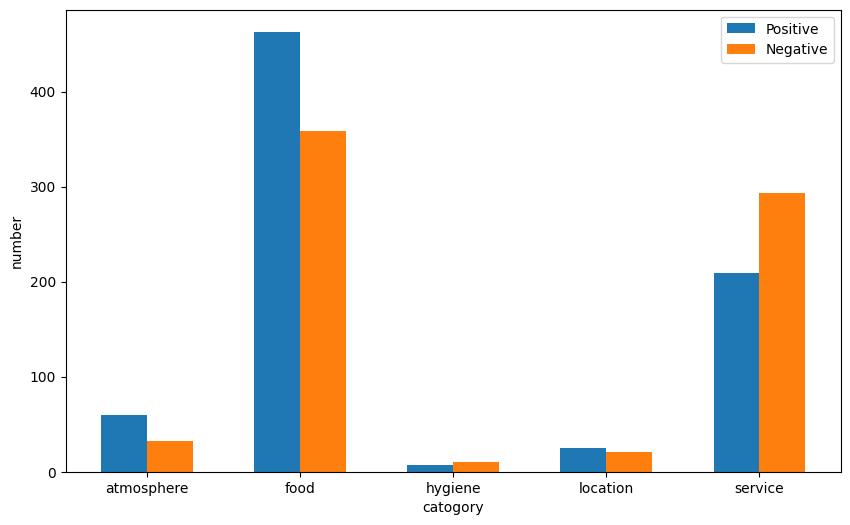

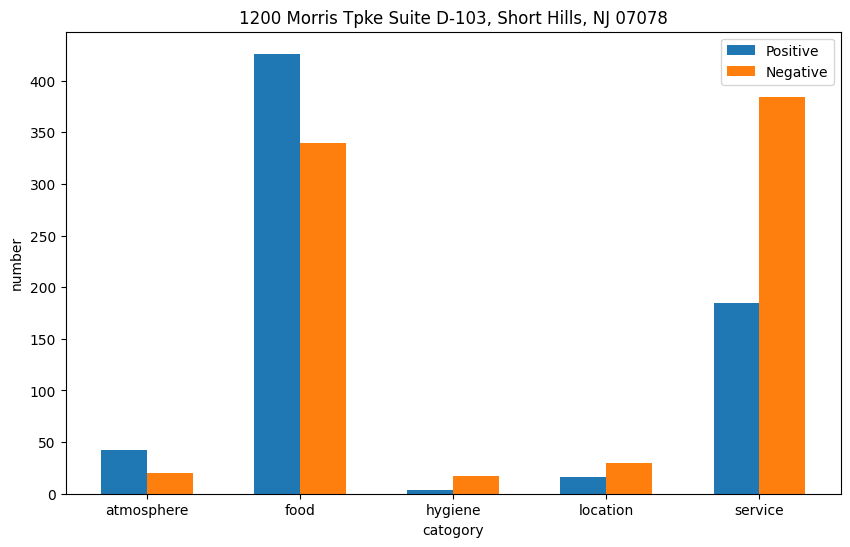

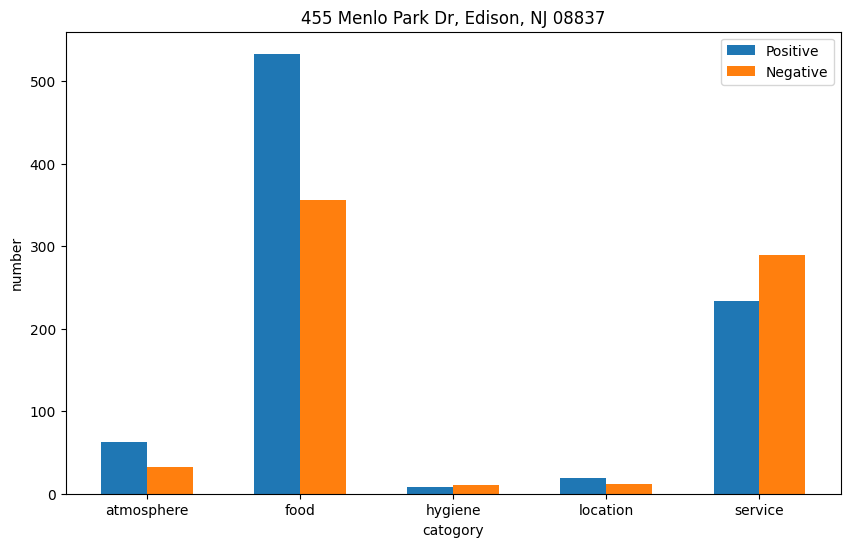

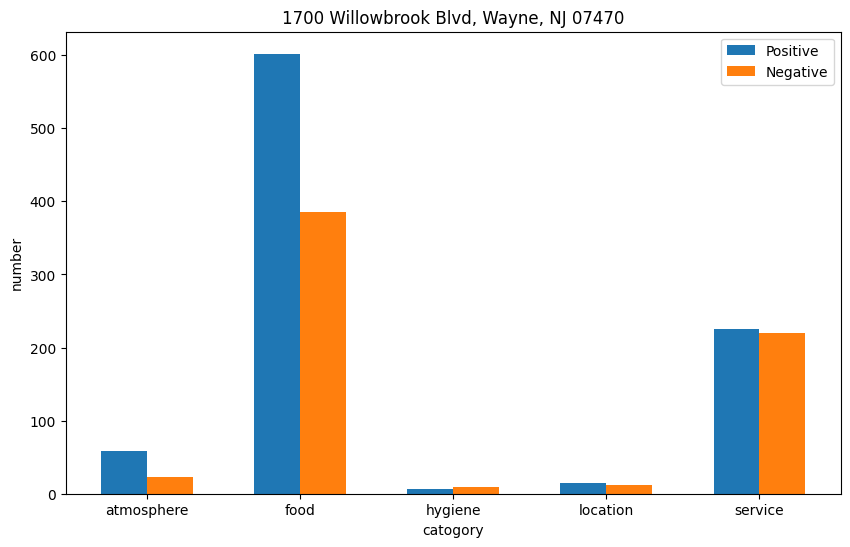

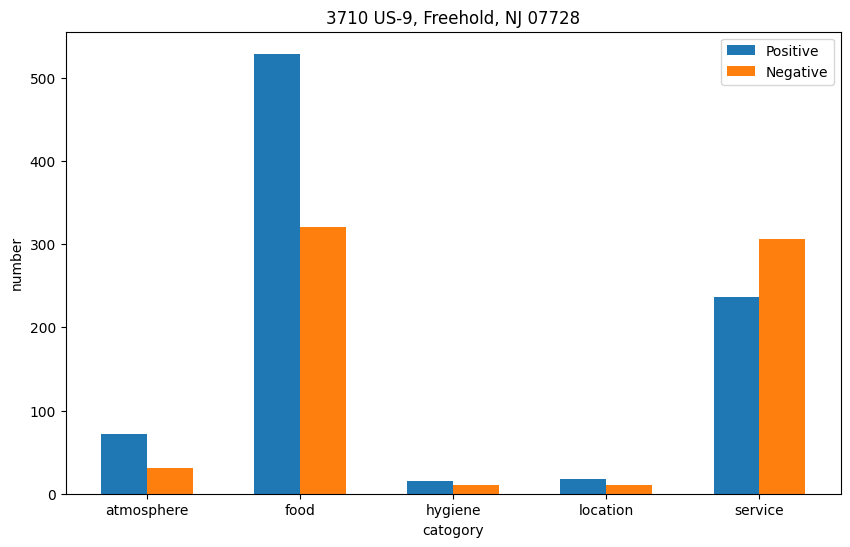

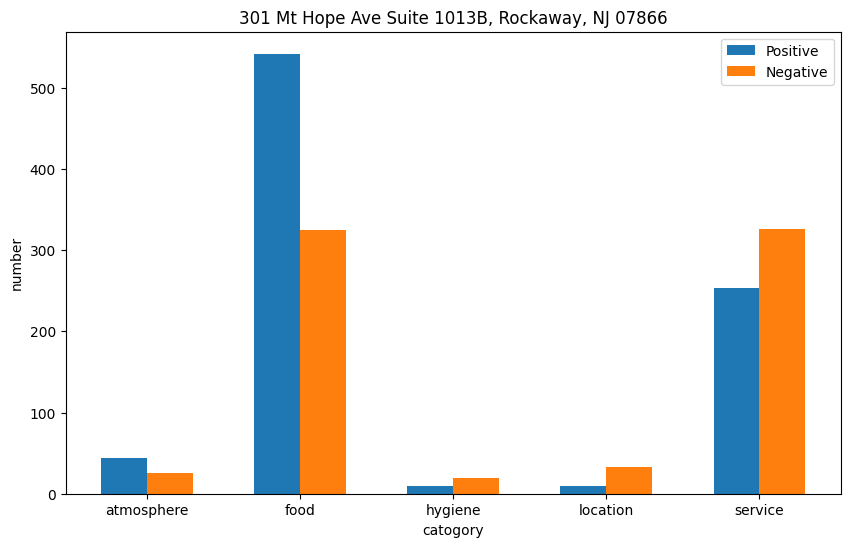

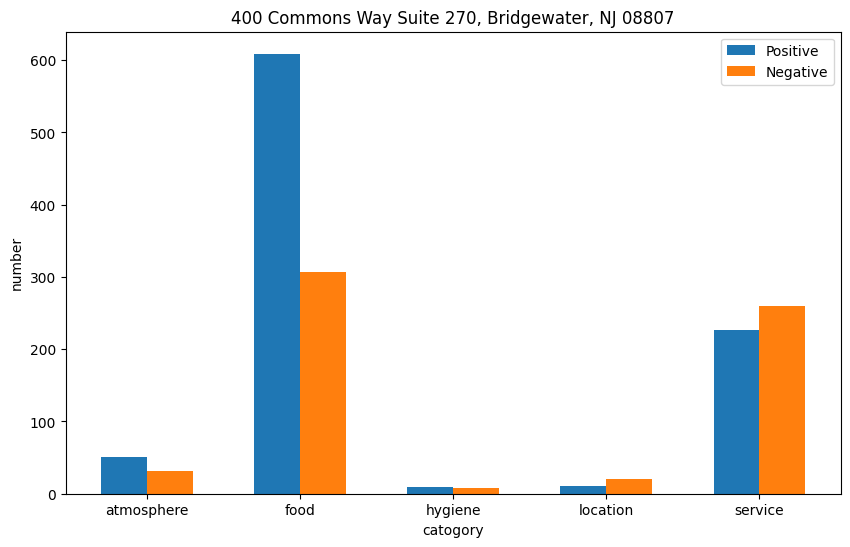

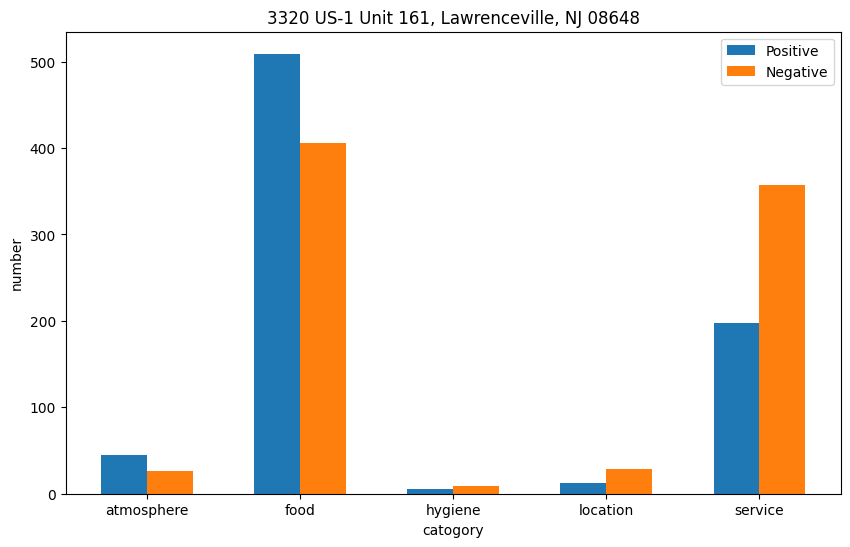

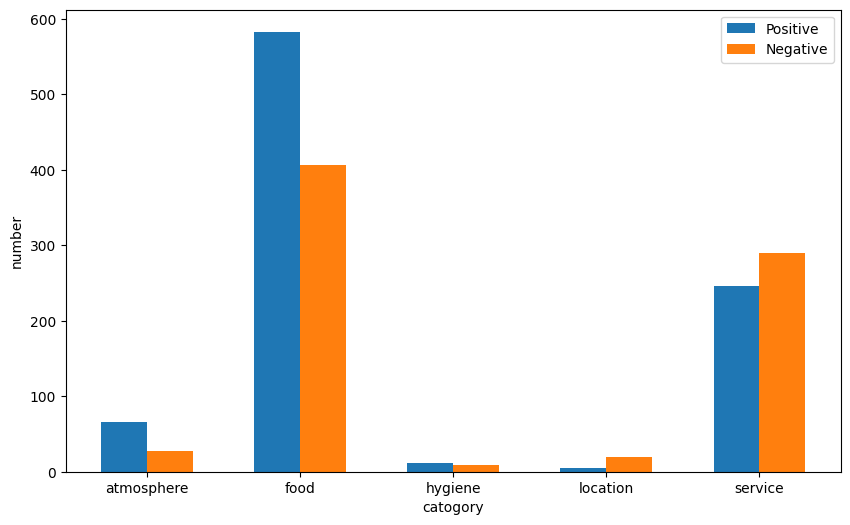

In [6]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['atmosphere', 'food', 'hygiene', 'location', 'service']
for restaurant in alldata:
    plt.figure(figsize=(10, 6))
    review_counts_p=[restaurant["overall"][label]["Positive"][0] for label in categories]
    review_counts_n=[restaurant["overall"][label]["Negative"][0] for label in categories]
    x = np.arange(len(categories)) * 2  
    plt.bar(x - 0.3, review_counts_p, width=0.6, label="Positive")
    plt.bar(x + 0.3, review_counts_n, width=0.6, label="Negative")
    
    plt.xlabel("catogory")
    plt.ylabel("number")
    plt.title(restaurant["address"])
    plt.xticks(x, categories)
    plt.legend()
    plt.show()


In [7]:
def convertTime(timestr):
    strlist=timestr.split()
    if strlist[1]=="years":
        return 2023-int(strlist[0])
    elif strlist[1]=="year":
        return 2022
    else:
        return 2023


def calculateTimeLine(alldata):
    labels=['atmosphere', 'food', 'hygiene', 'location', 'service']
    for restaurant in alldata:
        restaurant["timeline"]={}
        for i in range(2010,2024):
            restaurant["timeline"][i]={}
            for label in labels:
                restaurant["timeline"][i][label]={"Positive":0,"Negative":0}
        reviews=restaurant["review"]
        for review in reviews:
            for sentense in review["sentenselist"]:
                if sentense["Topics"]!="none":
                    if sentense["sentiment"]=="Positive":
                        restaurant["timeline"][convertTime(review["time"])][sentense["Topics"]]["Positive"]+=1
                    else:
                        restaurant["timeline"][convertTime(review["time"])][sentense["Topics"]]["Negative"]+=1

In [8]:
calculateTimeLine(alldata)
print(alldata[0]["timeline"])

{2010: {'atmosphere': {'Positive': 0, 'Negative': 0}, 'food': {'Positive': 0, 'Negative': 0}, 'hygiene': {'Positive': 0, 'Negative': 0}, 'location': {'Positive': 0, 'Negative': 0}, 'service': {'Positive': 0, 'Negative': 0}}, 2011: {'atmosphere': {'Positive': 0, 'Negative': 0}, 'food': {'Positive': 0, 'Negative': 0}, 'hygiene': {'Positive': 0, 'Negative': 0}, 'location': {'Positive': 0, 'Negative': 0}, 'service': {'Positive': 0, 'Negative': 0}}, 2012: {'atmosphere': {'Positive': 0, 'Negative': 0}, 'food': {'Positive': 0, 'Negative': 0}, 'hygiene': {'Positive': 0, 'Negative': 0}, 'location': {'Positive': 0, 'Negative': 0}, 'service': {'Positive': 0, 'Negative': 0}}, 2013: {'atmosphere': {'Positive': 0, 'Negative': 0}, 'food': {'Positive': 0, 'Negative': 0}, 'hygiene': {'Positive': 0, 'Negative': 0}, 'location': {'Positive': 0, 'Negative': 0}, 'service': {'Positive': 0, 'Negative': 0}}, 2014: {'atmosphere': {'Positive': 0, 'Negative': 0}, 'food': {'Positive': 0, 'Negative': 0}, 'hygiene':

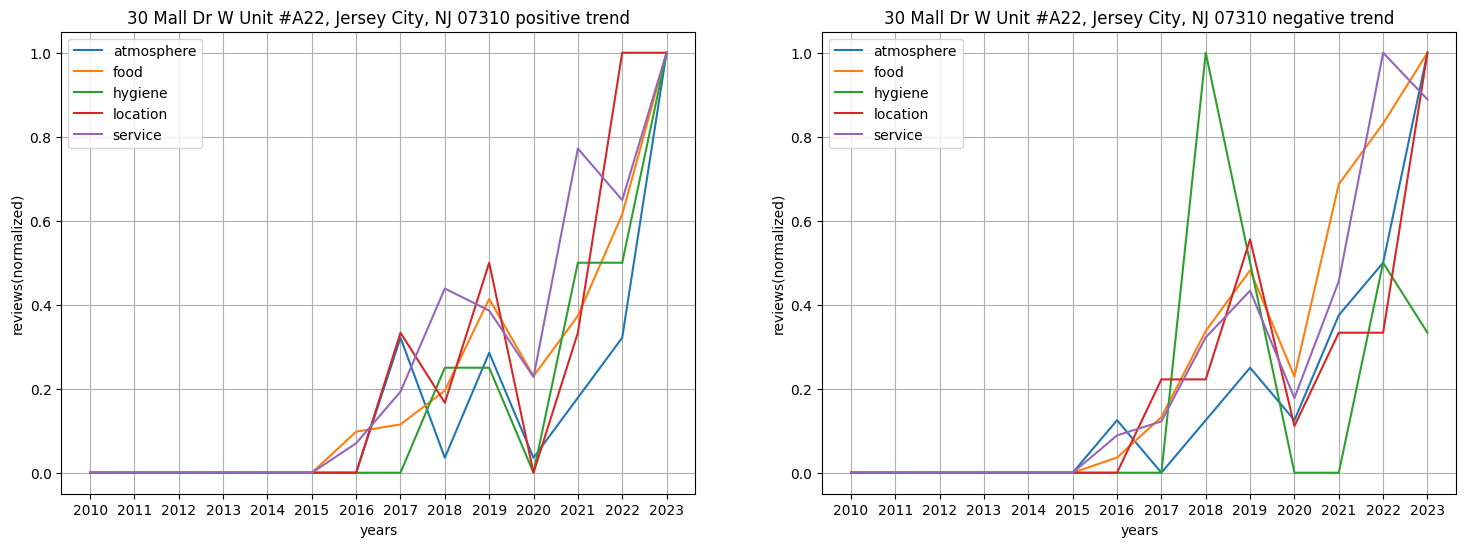

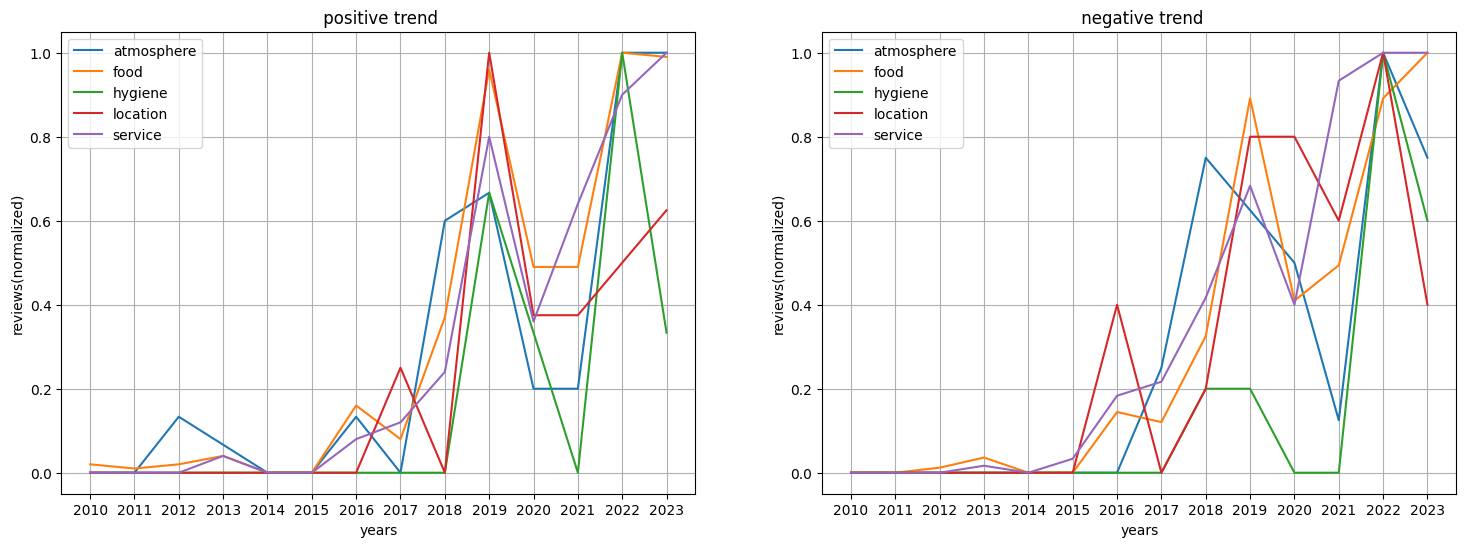

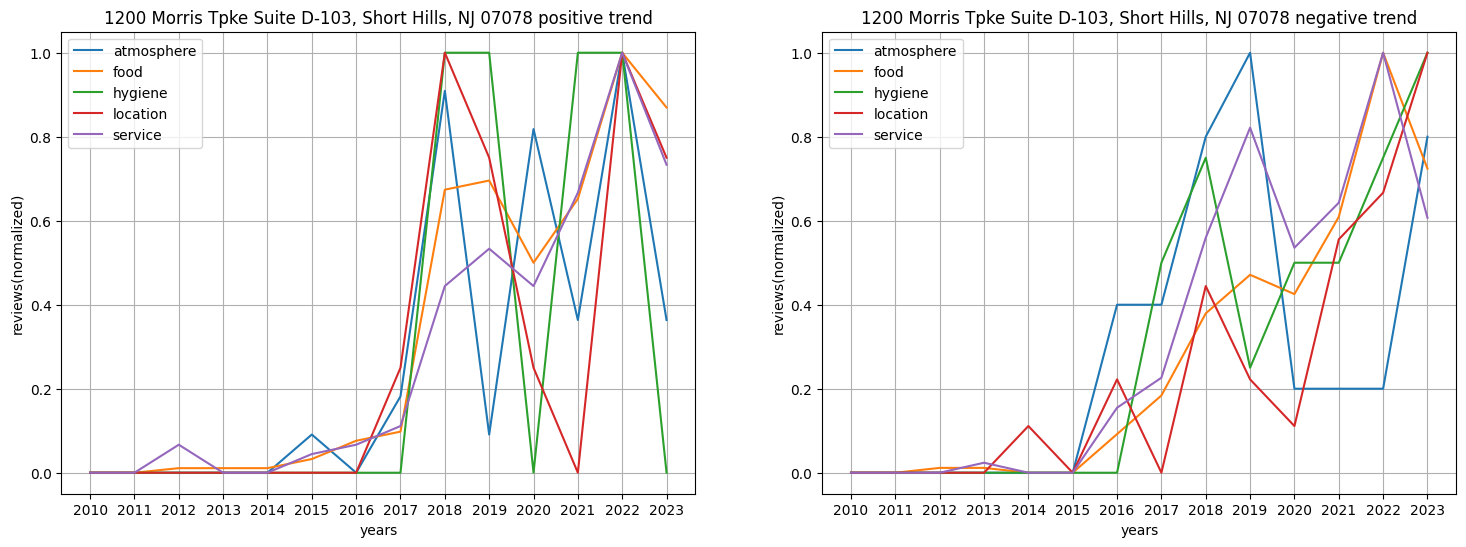

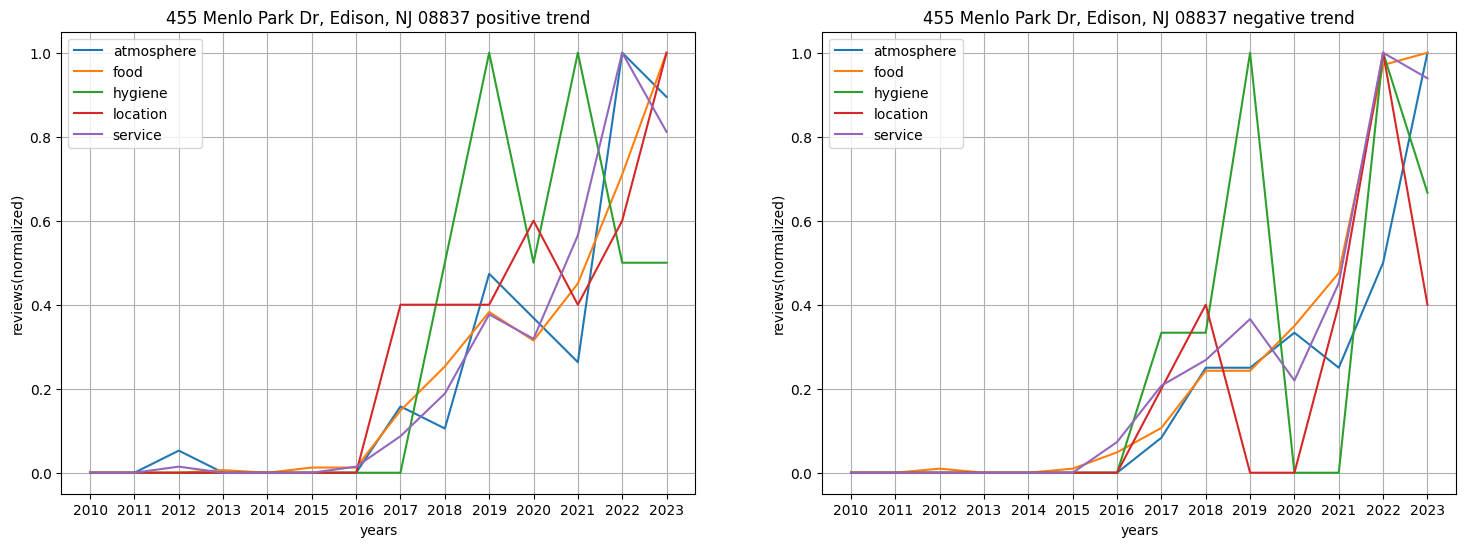

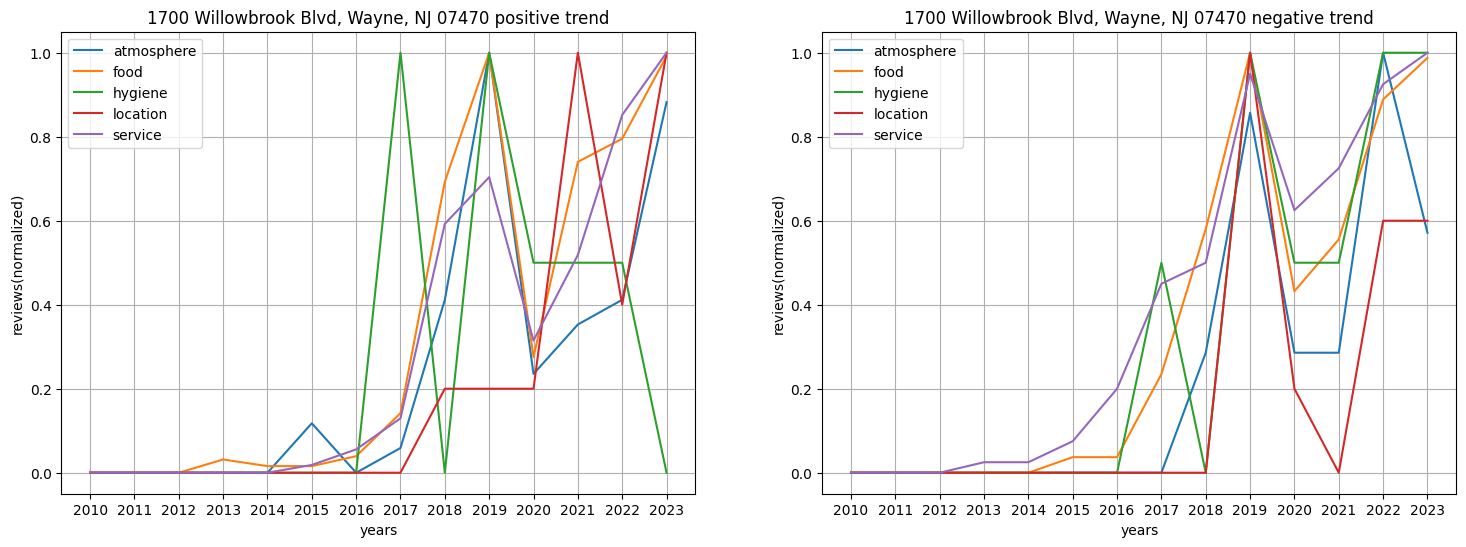

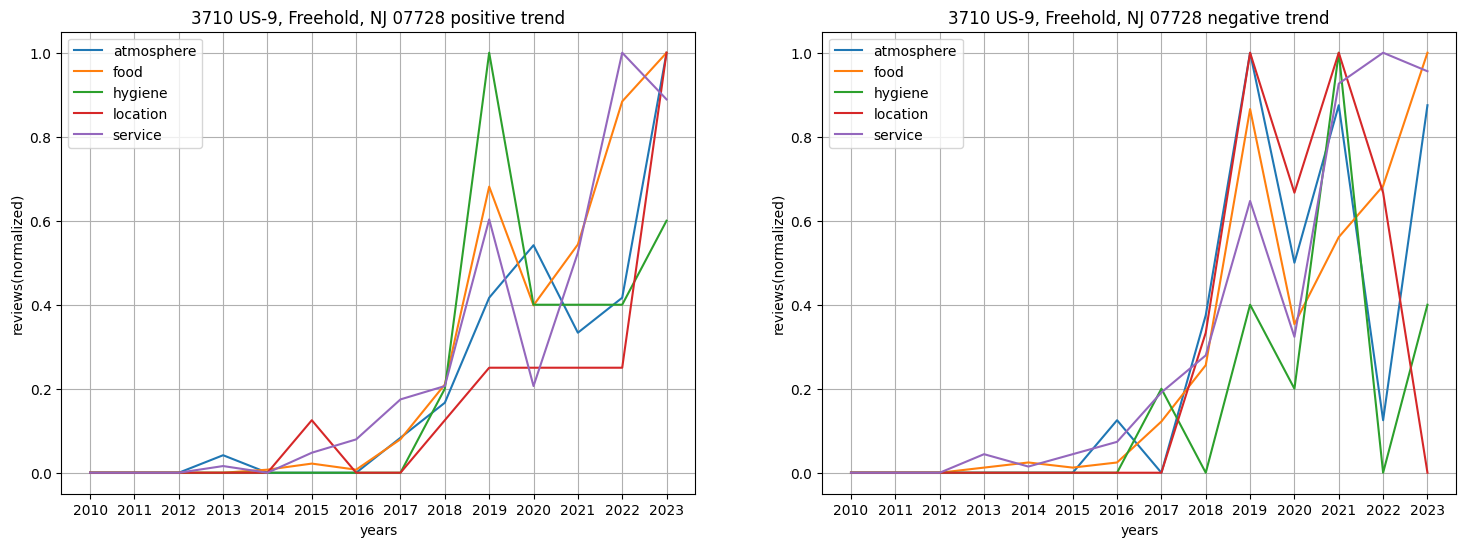

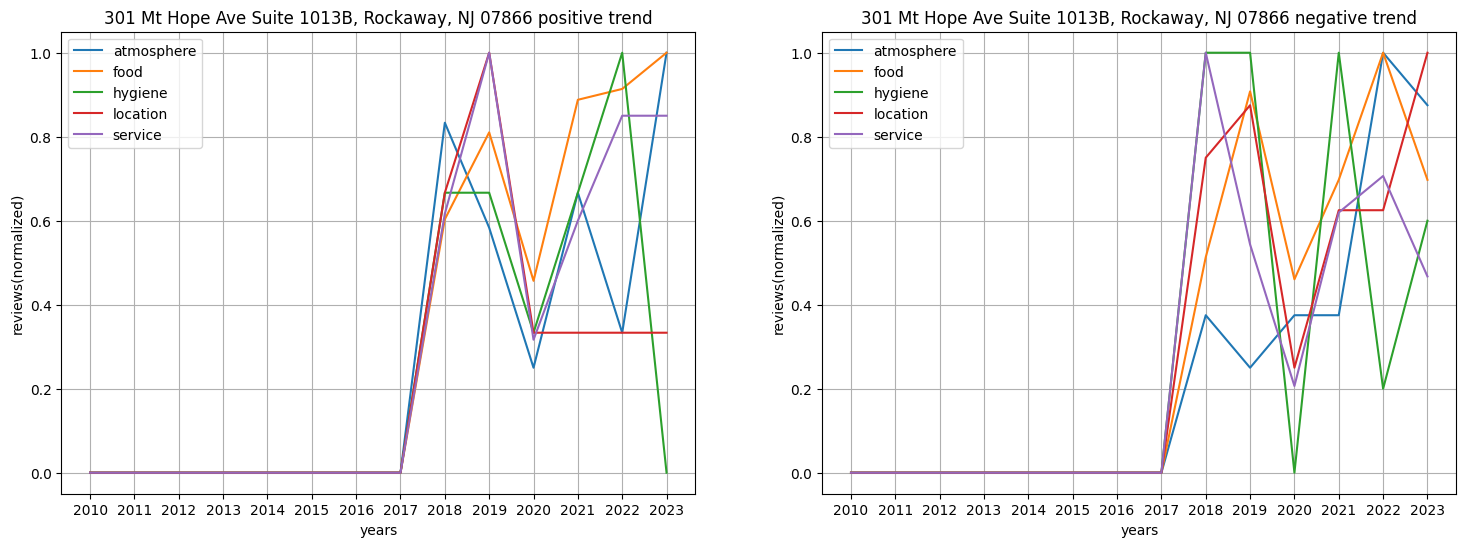

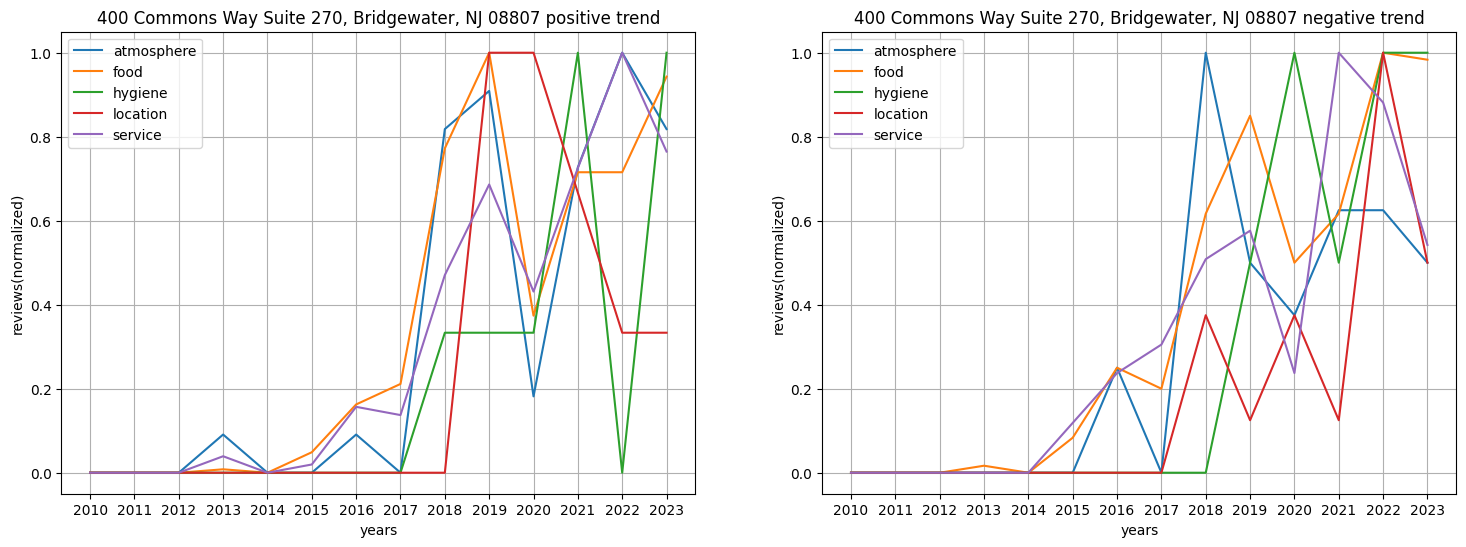

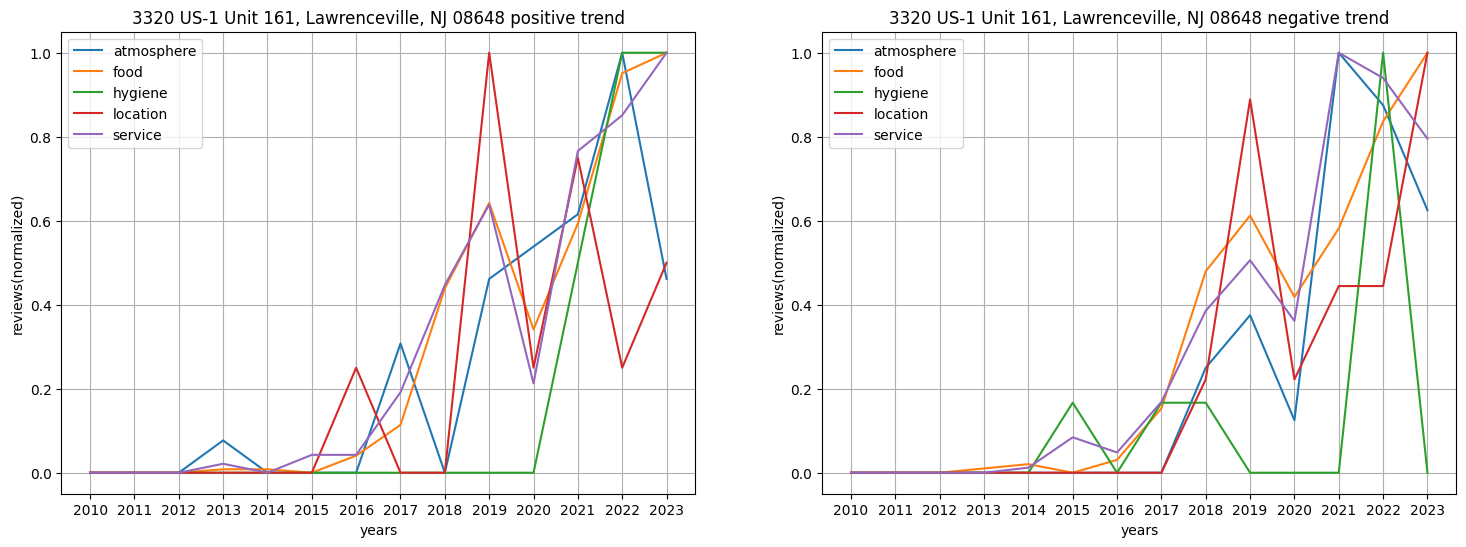

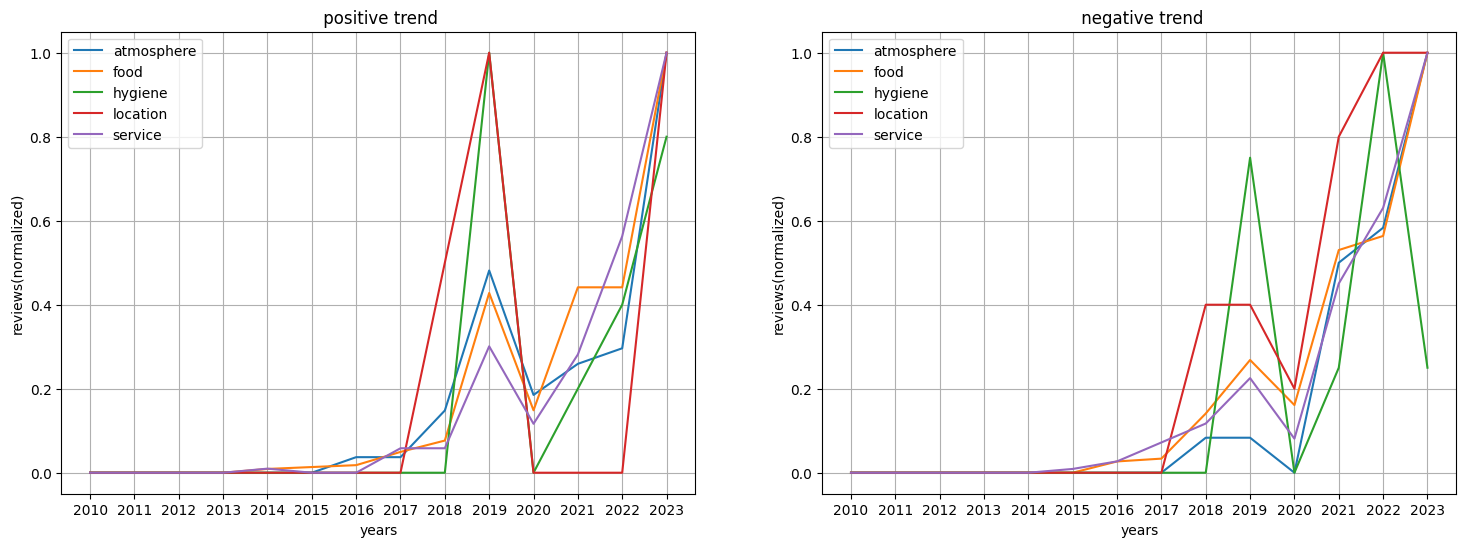

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

years = np.arange(2015, 2024)  
categories = ['atmosphere', 'food', 'hygiene', 'location', 'service']
for d in alldata:
    restaurant=d["address"]
    data=d["timeline"]

    years = list(data.keys())
    values = np.zeros((len(years), len(categories) * 2))

    for i, year in enumerate(years):
        for j, category in enumerate(categories):
            values[i, j] = data[year][category]['Positive']
            values[i, j + len(categories)] = data[year][category]['Negative']

    scaler = MinMaxScaler()
    for i in range(len(categories) * 2):
        values[:, i] = scaler.fit_transform(values[:, i].reshape(-1, 1)).flatten()

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)  
    for i, category in enumerate(categories):
        plt.plot(years, values[:, i], label=f"{category}")
    plt.title(f"{restaurant} positive trend")
    plt.xlabel("years")
    plt.ylabel("reviews(normalized)")
    plt.xticks(years)
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)  
    for i, category in enumerate(categories):
        plt.plot(years, values[:, i + len(categories)], label=f"{category}")
    plt.title(f"{restaurant} negative trend")
    plt.xlabel("years")
    plt.ylabel("reviews(normalized)")
    plt.xticks(years)
    plt.legend()
    plt.grid(True)

    plt.show()

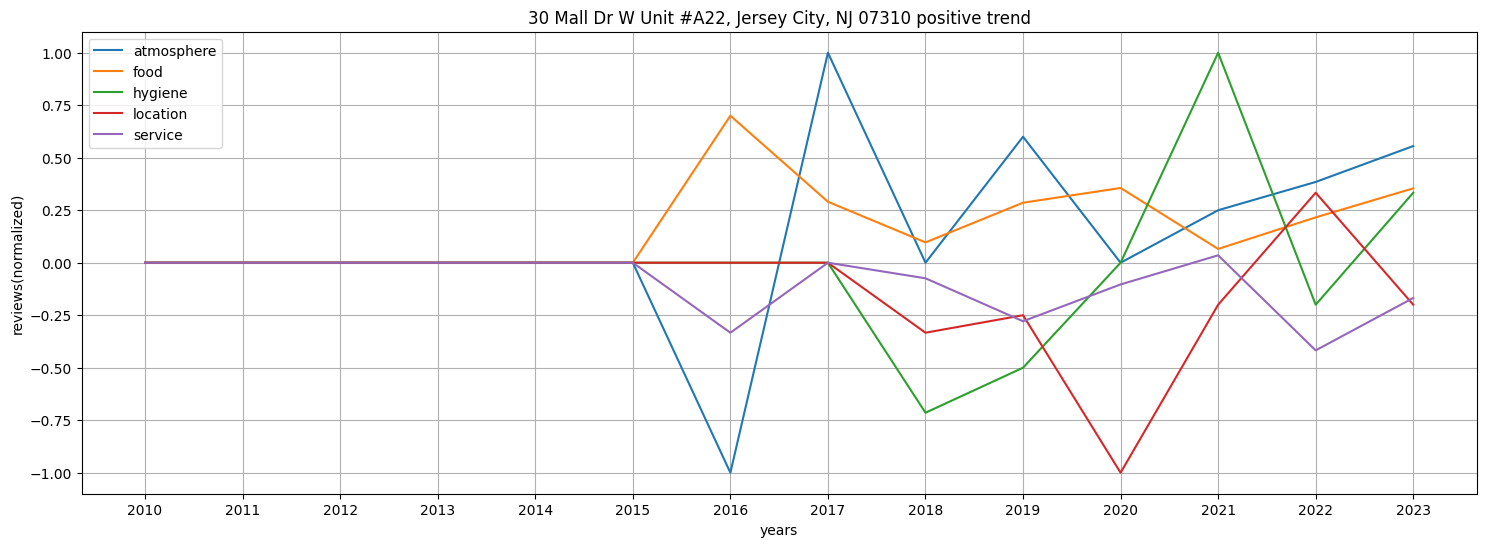

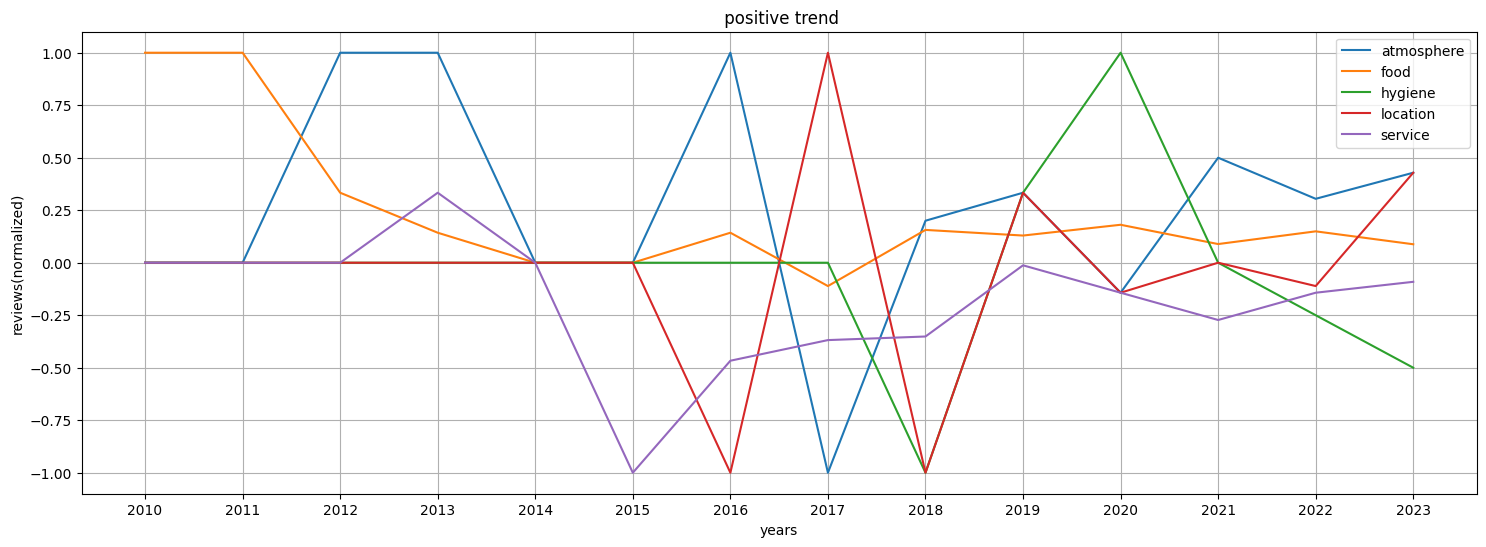

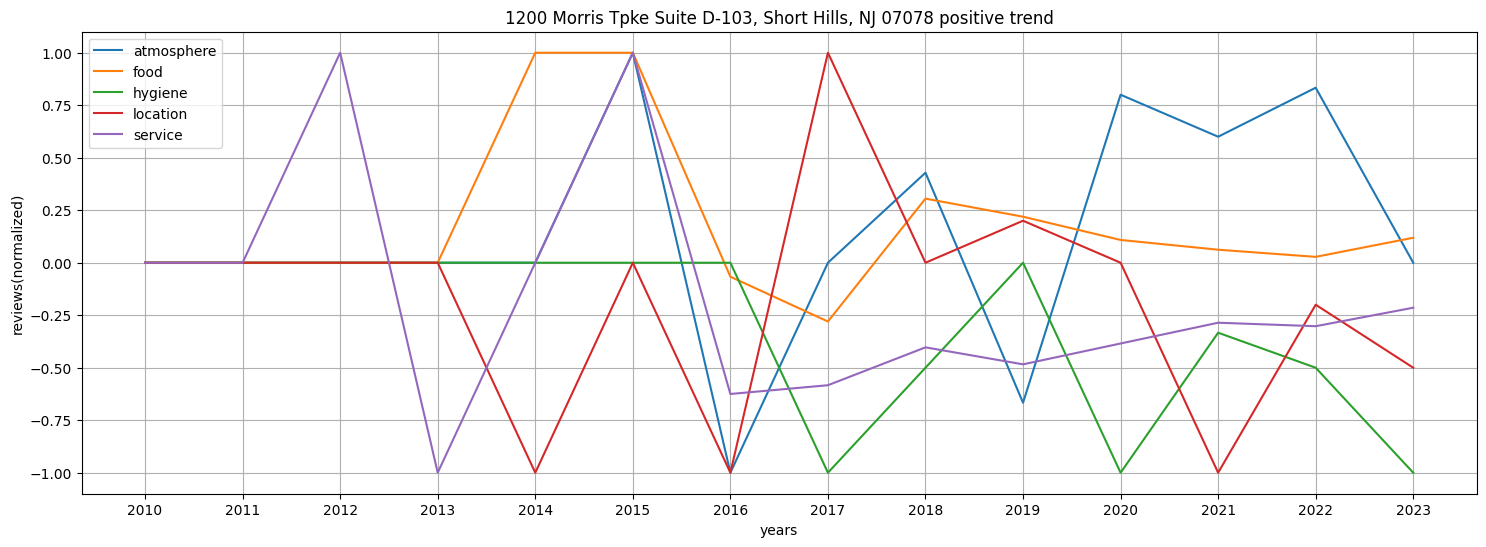

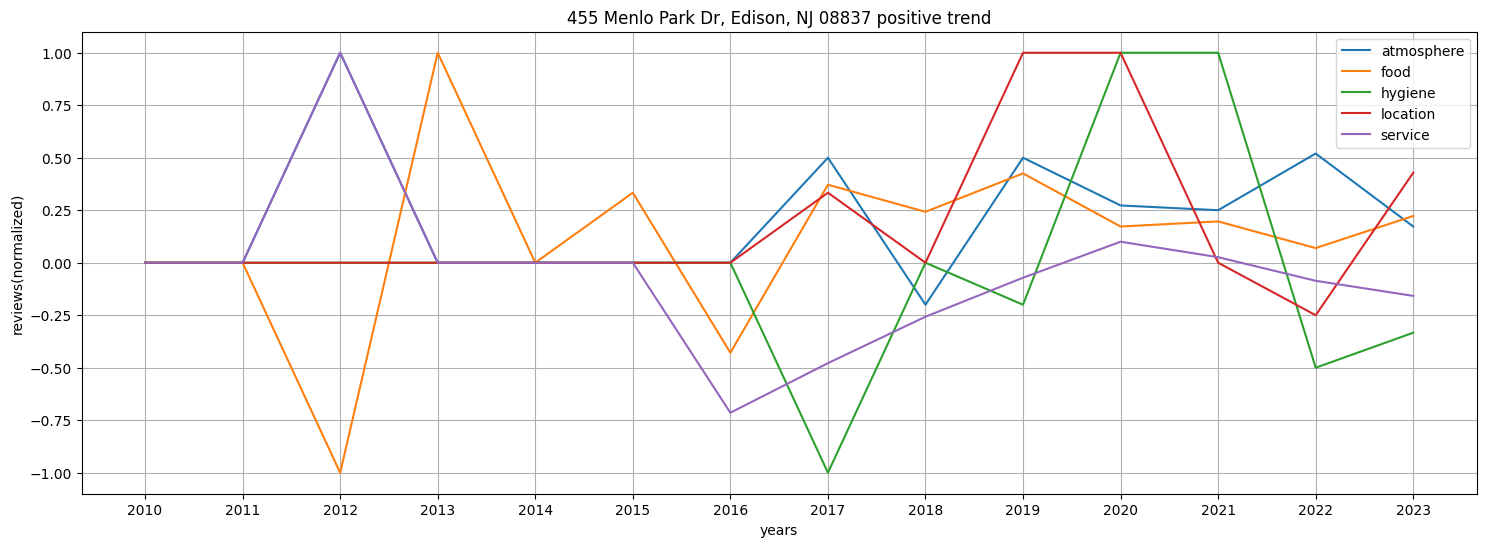

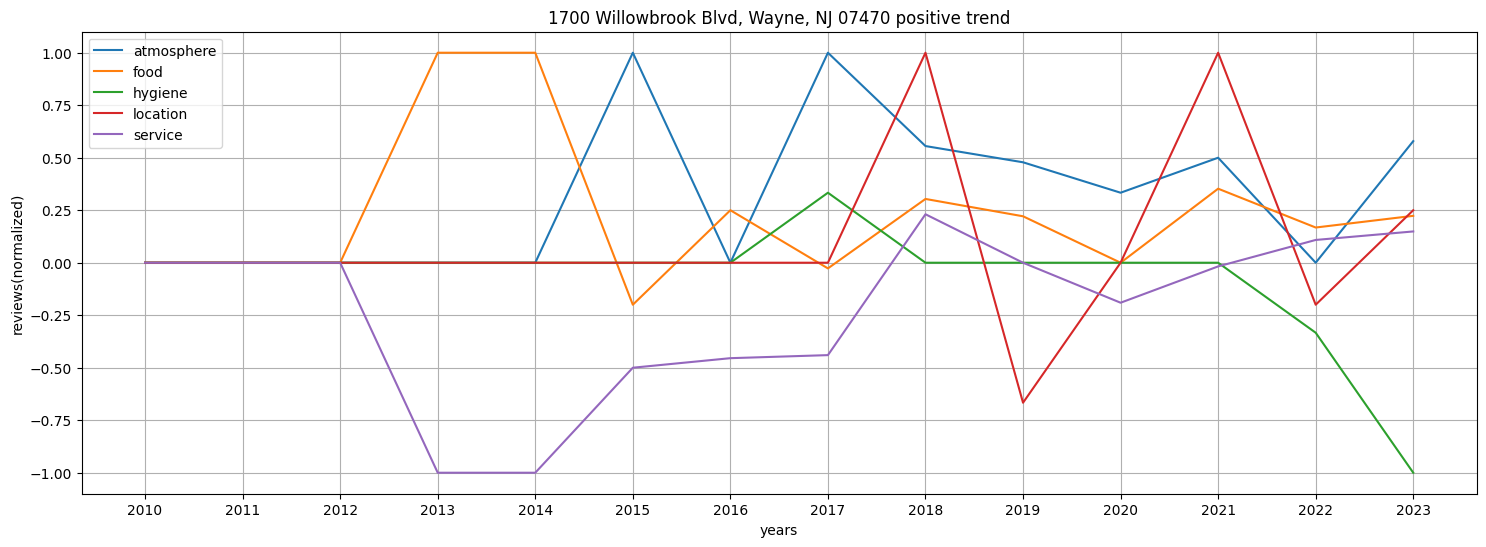

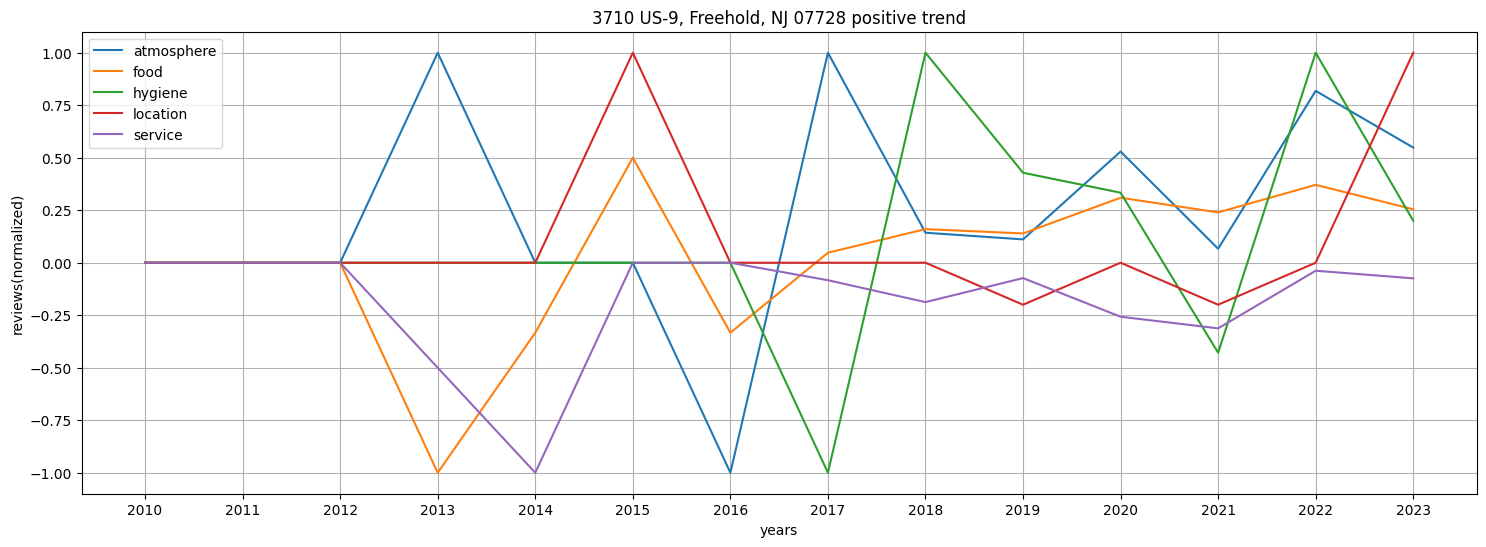

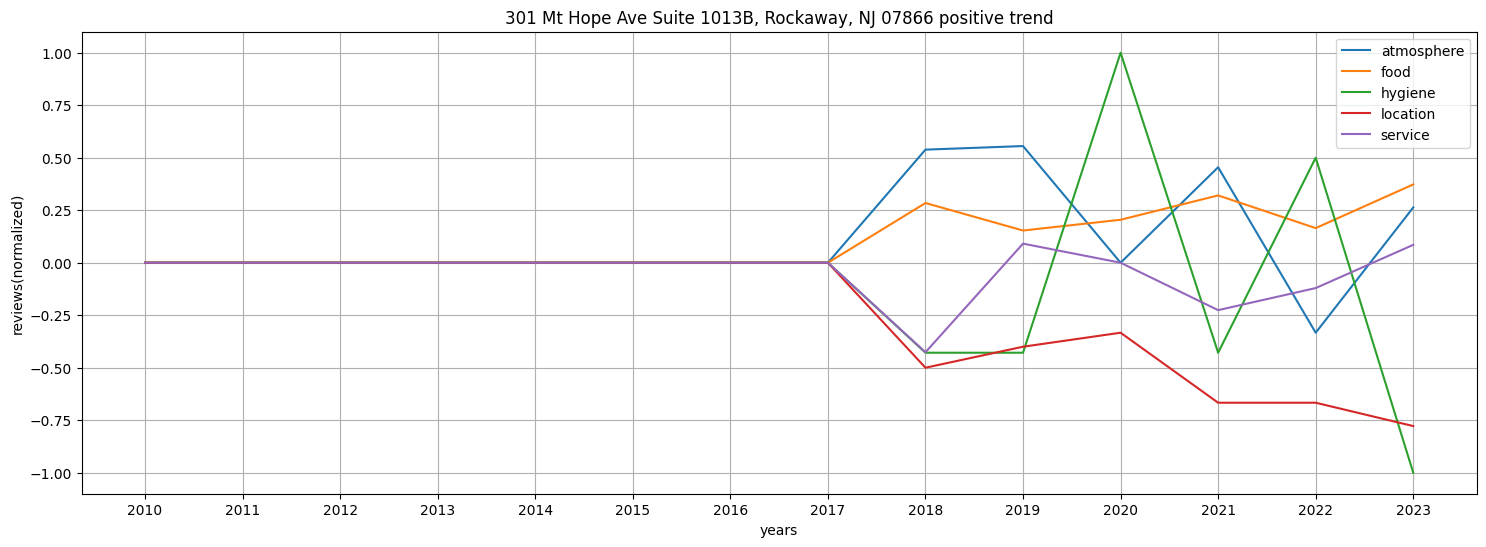

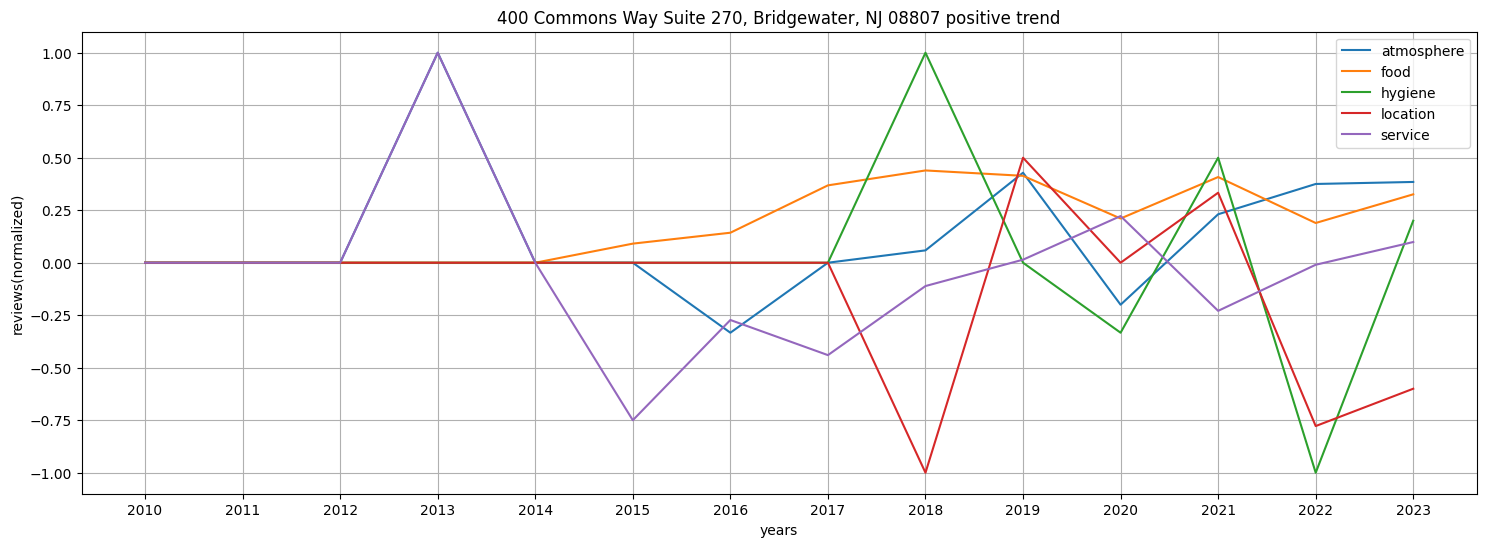

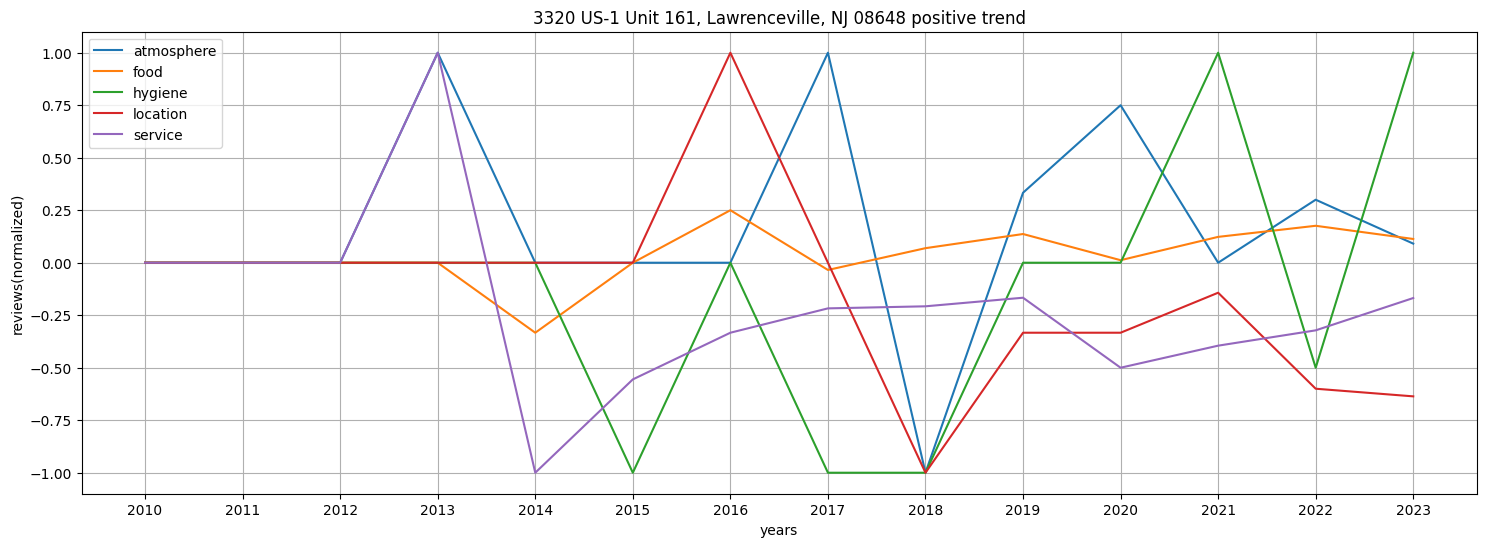

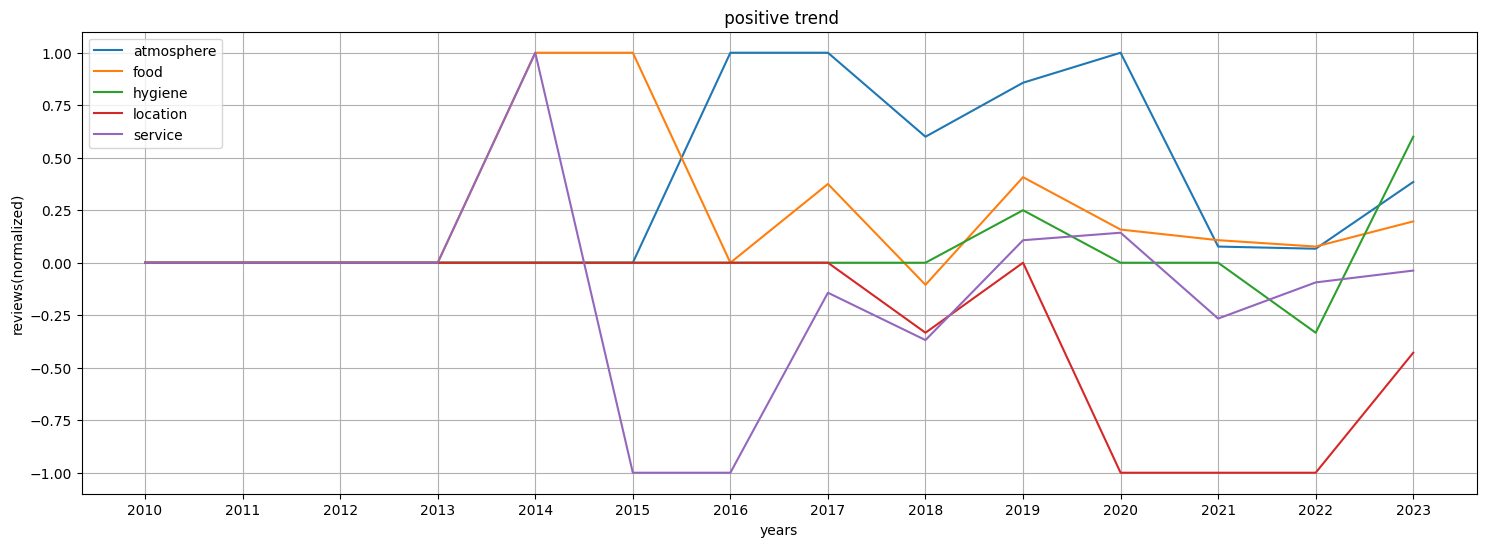

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

years = np.arange(2015, 2024)  
categories = ['atmosphere', 'food', 'hygiene', 'location', 'service']
for d in alldata:
    restaurant=d["address"]
    data=d["timeline"]

    years = list(data.keys())
    values = np.zeros((len(years), len(categories)))

    for i, year in enumerate(years):
        for j, category in enumerate(categories):
            sum=data[year][category]['Negative']+data[year][category]['Positive']
            values[i, j] = (data[year][category]['Positive']-data[year][category]['Negative'])/sum if sum!=0 else 0

    plt.figure(figsize=(18, 6))
 
    for i, category in enumerate(categories):
        plt.plot(years, values[:, i], label=f"{category}")
    plt.title(f"{restaurant} positive trend")
    plt.xlabel("years")
    plt.ylabel("reviews(normalized)")
    plt.xticks(years)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

years = np.arange(2015, 2024)  
categories = ['atmosphere', 'food', 'hygiene', 'location', 'service']
for d in alldata:
    restaurant=d["address"]
    data=d["timeline"]

    years = list(data.keys())
    values = np.zeros((len(years), len(categories) * 2))

    for i, year in enumerate(years):
        for j, category in enumerate(categories):
            values[i, j] = data[year][category]['Positive']
            values[i, j + len(categories)] = data[year][category]['Negative']

    scaler = MinMaxScaler()
    for i in range(len(categories) * 2):
        values[:, i] = scaler.fit_transform(values[:, i].reshape(-1, 1)).flatten()

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)  
    for i, category in enumerate(categories):
        plt.plot(years, values[:, i], label=f"{category}")
    plt.title(f"{restaurant} positive trend")
    plt.xlabel("years")
    plt.ylabel("reviews(normalized)")
    plt.xticks(years)
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)  
    for i, category in enumerate(categories):
        plt.plot(years, values[:, i + len(categories)], label=f"{category}")
    plt.title(f"{restaurant} negative trend")
    plt.xlabel("years")
    plt.ylabel("reviews(normalized)")
    plt.xticks(years)
    plt.legend()
    plt.grid(True)

    plt.show()

30 Mall Dr W Unit #A22, Jersey City, NJ 07310


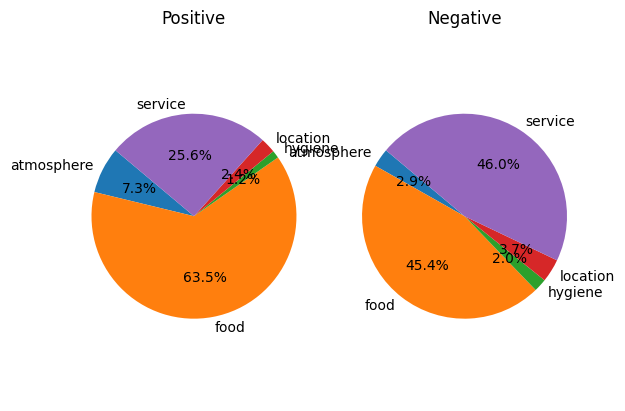

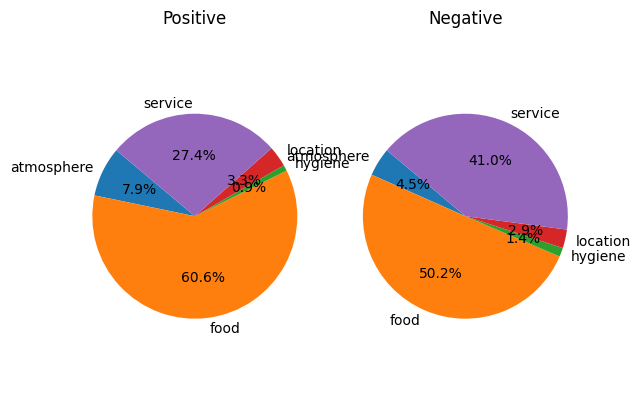

1200 Morris Tpke Suite D-103, Short Hills, NJ 07078


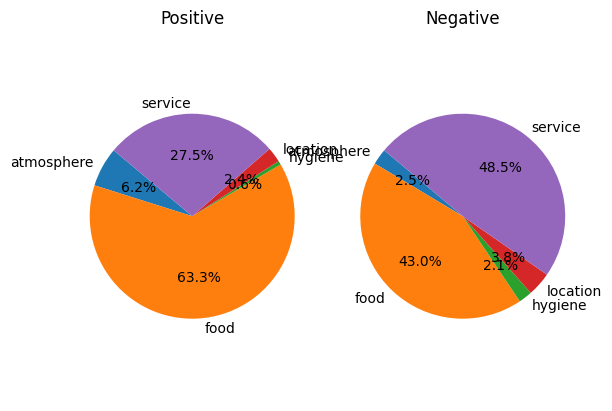

455 Menlo Park Dr, Edison, NJ 08837


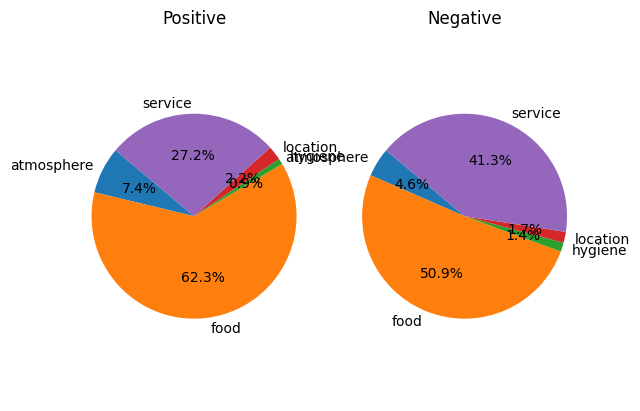

1700 Willowbrook Blvd, Wayne, NJ 07470


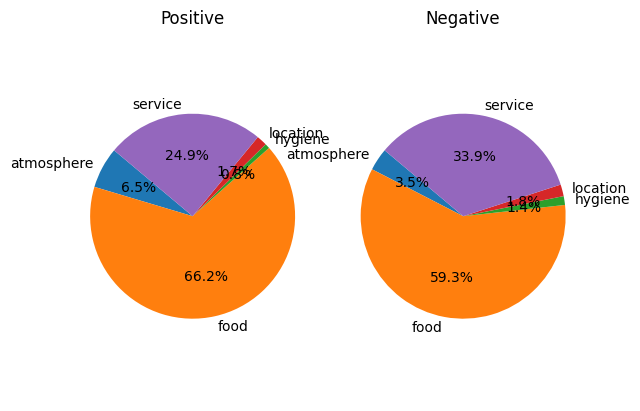

3710 US-9, Freehold, NJ 07728


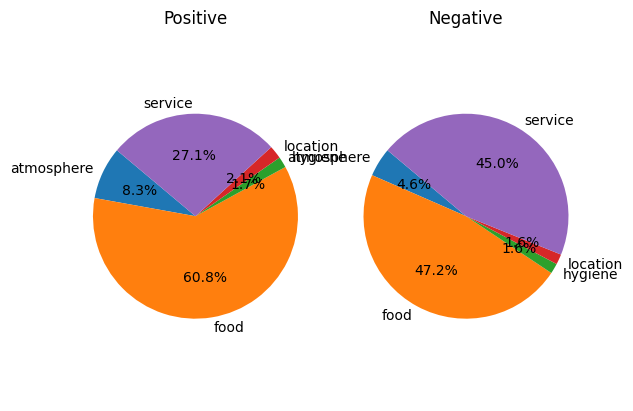

301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866


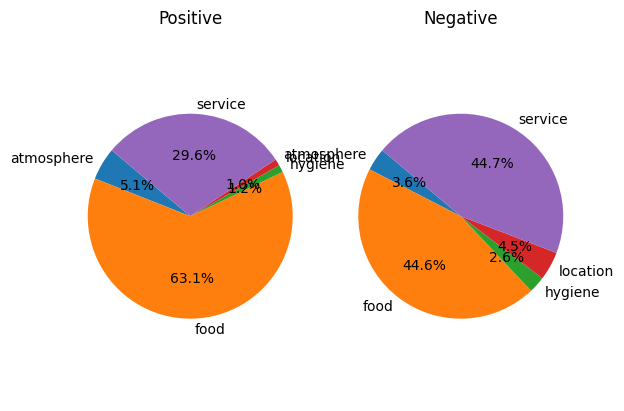

400 Commons Way Suite 270, Bridgewater, NJ 08807


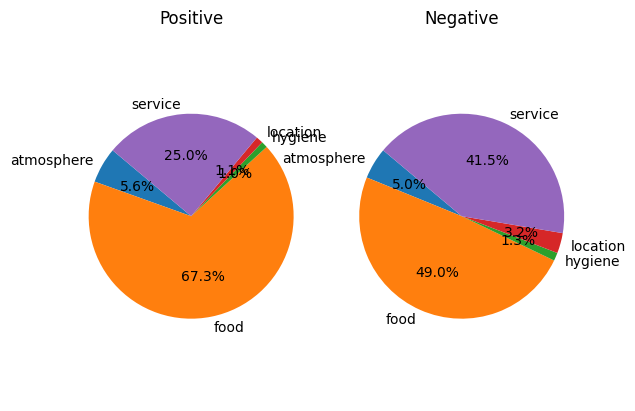

3320 US-1 Unit 161, Lawrenceville, NJ 08648


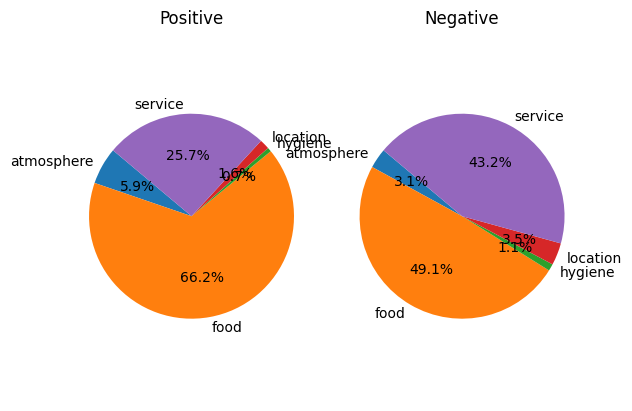

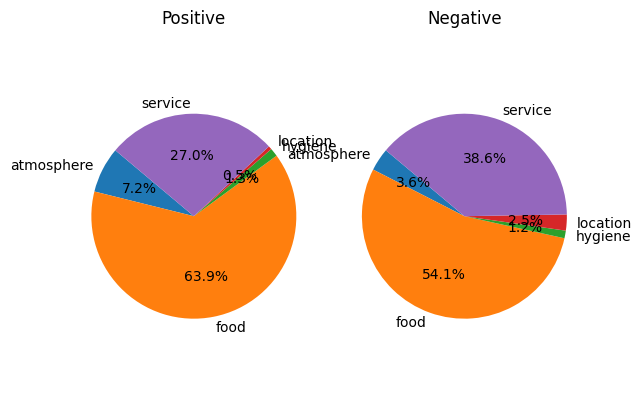

In [19]:
import matplotlib.pyplot as plt

categories = ['atmosphere', 'food', 'hygiene', 'location', 'service']
for d in alldata:
    print(d["address"])
    sizes = []
    for key in d["overall"]:
        sizes.append(d["overall"][key]["Positive"][0])
    plt.subplot(1, 2, 1) 
    plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=140)
    plt.title("Positive")
    plt.axis('equal')
    sizes = []
    for key in d["overall"]:
        sizes.append(d["overall"][key]["Negative"][0])
    plt.subplot(1, 2, 2) 
    plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=140)
    plt.title("Negative")
    plt.axis('equal')
    plt.show()


CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Positive at atmosphere
       Keyword  Value
23      family      8
12      dining      6
0          bar      5
1      service      5
14  experience      5
32  restaurant      4
4     ambiance      4


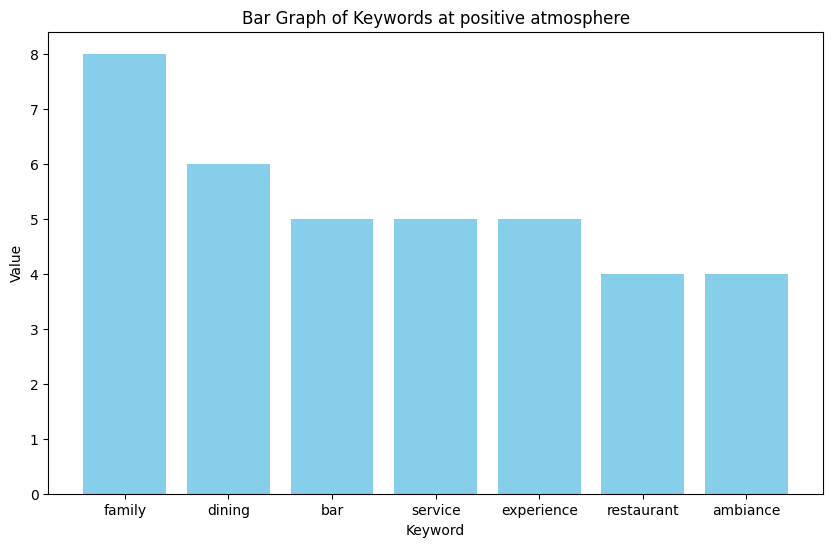

CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Negative at atmosphere
       Keyword  Value
11       table      3
12  restaurant      2
32         bar      2
7       dinner      2
9       family      2
0     saturday      1
23        lamp      1


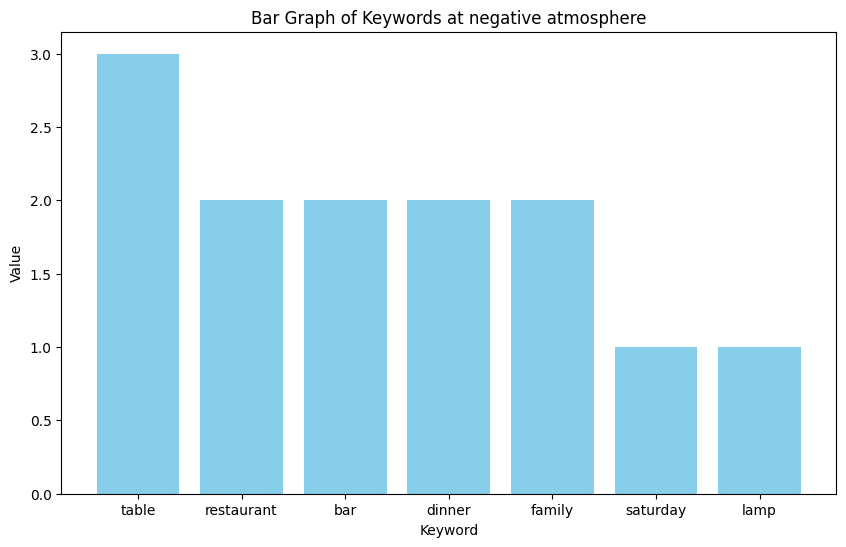

CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Positive at food
       Keyword  Value
8   cheesecake    100
29     service     48
2      factory     37
20        menu     29
32     chicken     28
61       drink     23
21       pasta     20


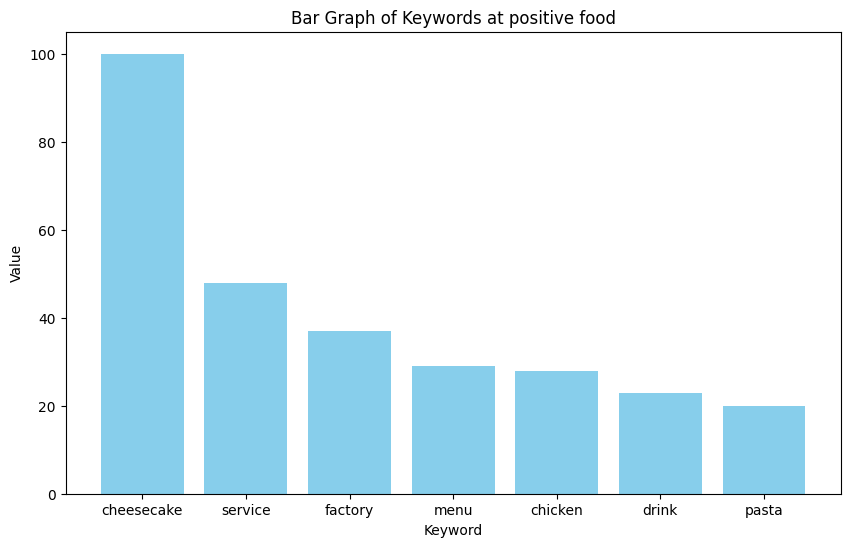

CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Negative at food
       Keyword  Value
3   cheesecake     64
4      factory     34
12     chicken     31
48      burger     20
33       pasta     19
32      cheese     15
19        menu     15


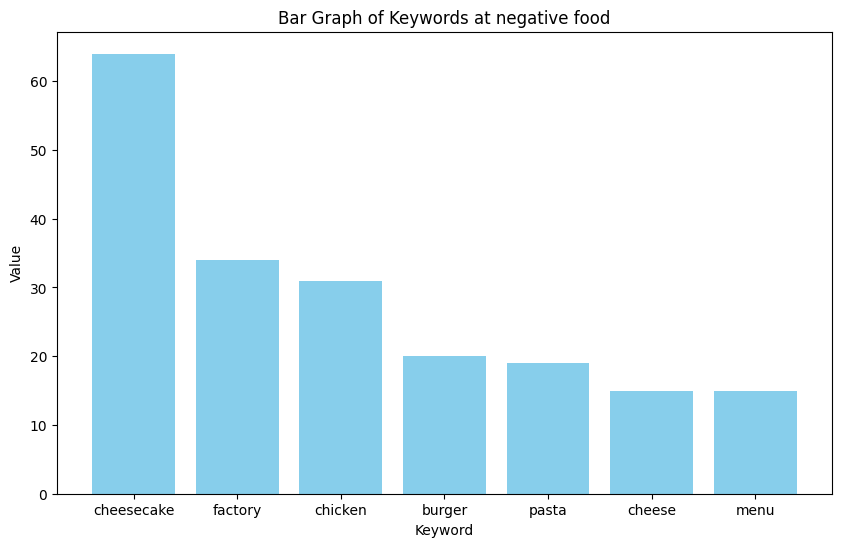

CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Positive at hygiene
     Keyword  Value
0     family      2
4      table      2
10     water      1
16    corner      1
15     linen      1
14   service      1
13  location      1


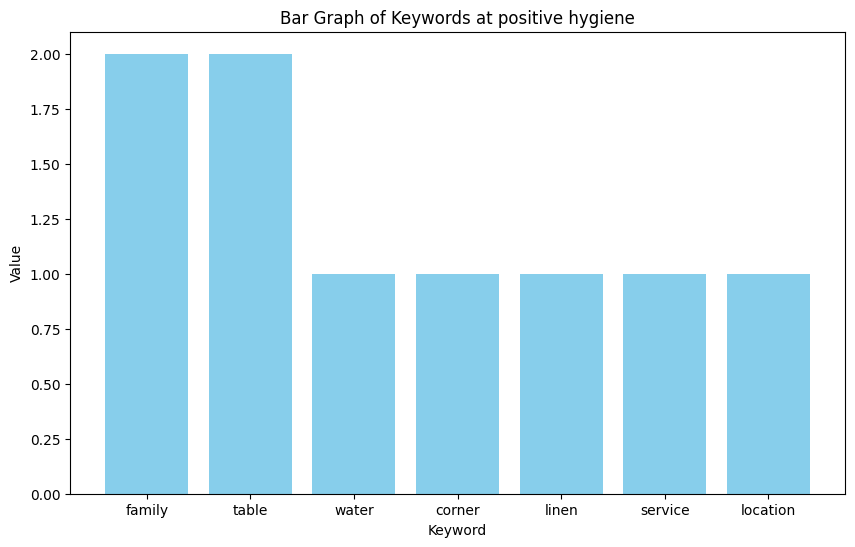

CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Negative at hygiene
       Keyword  Value
1        table      3
4      utensil      2
5         fork      2
8   silverware      2
0         edge      1
12        host      1
18     manager      1


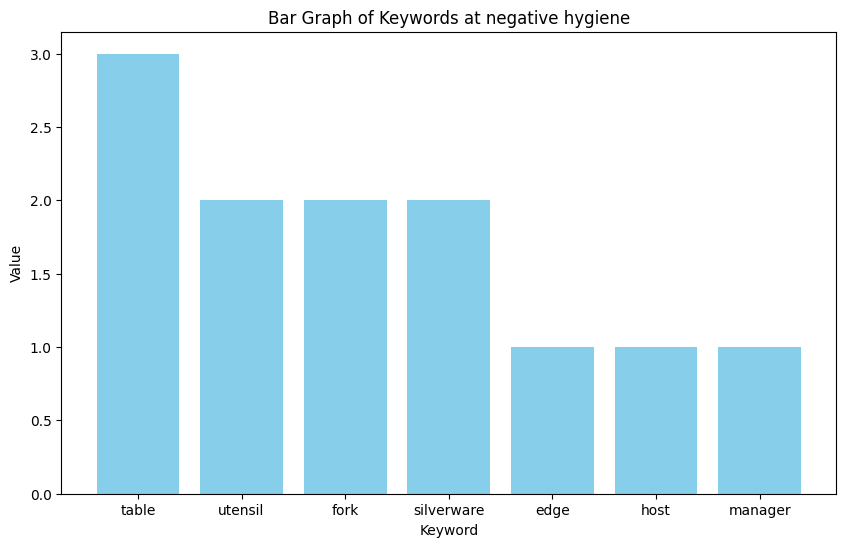

CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Positive at location
       Keyword  Value
3         mall      7
4   cheesecake      3
5      factory      3
8   restaurant      3
6      newport      2
0      advance      1
27       drive      1


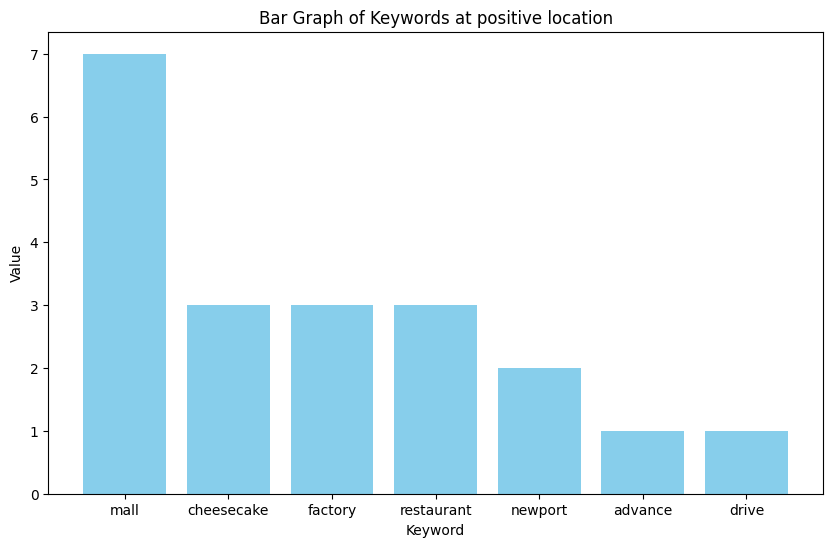

CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Negative at location
       Keyword  Value
0         mall      8
2      newport      5
9         time      5
3   cheesecake      3
4      factory      3
5   restaurant      2
16        city      2


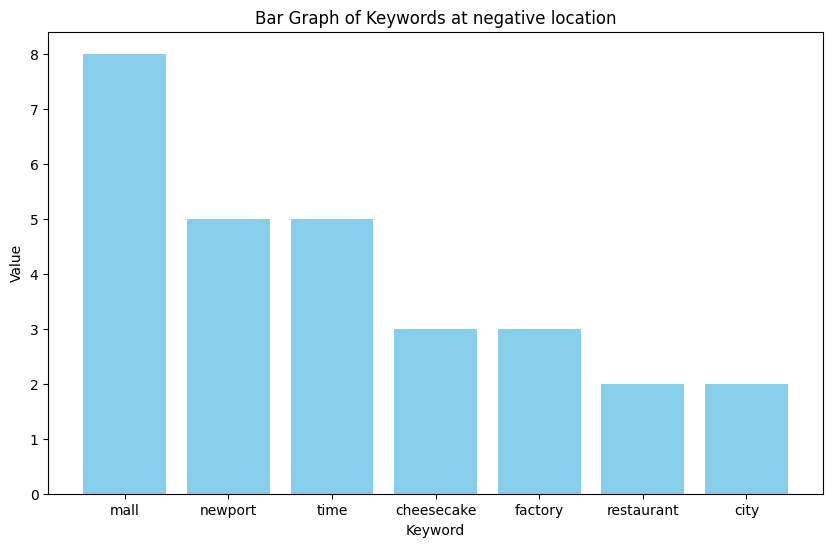

CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Positive at service
       Keyword  Value
1       server     39
6        staff     24
15    waitress     19
11        food     17
38        time     16
26       table     15
59  experience     13


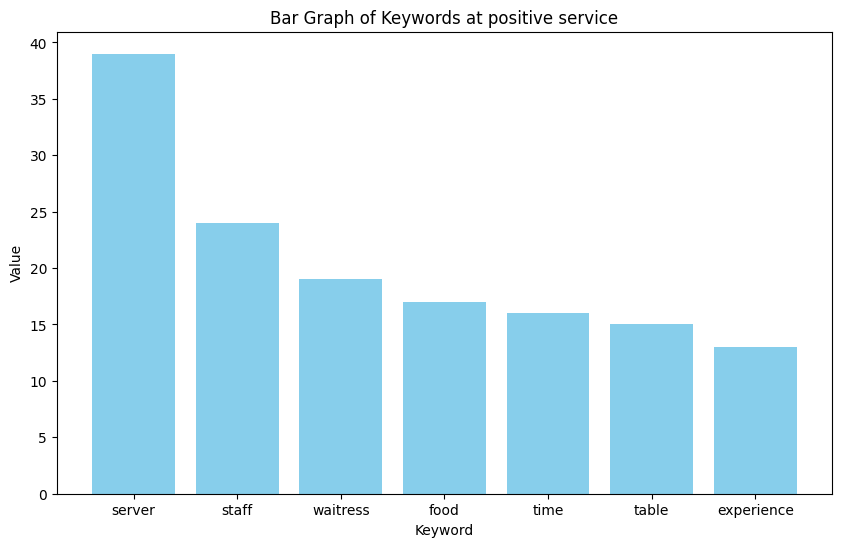

CheeseFactory at 30 Mall Dr W Unit #A22, Jersey City, NJ 07310
Negative at service
   Keyword  Value
2   server     43
0   minute     37
4    table     35
30   order     31
31    food     27
35   staff     24
5     time     21


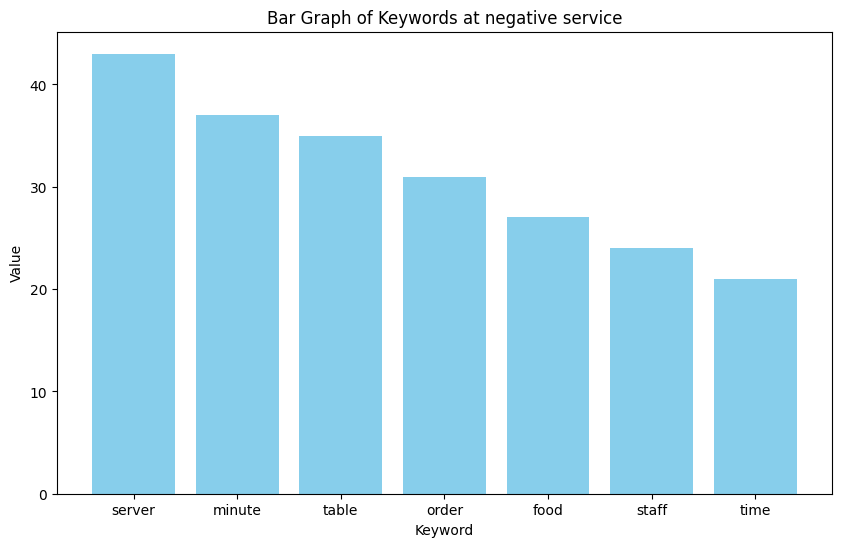

CheeseFactory at 
Positive at atmosphere
       Keyword  Value
5        place     21
0       friend      9
4       family      8
12      dining      6
14  experience      6
29        time      5
40      dinner      4


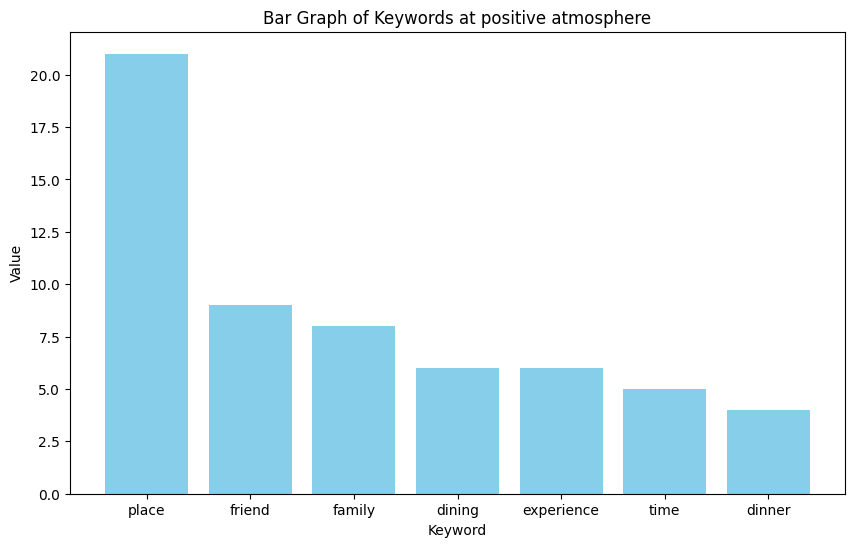

CheeseFactory at 
Negative at atmosphere
       Keyword  Value
3          bar      7
11     factory      3
10  cheesecake      3
23      dining      3
14    birthday      3
13       today      3
22  experience      3


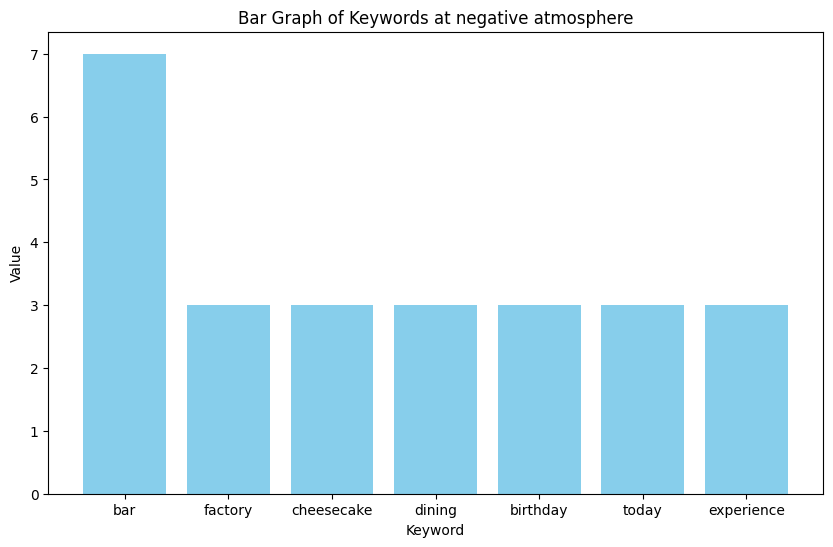

CheeseFactory at 
Positive at food
       Keyword  Value
0   cheesecake     74
8      service     54
14        menu     36
3      factory     30
55       place     26
34     chicken     23
68        time     21


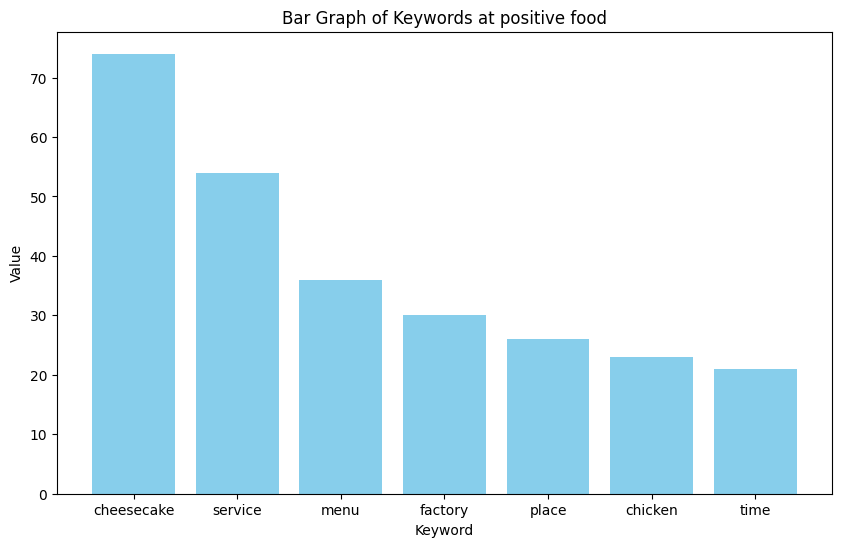

CheeseFactory at 
Negative at food
        Keyword  Value
3    cheesecake     82
2       factory     40
17      chicken     29
10         menu     20
48        pasta     18
104        time     15
23        salad     14


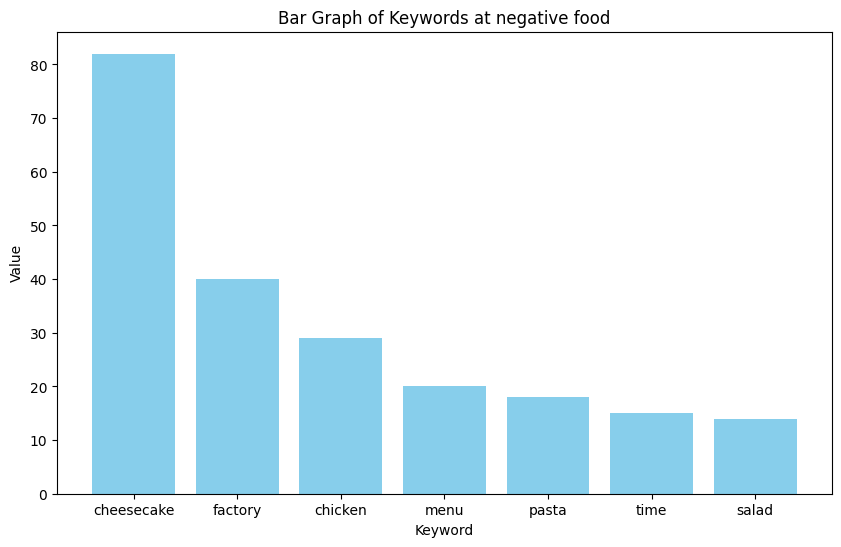

CheeseFactory at 
Positive at hygiene
      Keyword  Value
0  appearance      1
1       table      1
2       scrap      1
3     utensil      1
4         set      1
5       forba      1
6    location      1


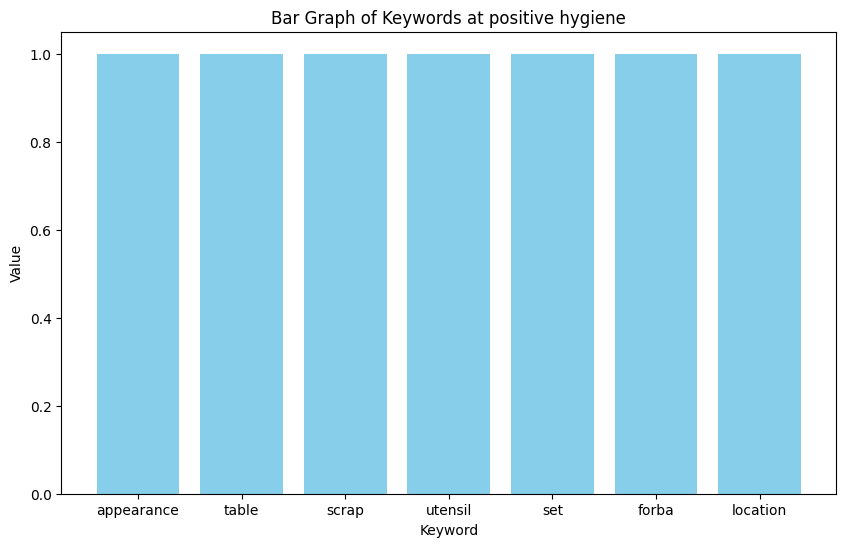

CheeseFactory at 
Negative at hygiene
      Keyword  Value
2       plate      3
3       table      3
17      glass      2
0     utensil      1
12   location      1
19  riverside      1
18      house      1


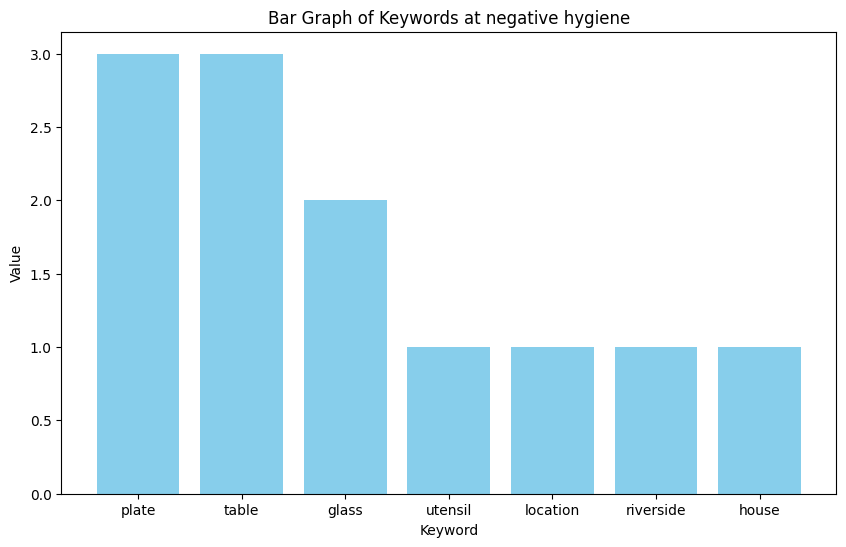

CheeseFactory at 
Positive at location
       Keyword  Value
0         mall     13
2      factory      6
1   cheesecake      5
14   riverside      5
12      square      3
5        place      2
30  hackensack      2


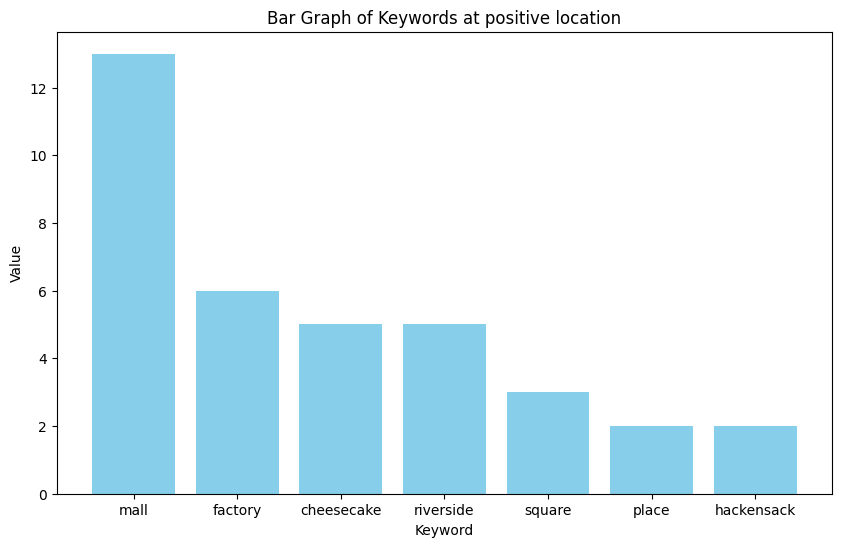

CheeseFactory at 
Negative at location
       Keyword  Value
7         mall      7
0         time      3
21     newport      2
10  cheesecake      2
12          nj      2
15         day      1
24        city      1


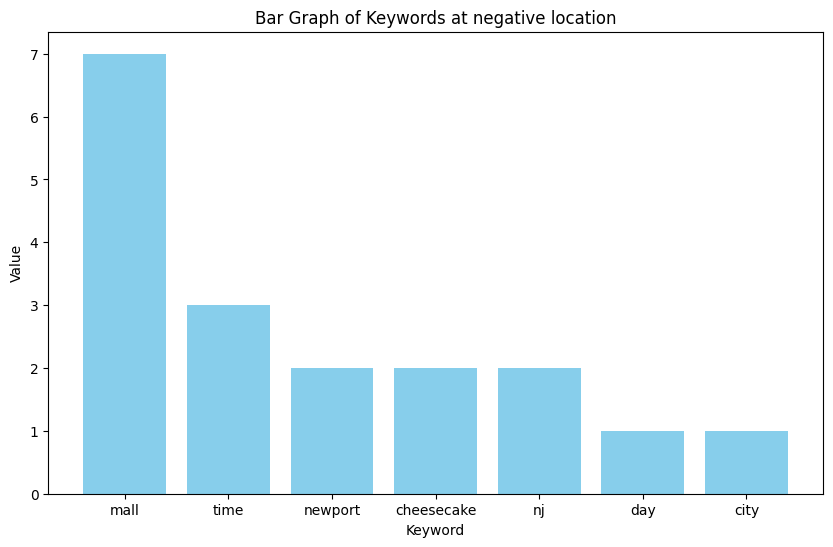

CheeseFactory at 
Positive at service
     Keyword  Value
15    server     30
1      staff     29
3       time     26
23    waiter     25
33  customer     15
43   manager     15
19  waitress     14


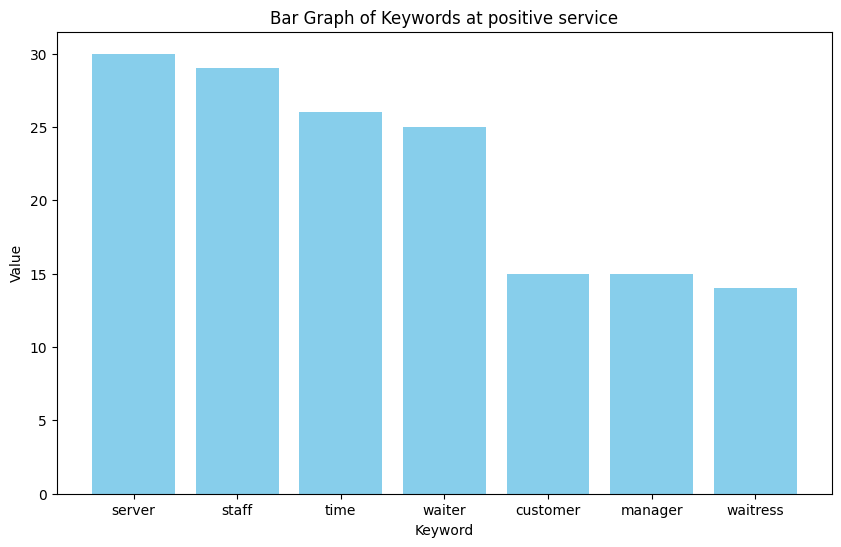

CheeseFactory at 
Negative at service
    Keyword  Value
23     time     28
4     table     27
29   server     26
41  manager     24
9     order     21
0    waiter     20
32   minute     20


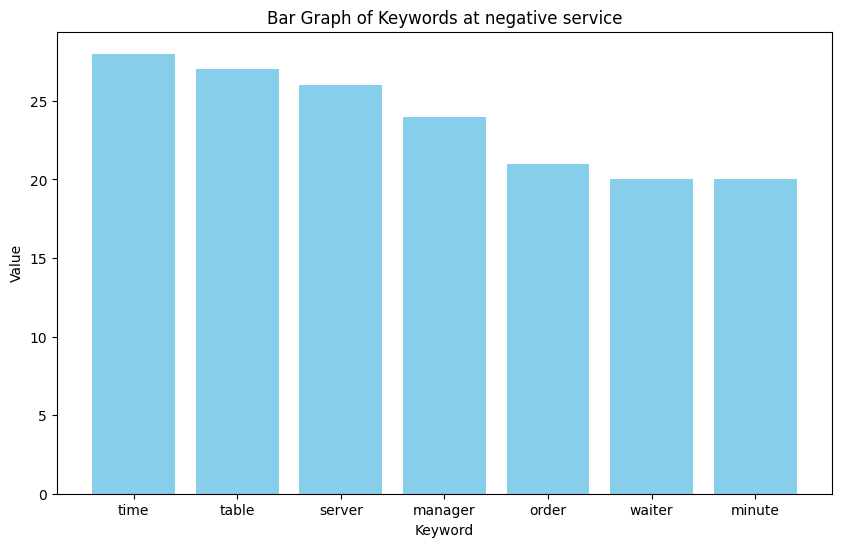

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Positive at atmosphere
       Keyword  Value
4        place     15
12      family      5
26        time      4
13         bar      4
32  experience      3
14      friend      3
10  restaurant      3


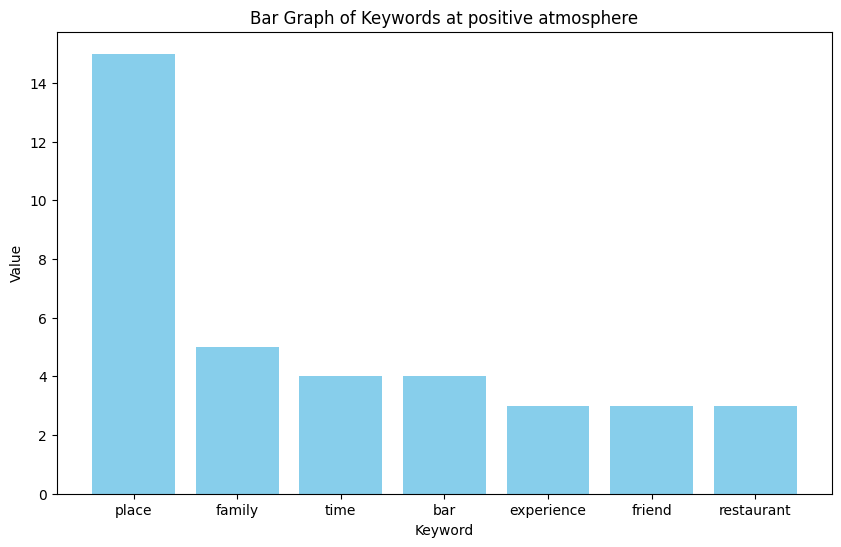

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Negative at atmosphere
   Keyword  Value
1      bar      7
2    table      4
16   place      2
5     wife      2
6     area      2
11  family      2
0     spot      1


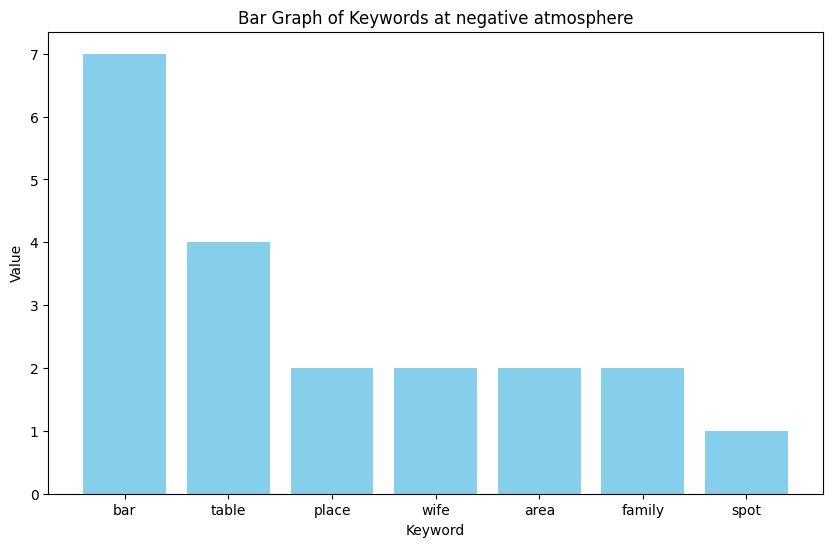

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Positive at food
      Keyword  Value
17    service     53
0     factory     32
2        menu     23
10       time     18
4     chicken     15
21  appetizer     15
16      drink     13


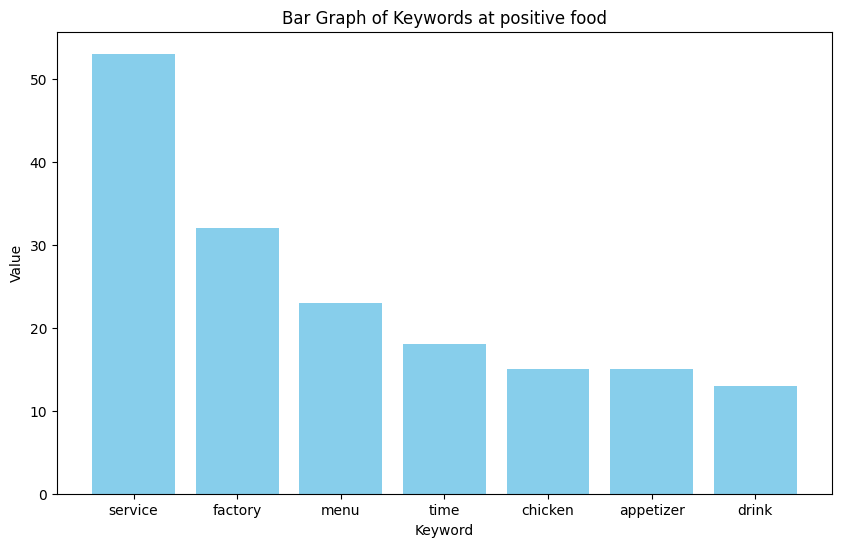

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Negative at food
     Keyword  Value
58   factory     33
0    chicken     25
7       menu     20
32      time     19
1      salad     16
116     meal     13
30     pasta     13


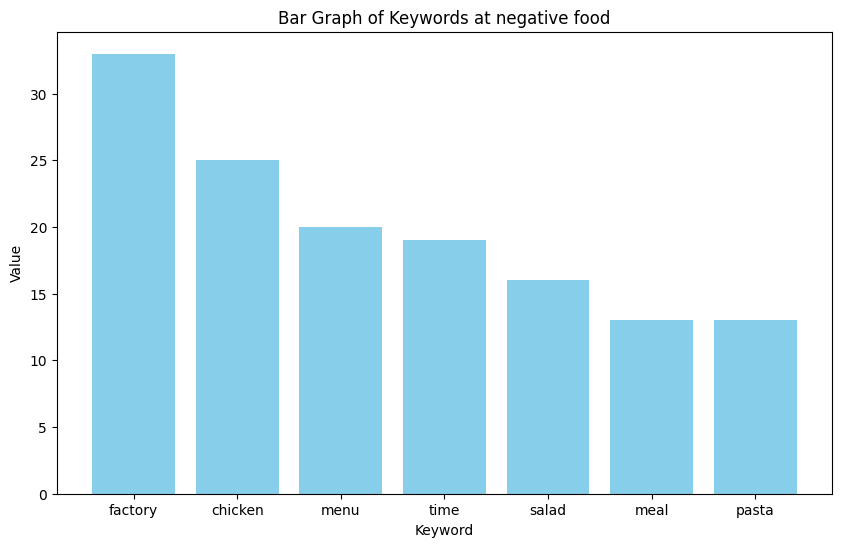

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Positive at hygiene
  Keyword  Value
1   table      2
0  slider      1
2    sowe      1
3    meal      1
4   booth      1
5    seat      1
6   place      1


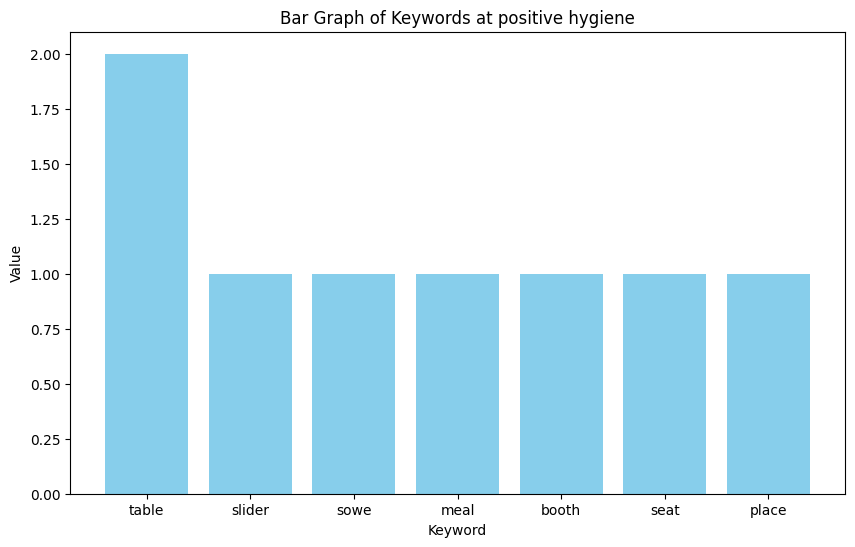

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Negative at hygiene
   Keyword  Value
1    table      8
10    food      4
21  waiter      2
2    floor      2
3     area      2
23   fruit      2
7    plate      2


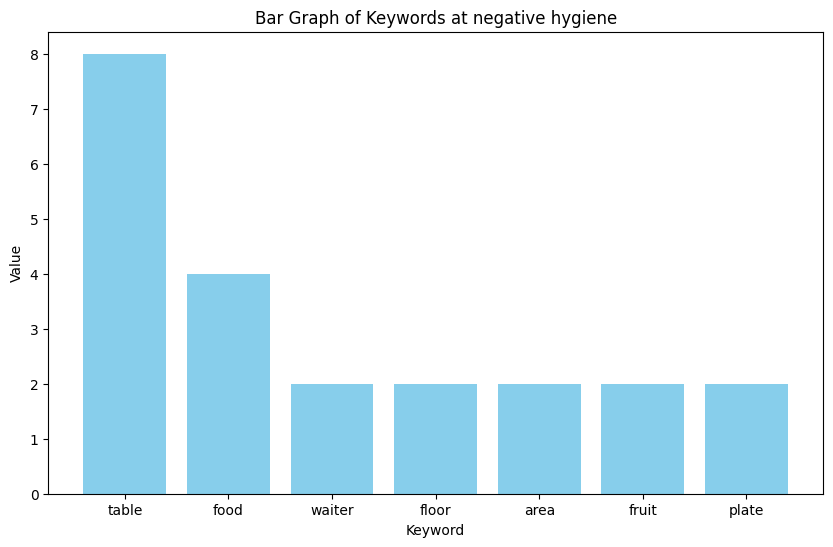

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Positive at location
   Keyword  Value
0     mall      7
3     time      3
6    short      3
7    hills      3
30   point      1
23   menlo      1
24   route      1


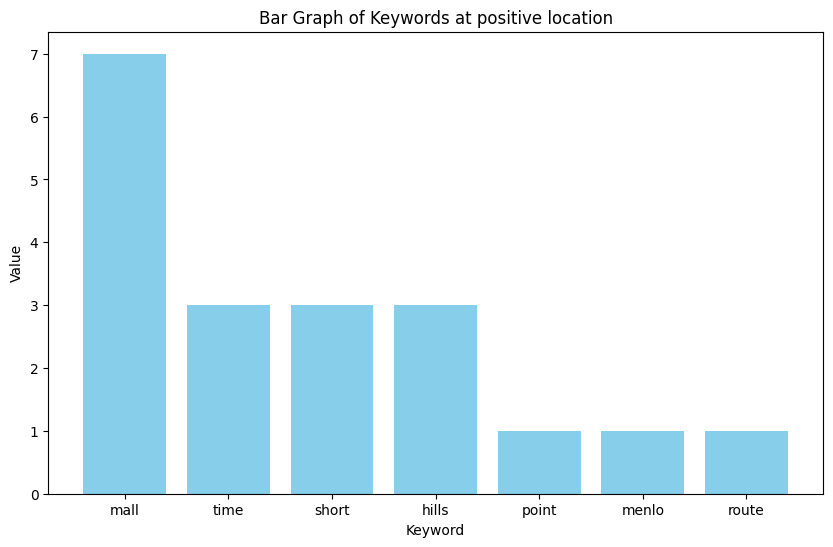

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Negative at location
        Keyword  Value
8          mall     11
2         hills      5
3          time      5
1         short      5
11      factory      3
21         hill      2
16  willowbrook      2


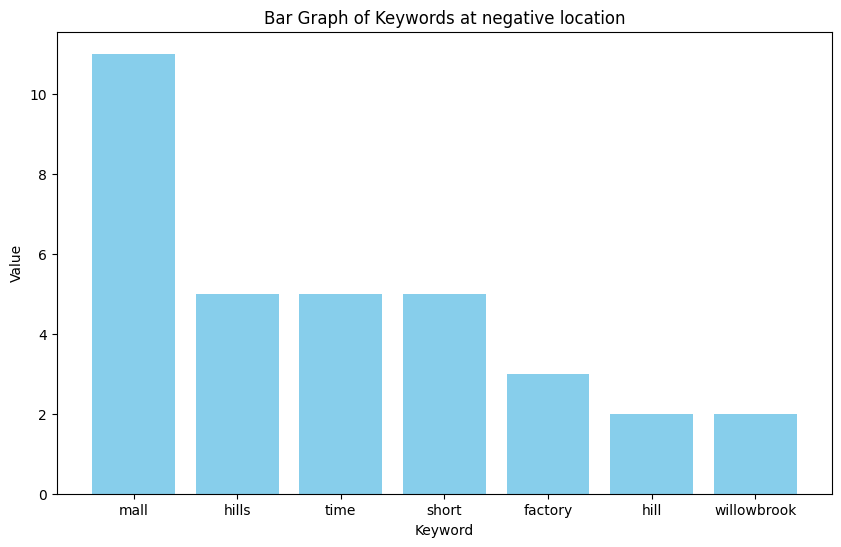

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Positive at service
     Keyword  Value
5     server     33
39      food     19
25    waiter     18
24  waitress     15
15    minute     15
1      staff     15
11     table     14


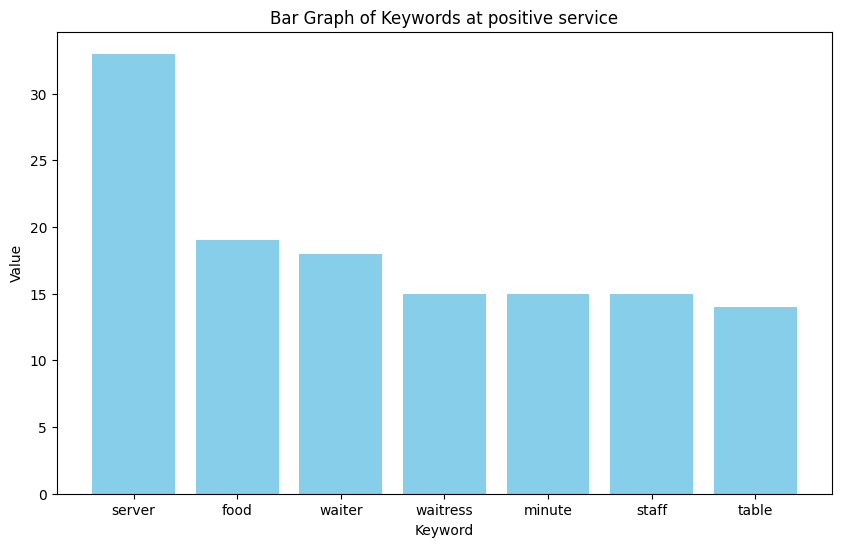

CheeseFactory at 1200 Morris Tpke Suite D-103, Short Hills, NJ 07078
Negative at service
   Keyword  Value
17  minute     45
14   table     43
12    time     39
18    food     39
46   order     38
26  server     34
19  waiter     30


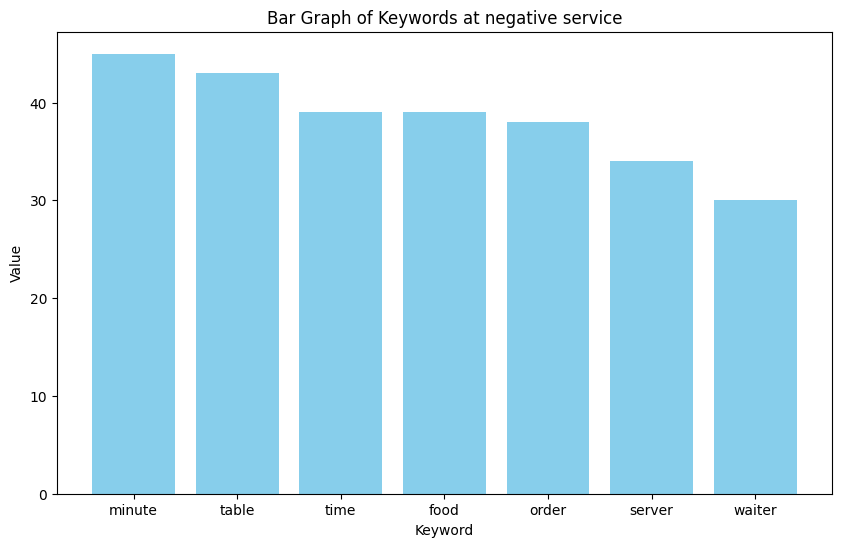

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Positive at atmosphere
       Keyword  Value
6   experience      5
2         time      4
15       night      4
9       family      4
18    birthday      3
5     ambiance      3
13        love      3


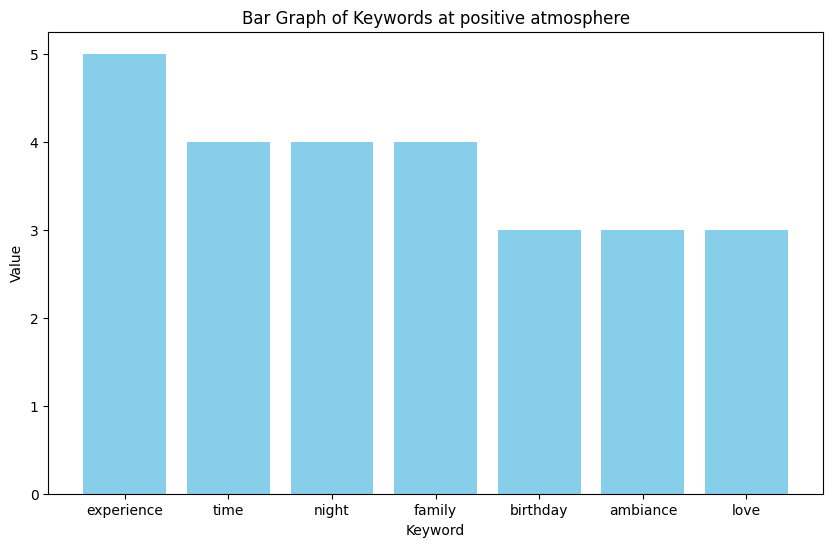

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Negative at atmosphere
   Keyword  Value
0    table      7
9   family      3
8   dinner      3
6   sunday      2
15   night      2
23  dining      2
38  arrive      1


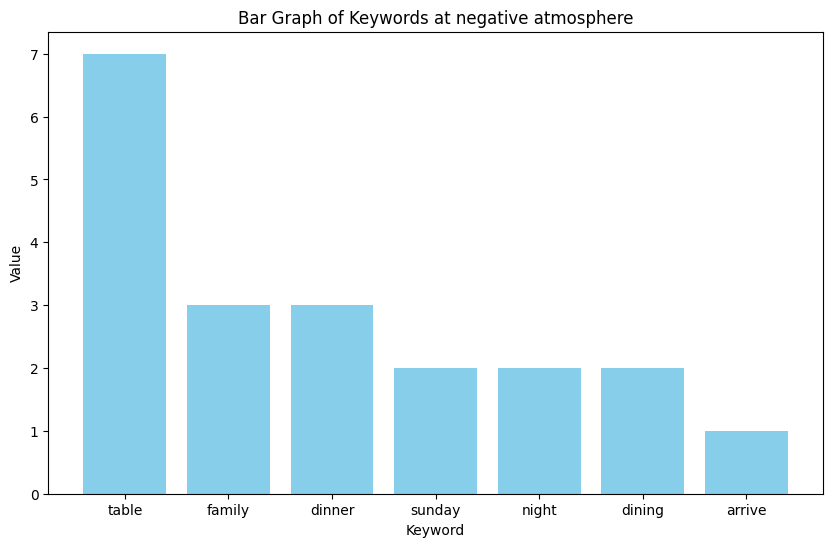

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Positive at food
     Keyword  Value
9    service     54
29   chicken     32
21      menu     23
7       time     21
5       meal     21
120    drink     18
0       cake     16


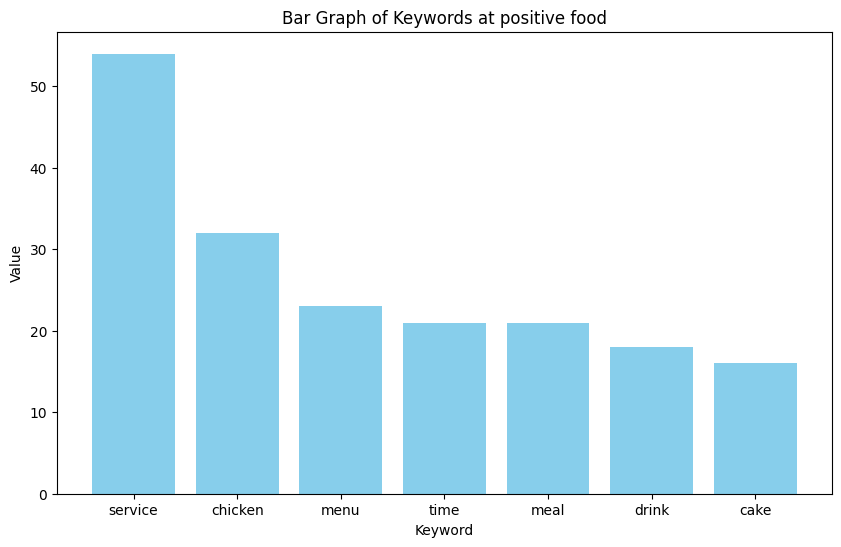

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Negative at food
    Keyword  Value
58  chicken     34
4      menu     33
7    cheese     16
86   shrimp     14
3      time     14
80     dish     13
83     meal     12


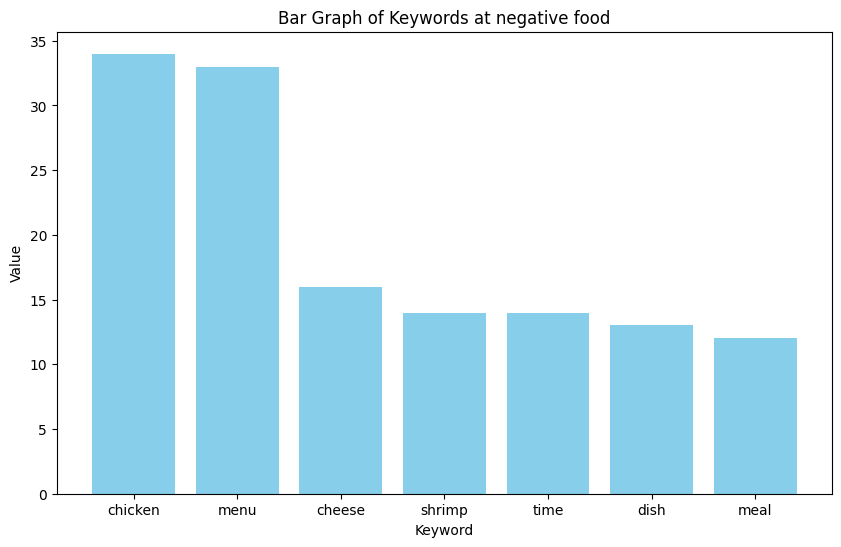

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Positive at hygiene
    Keyword  Value
0     floor      1
1        cf      1
2  protocol      1
3     night      1
4      bone      1
5       bar      1
6      wing      1


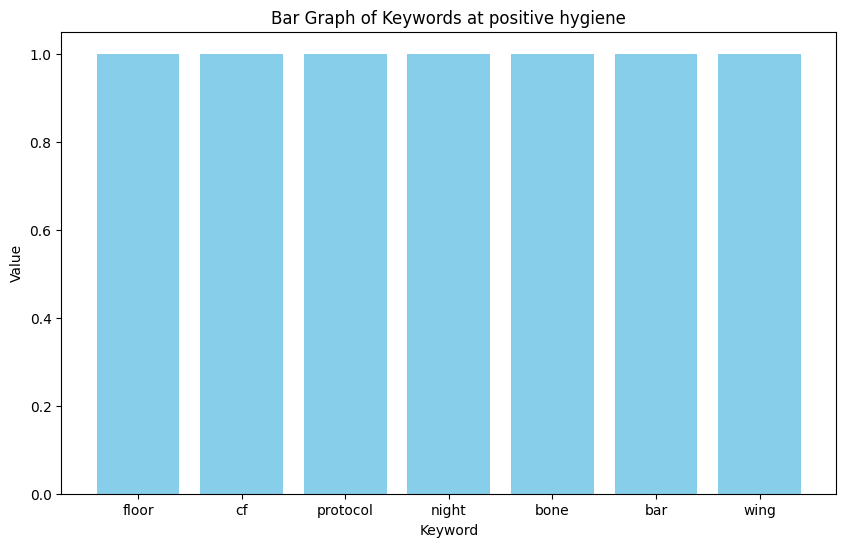

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Negative at hygiene
    Keyword  Value
4     table      3
8     plate      3
0    coffee      2
7   utensil      2
1     water      2
12     fork      2
14      tap      1


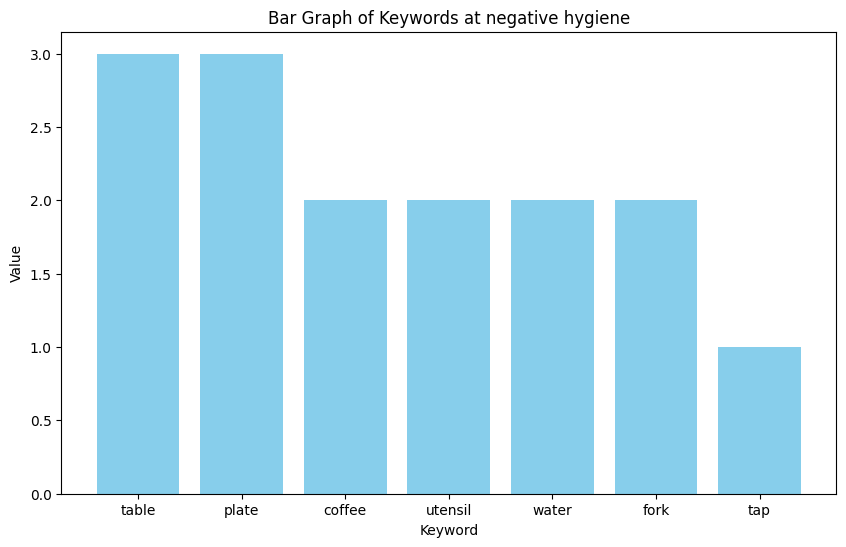

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Positive at location
     Keyword  Value
0       mall     10
7      menlo      4
10      park      3
9     edison      3
13      time      3
5   shopping      1
6       bite      1


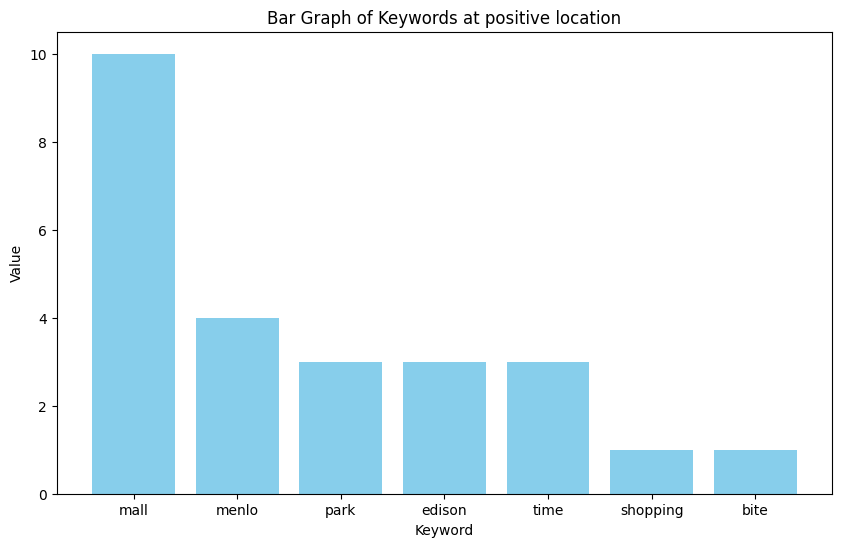

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Negative at location
       Keyword  Value
0         mall      6
4         park      6
1        menlo      4
6         time      2
2         area      1
3       edison      1
5  anniversary      1


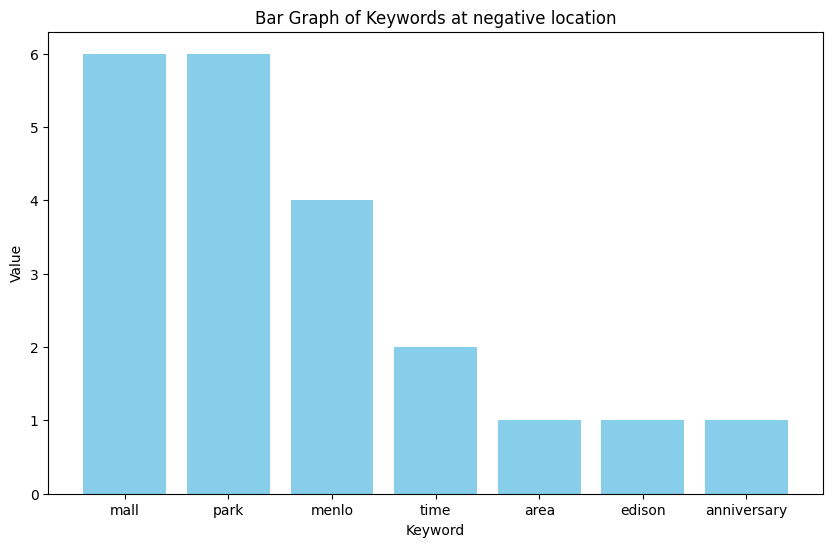

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Positive at service
   Keyword  Value
24  server     42
5     time     27
30    food     25
6   waiter     24
9    staff     20
25  minute     19
13   table     15


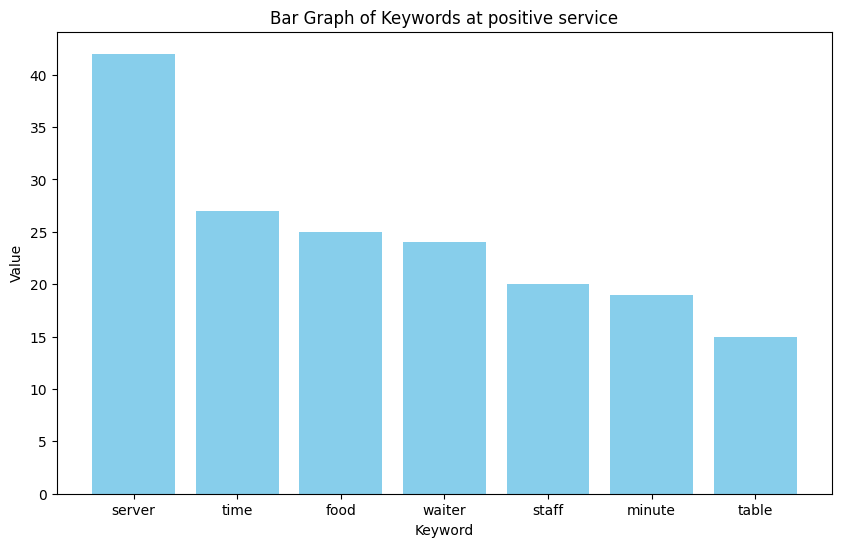

CheeseFactory at 455 Menlo Park Dr, Edison, NJ 08837
Negative at service
   Keyword  Value
27  minute     37
35   table     32
19    food     26
13    time     24
2     wait     22
3   waiter     22
25   order     21


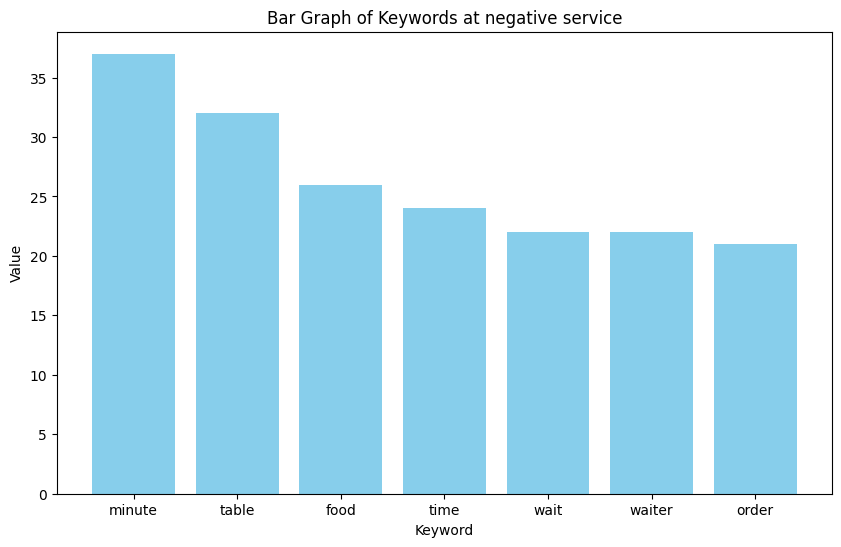

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Positive at atmosphere
       Keyword  Value
10        time      6
3   restaurant      4
1       family      4
15  experience      4
16      dining      3
2       friend      3
31         way      3


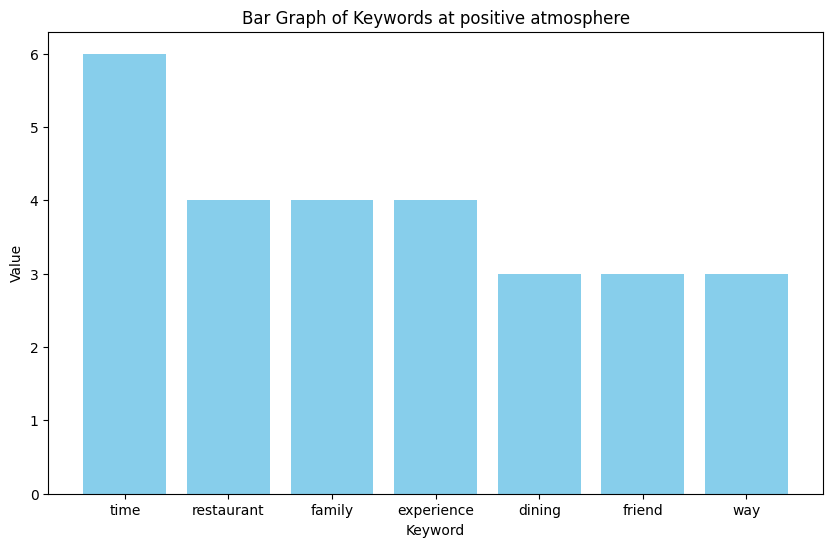

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Negative at atmosphere
       Keyword  Value
6          bar      4
4        table      4
0   cheesecake      3
24       night      3
1      factory      3
9        booth      3
15      family      3


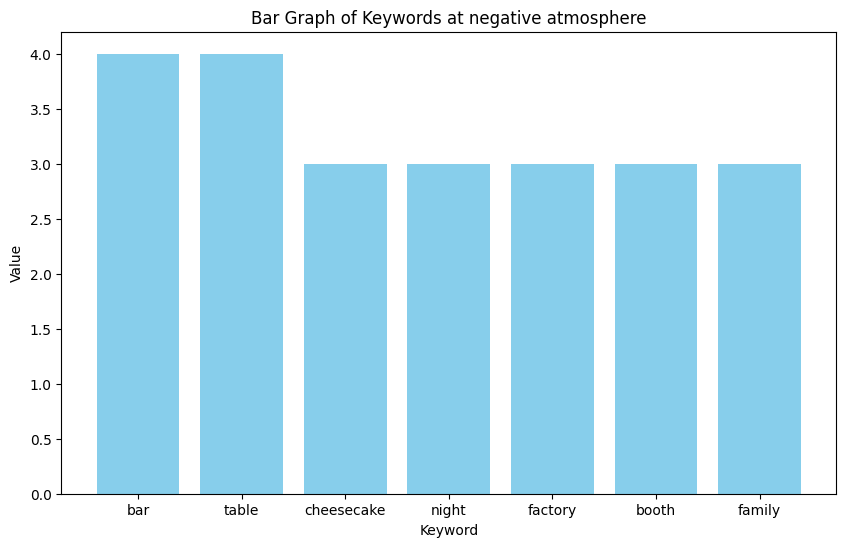

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Positive at food
       Keyword  Value
11  cheesecake    102
59     service     64
9      factory     47
47        menu     43
2      chicken     34
0      portion     22
58        time     22


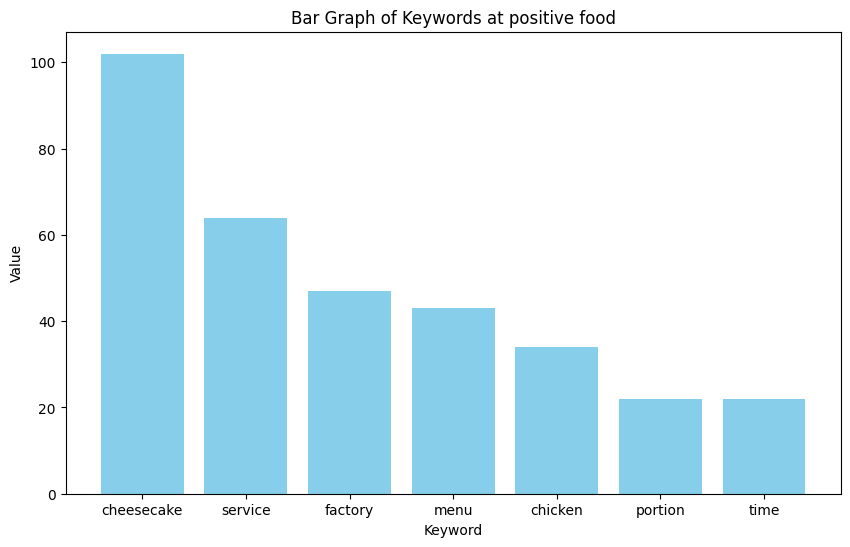

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Negative at food
       Keyword  Value
13  cheesecake     53
25     chicken     37
14     factory     33
0         menu     22
26        time     20
24       salad     20
2      portion     18


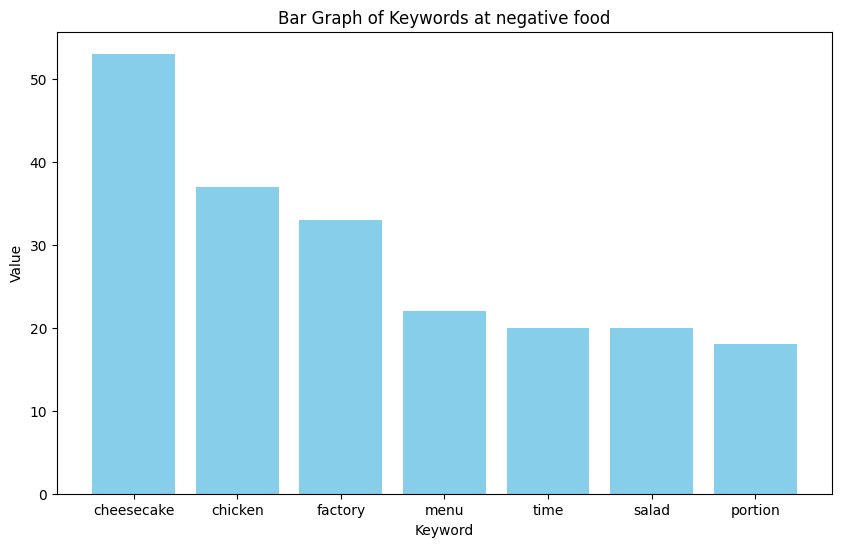

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Positive at hygiene
    Keyword  Value
5     booth      2
7  bathroom      2
0     table      1
1     party      1
2      half      1
3     stuff      1
4      foot      1


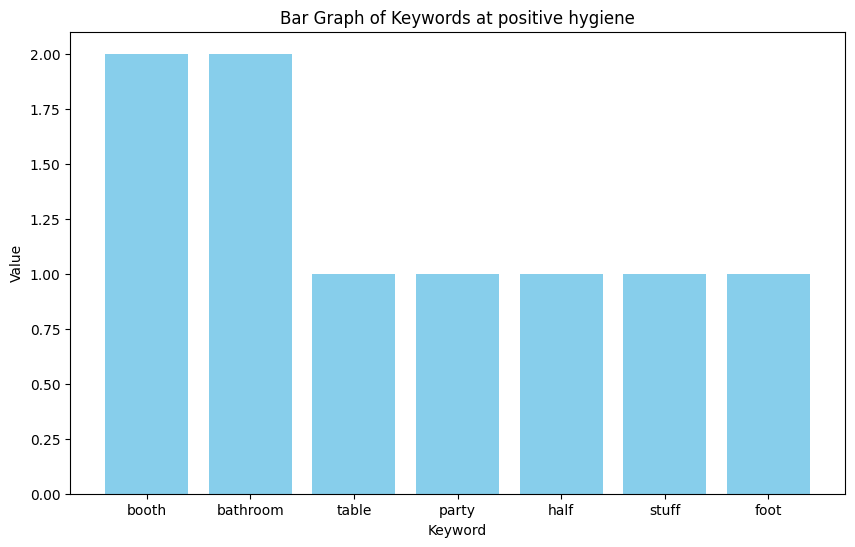

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Negative at hygiene
      Keyword  Value
2       table      4
18       food      2
8       dirty      2
0      dinner      1
13    mistake      1
22     napkin      1
21  bartenter      1


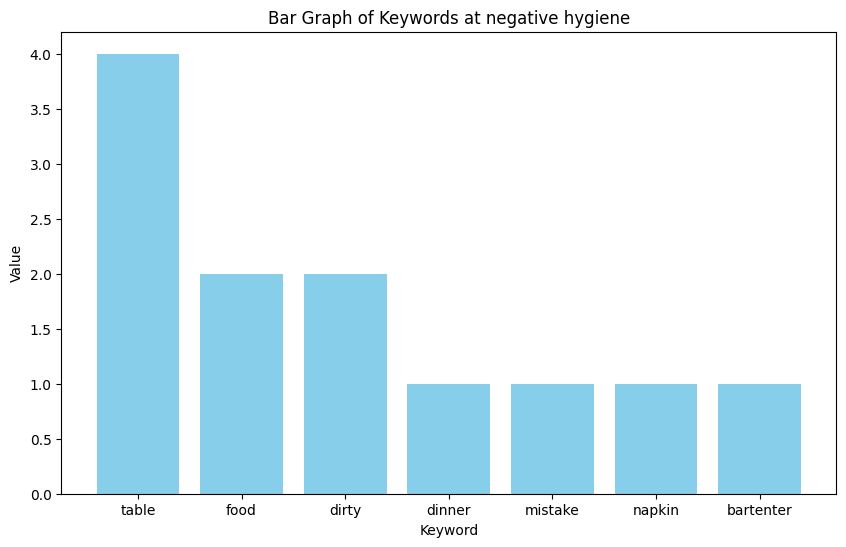

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Positive at location
        Keyword  Value
2          mall      6
18  willowbrook      4
0          time      3
30         thai      1
23           ac      1
24        drive      1
25        month      1


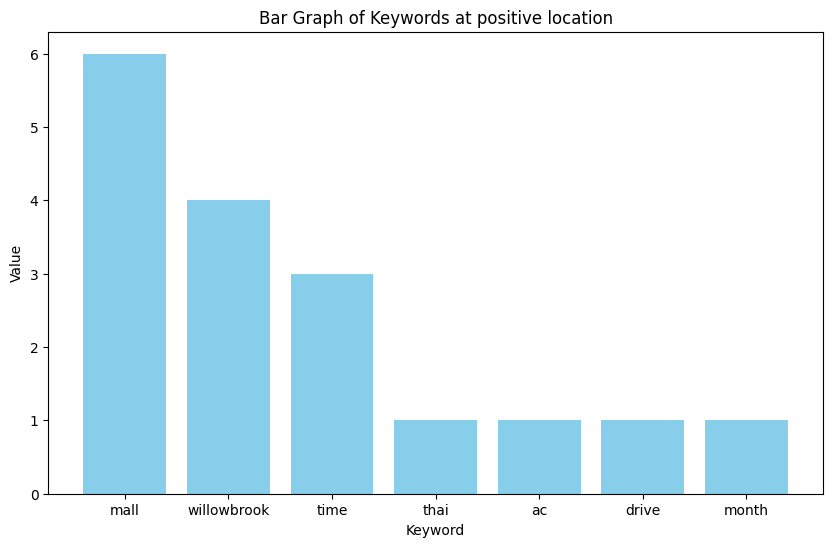

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Negative at location
        Keyword  Value
2          mall      7
3   willowbrook      2
1          time      2
0         today      1
13    cockroach      1
21         miss      1
20     landlady      1


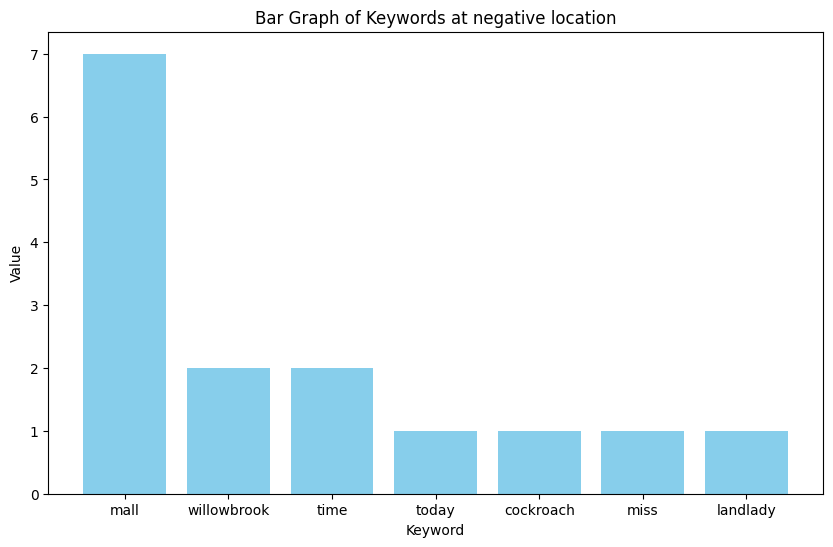

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Positive at service
     Keyword  Value
21    server     41
7     waiter     32
0      staff     30
29      food     21
6       time     17
25     table     13
33  waitress     12


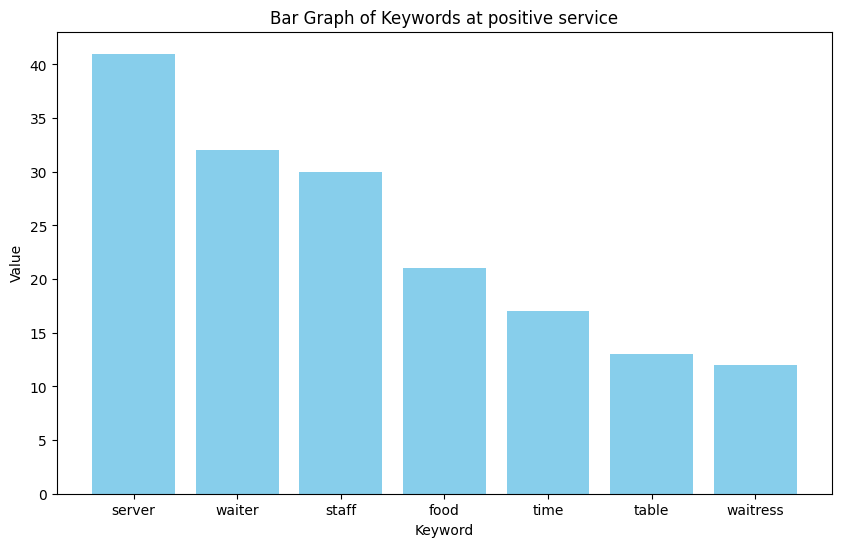

CheeseFactory at 1700 Willowbrook Blvd, Wayne, NJ 07470
Negative at service
   Keyword  Value
8   minute     33
16    food     28
2     time     24
25   table     22
17  waiter     22
37   order     18
3   server     18


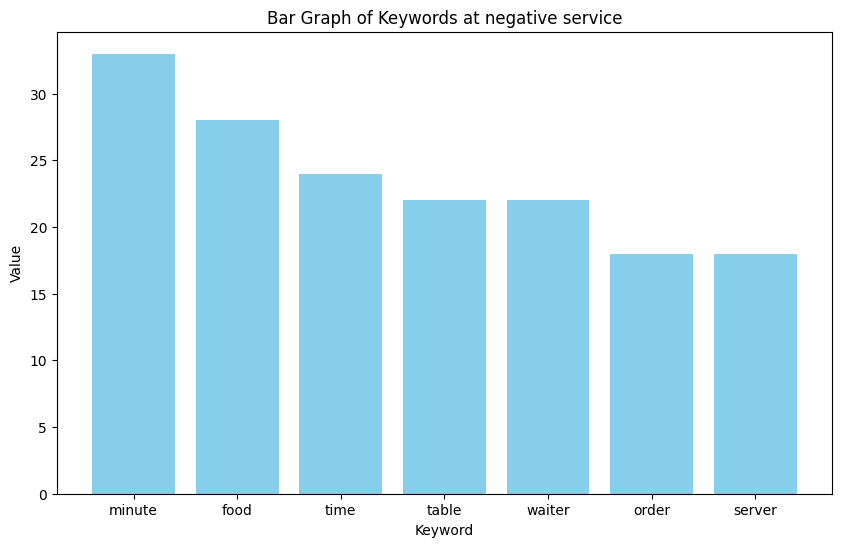

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Positive at atmosphere
       Keyword  Value
0        place     25
17        time      9
14      family      7
12      friend      6
6   experience      6
29    birthday      5
7   cheesecake      5


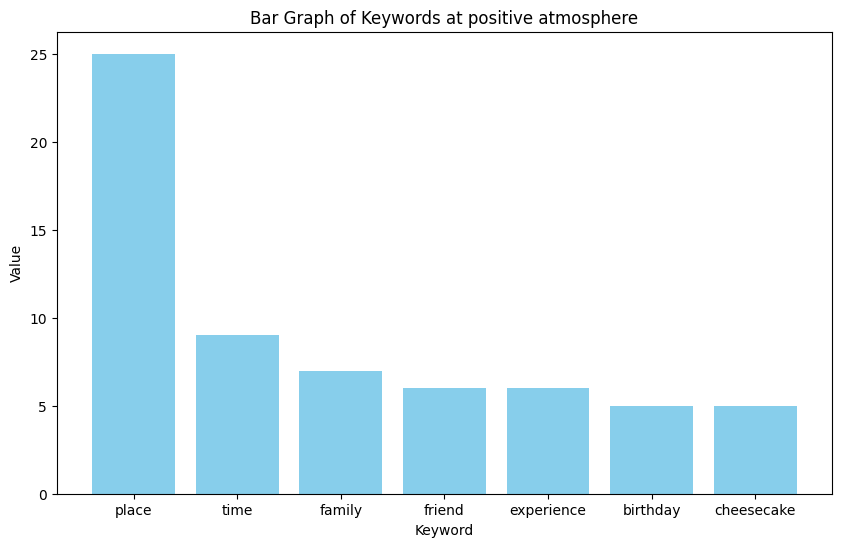

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Negative at atmosphere
       Keyword  Value
4        table      8
1          bar      4
8       family      3
0   experience      2
15      dining      2
28       place      2
9      factory      2


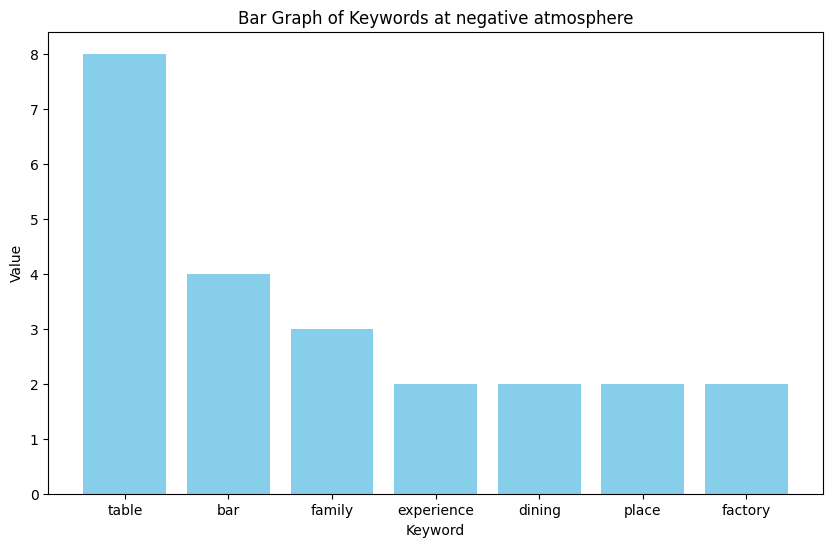

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Positive at food
        Keyword  Value
17   cheesecake     85
72      service     45
19      factory     42
9       chicken     38
2          menu     28
163       place     22
3          meal     19


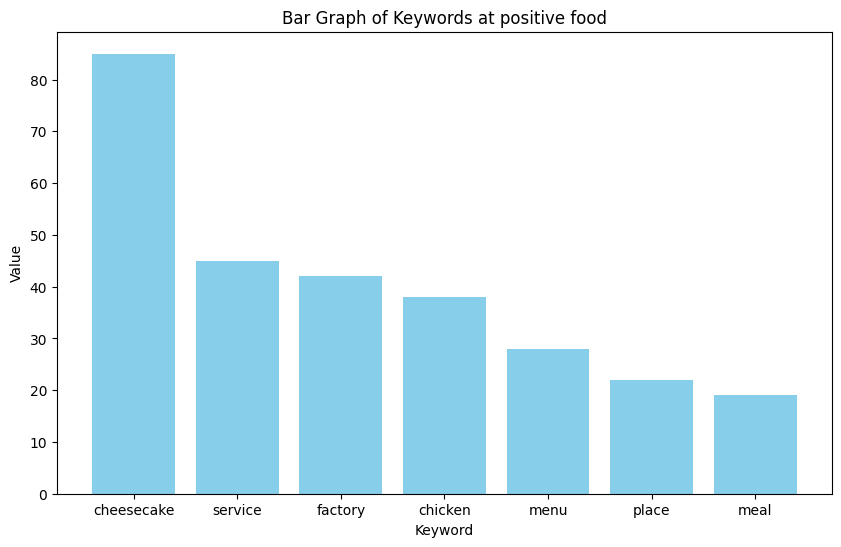

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Negative at food
       Keyword  Value
10  cheesecake     61
7      factory     34
1      chicken     28
67        menu     19
8         time     17
4        drink     16
28   appetizer     14


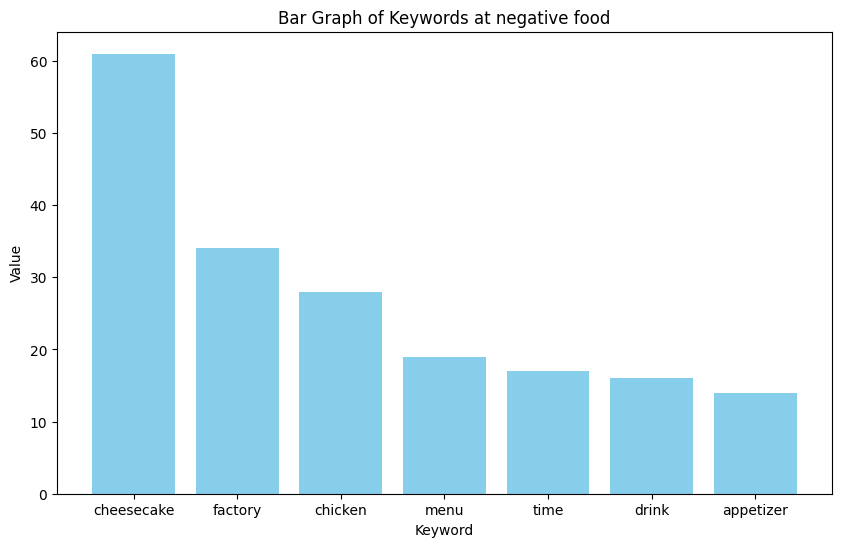

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Positive at hygiene
      Keyword  Value
1       place      3
5       table      3
0    location      2
3        food      2
9    bathroom      2
2  everyrhing      1
4        fact      1


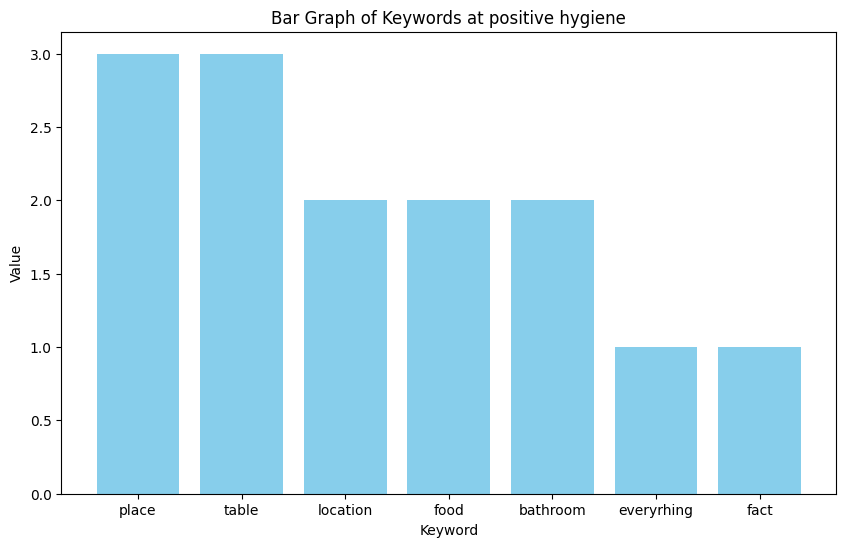

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Negative at hygiene
       Keyword  Value
8        table      5
0         food      3
13  silverware      3
14      napkin      3
22       thing      1
21       night      1
20       scrap      1


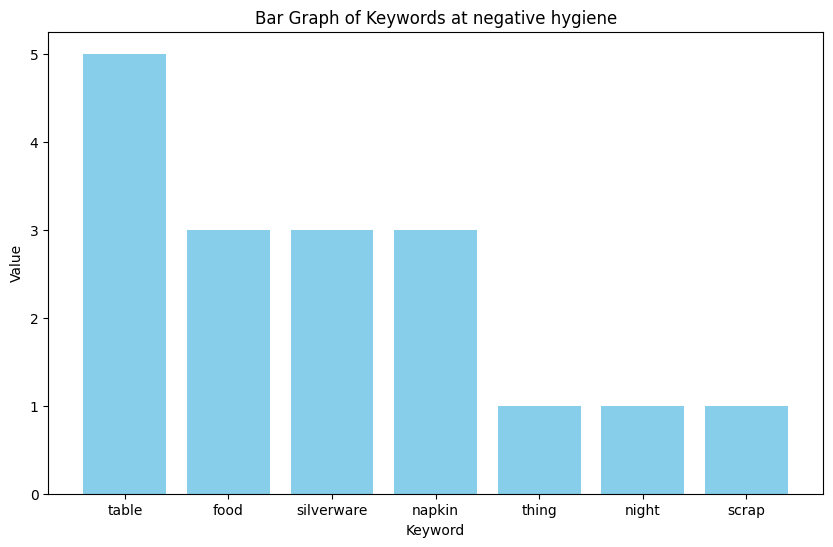

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Positive at location
       Keyword  Value
0         mall     10
2     freehold      7
12  cheesecake      5
1      raceway      5
10     factory      5
4           nj      2
24         way      2


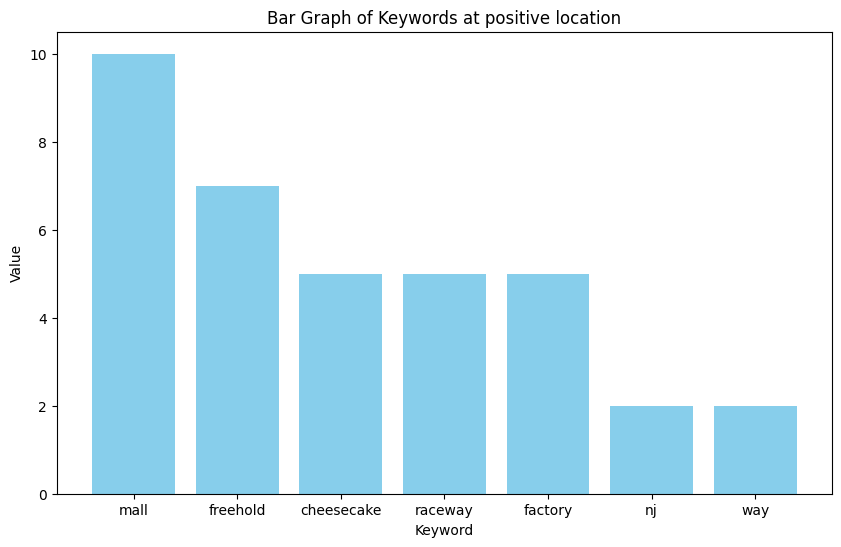

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Negative at location
        Keyword  Value
2          mall      5
0          time      2
1         menlo      1
3  quakerbridge      1
4         place      1
5           day      1
6        friday      1


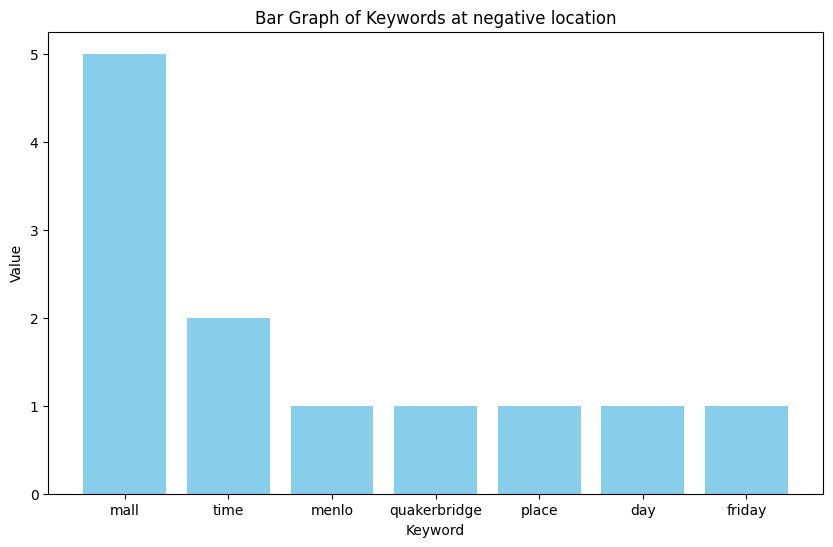

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Positive at service
     Keyword  Value
5     server     46
11      time     27
15      food     25
10    waiter     22
25     staff     18
13  waitress     17
63     table     14


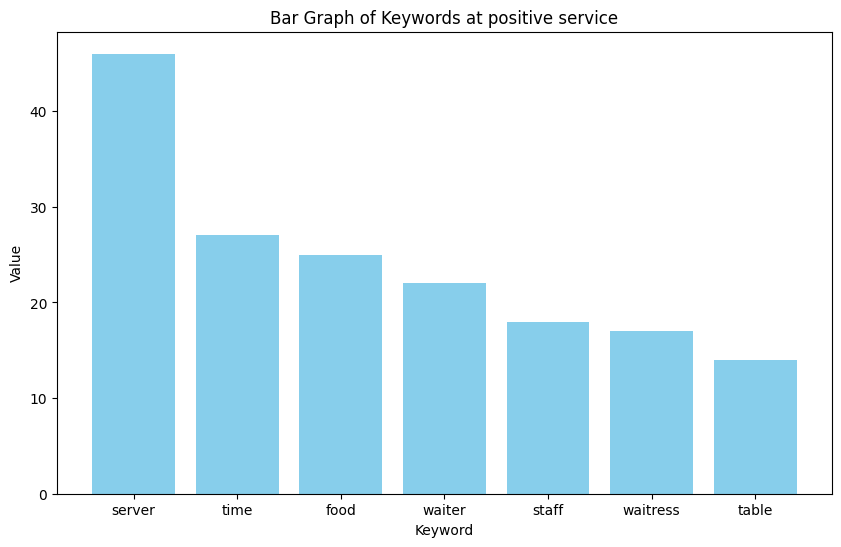

CheeseFactory at 3710 US-9, Freehold, NJ 07728
Negative at service
     Keyword  Value
18    minute     46
0      table     30
49      time     29
5       food     27
3   waitress     26
16    server     25
2     waiter     23


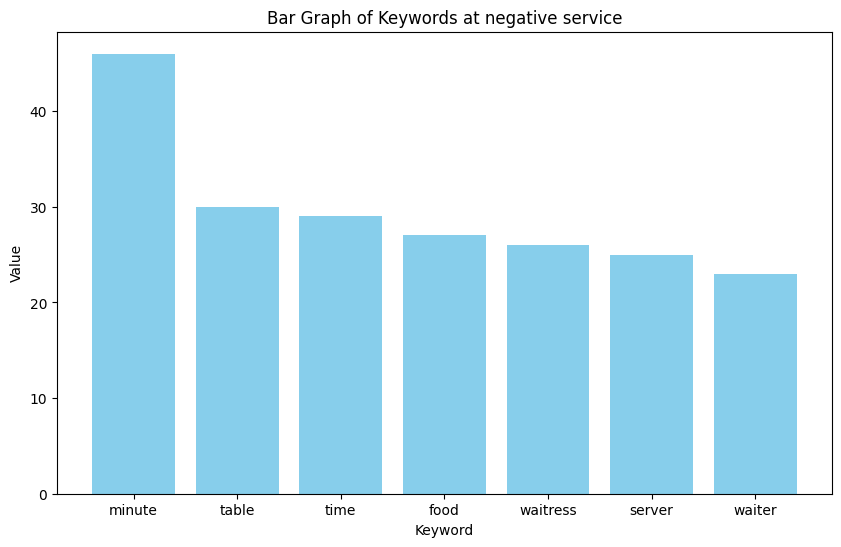

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Positive at atmosphere
       Keyword  Value
6        place     13
9       family      6
12        time      5
5   experience      5
27       table      4
8       friend      4
29      people      3


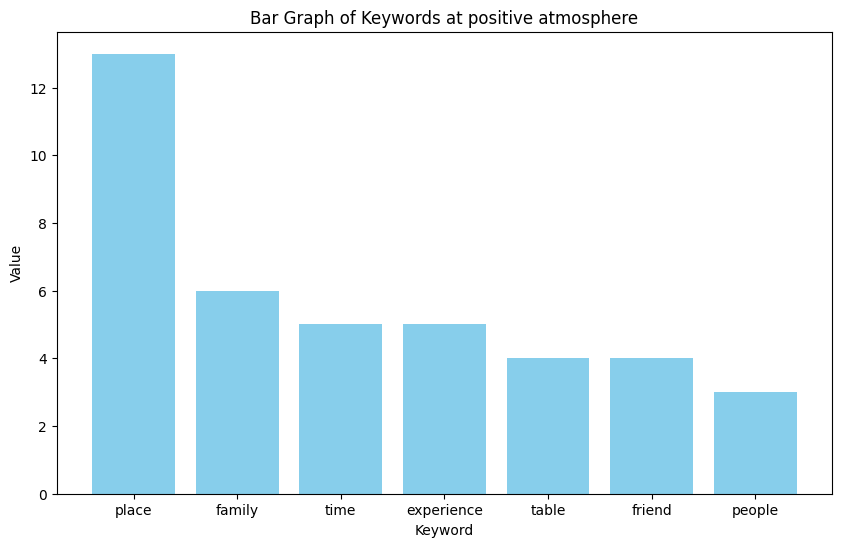

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Negative at atmosphere
   Keyword  Value
8    table      6
4      bar      4
5     time      4
6   family      4
10   night      3
11      pm      2
24   place      2


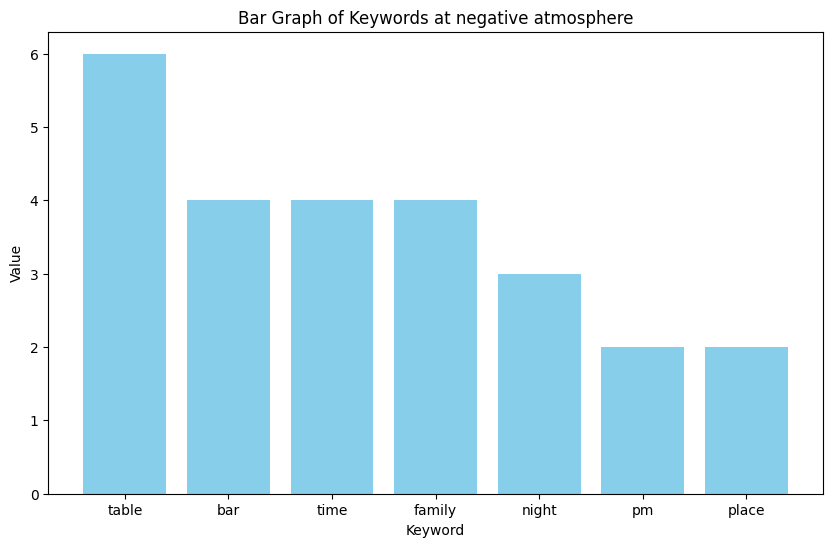

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Positive at food
        Keyword  Value
23   cheesecake     80
51      service     60
6          menu     30
28      factory     27
4       chicken     22
16      portion     18
110       drink     17


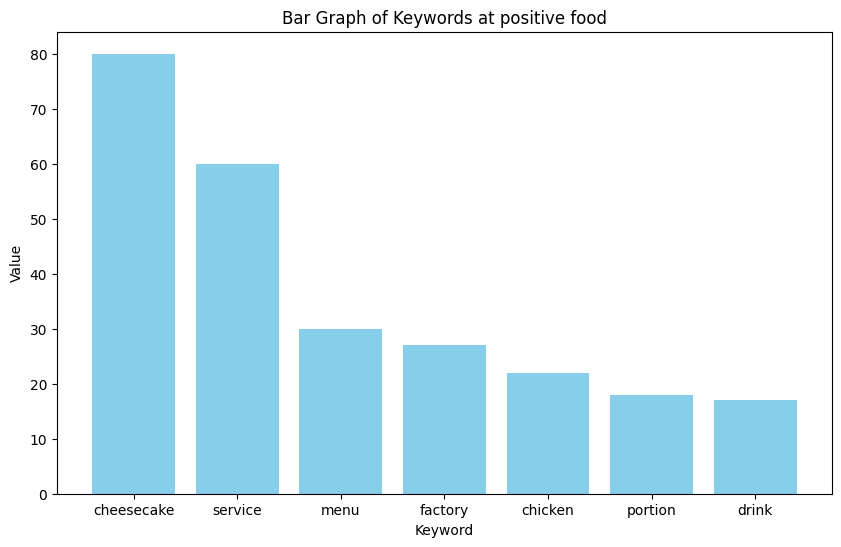

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Negative at food
       Keyword  Value
5   cheesecake     52
36     chicken     41
62     factory     24
2         menu     16
41       pasta     15
44        time     15
32        meal     12


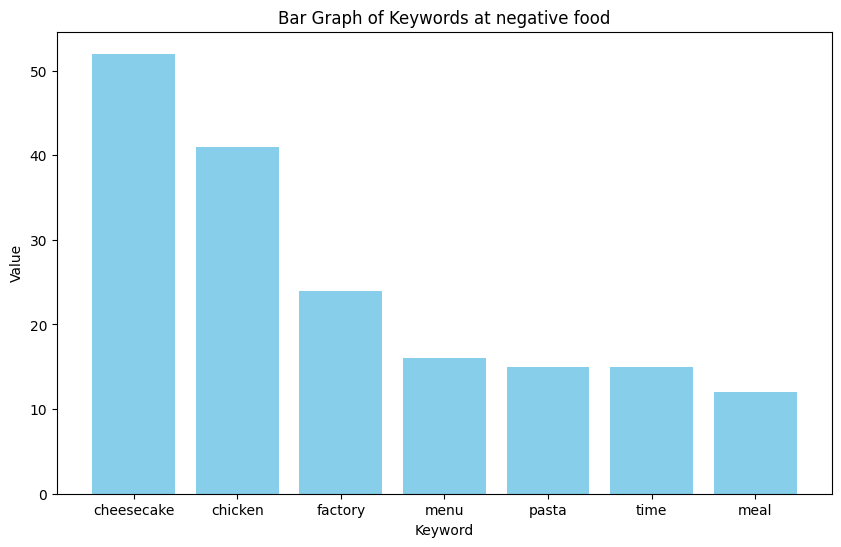

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Positive at hygiene
      Keyword  Value
0  restaurant      2
5       table      2
7    employee      2
1        area      1
2    customer      1
3       visit      1
4  silverware      1


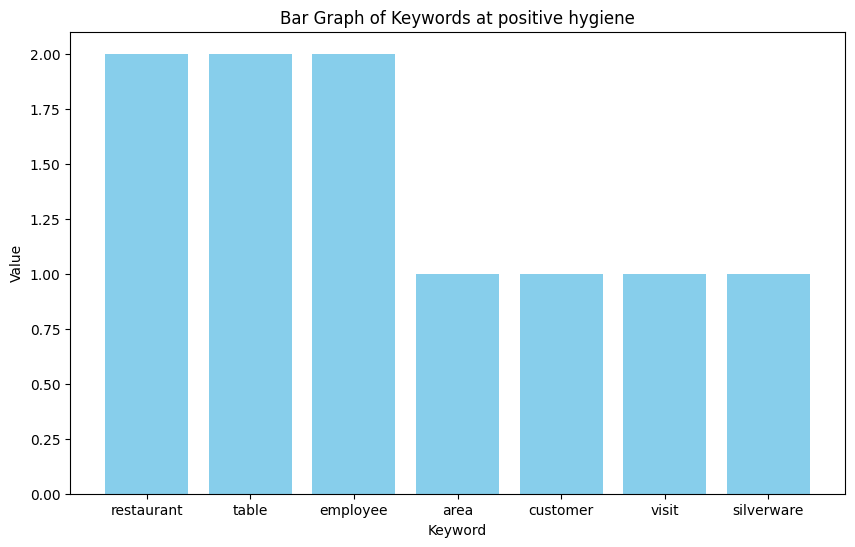

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Negative at hygiene
     Keyword  Value
6      table     10
13     place      4
2    utensil      3
12     glass      3
1        cup      2
17   service      2
20  bathroom      2


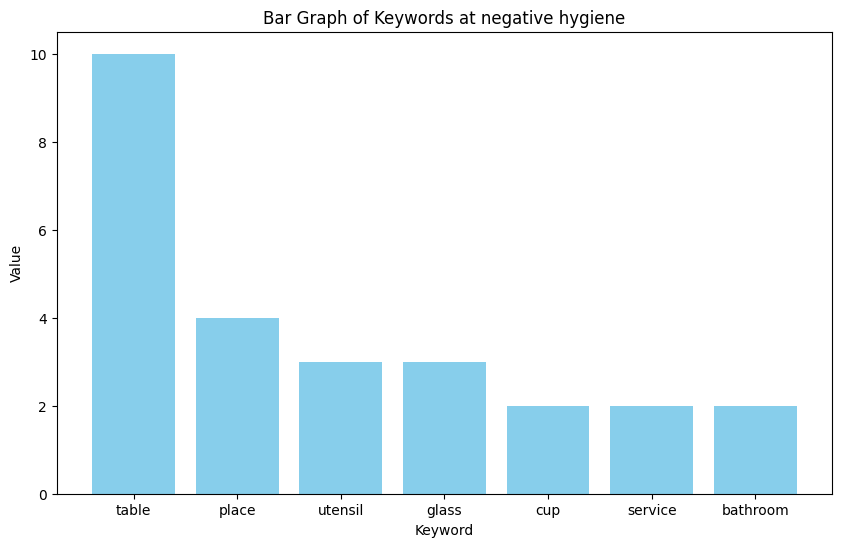

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Positive at location
      Keyword  Value
1    rockaway      3
2  cheesecake      2
3     factory      2
5        mall      2
0        time      1
4     country      1
6      moment      1


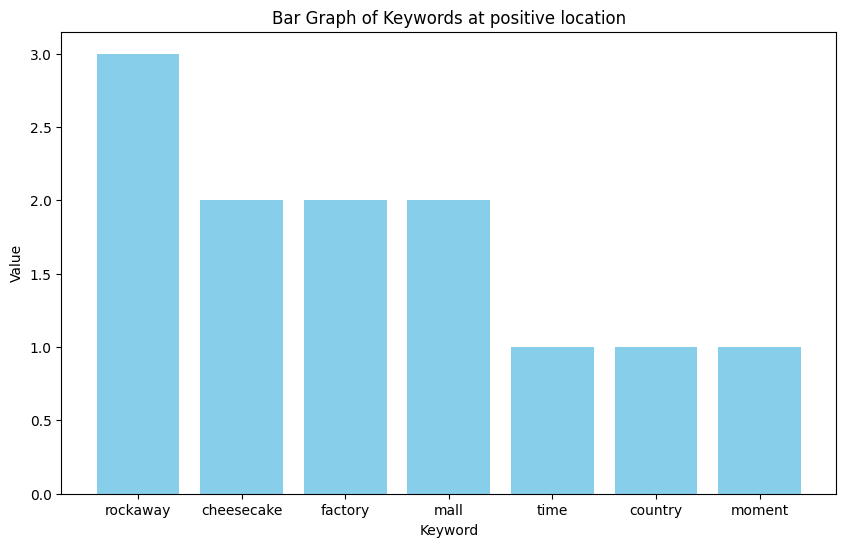

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Negative at location
        Keyword  Value
0      rockaway     11
7          mall     10
25         time      7
9    cheesecake      5
10      factory      5
1            nj      2
8   willowbrook      2


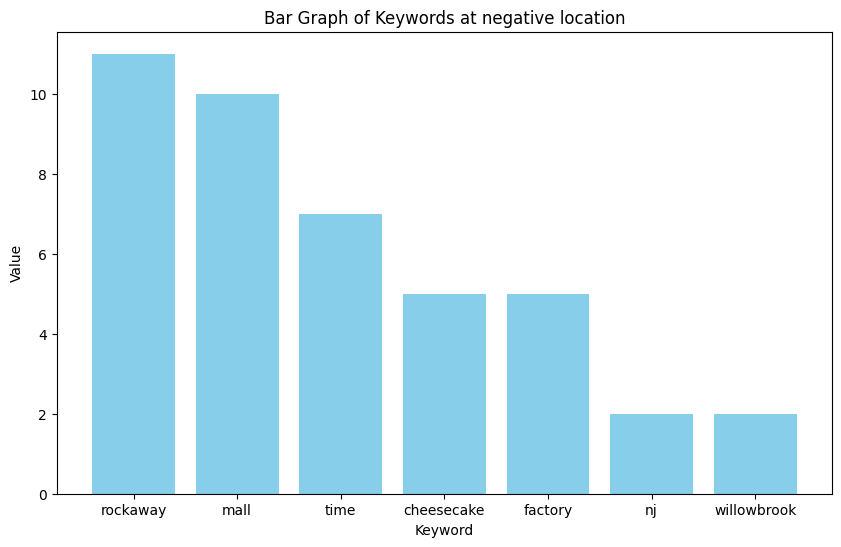

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Positive at service
     Keyword  Value
8     server     42
7     waiter     32
19  waitress     24
46      food     23
57      time     15
35     table     13
30      wait     12


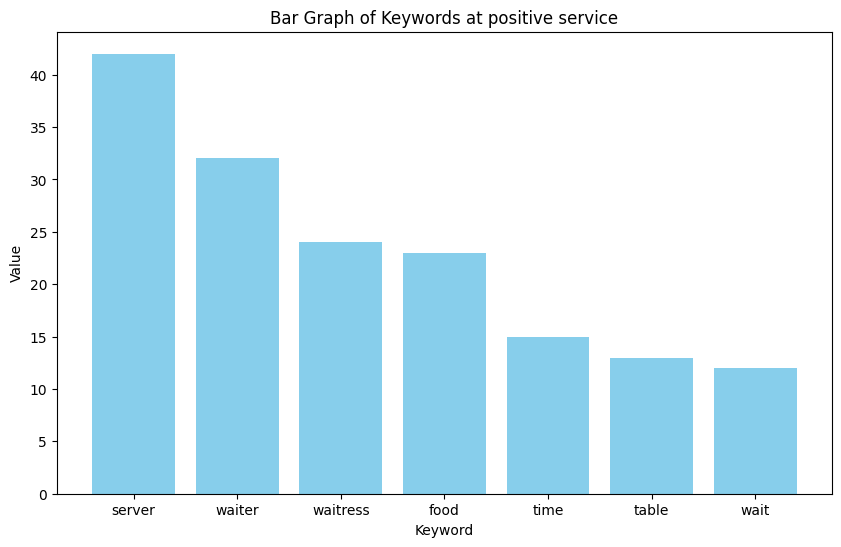

CheeseFactory at 301 Mt Hope Ave Suite 1013B, Rockaway, NJ 07866
Negative at service
   Keyword  Value
23   table     39
15    time     37
1   minute     37
13  server     35
38   order     30
25    food     27
7   waiter     26


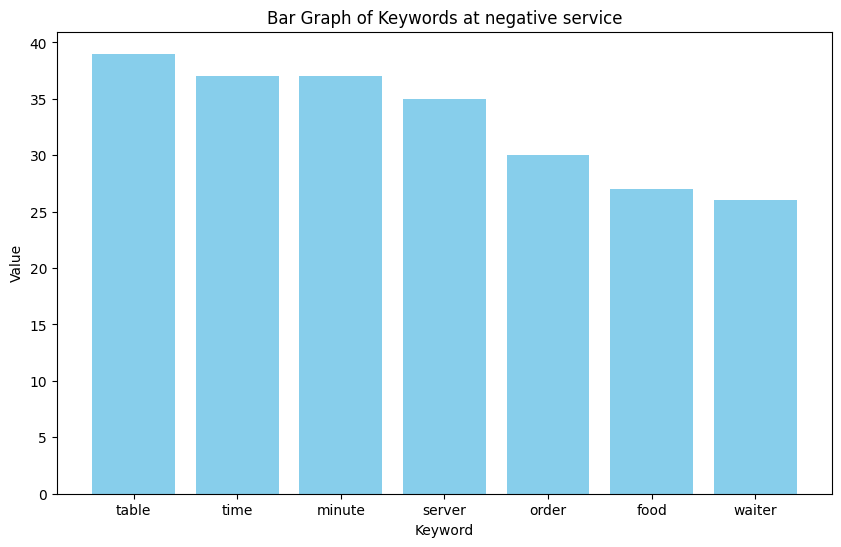

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Positive at atmosphere
       Keyword  Value
0        place     20
9       family      7
7       friend      5
2      factory      4
18    birthday      4
4   experience      4
8         time      4


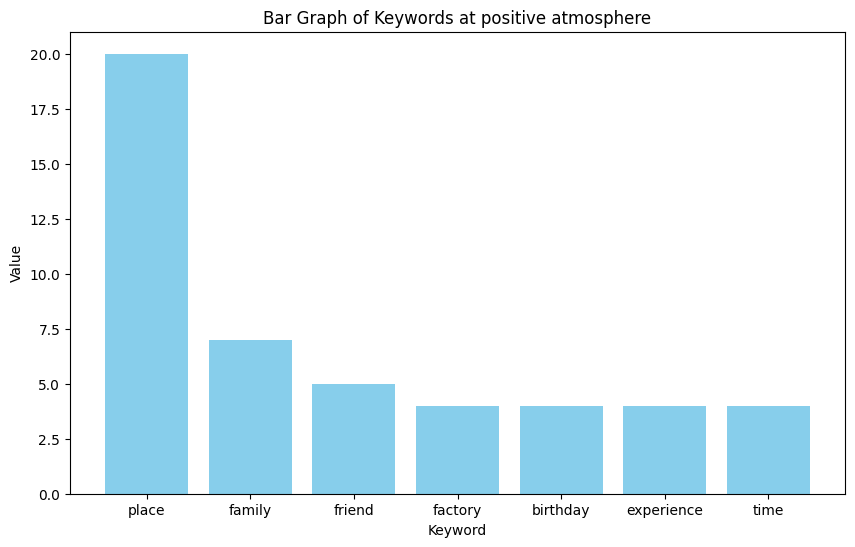

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Negative at atmosphere
       Keyword  Value
0          bar      4
2        place      4
3          bit      3
26      family      3
8      factory      2
22       night      2
13  experience      2


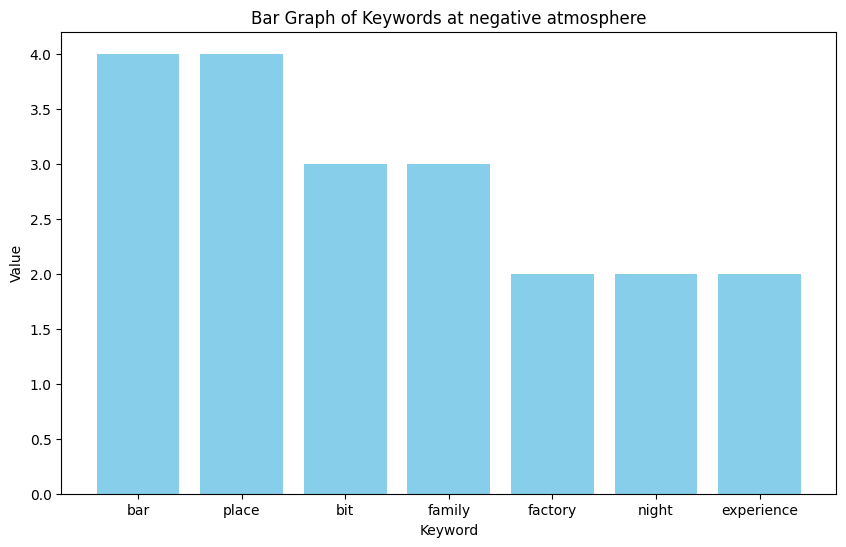

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Positive at food
       Keyword  Value
8   cheesecake     94
0      service     74
32        menu     44
50     factory     35
56     chicken     28
29       place     27
39        cake     24


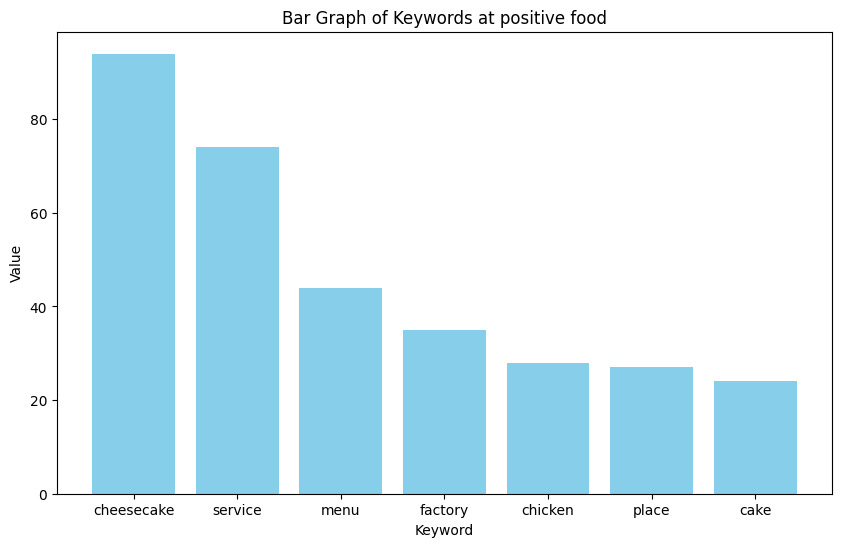

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Negative at food
       Keyword  Value
4   cheesecake     57
24     chicken     33
1      factory     25
72        menu     25
2         time     17
67        dish     15
12        meal     14


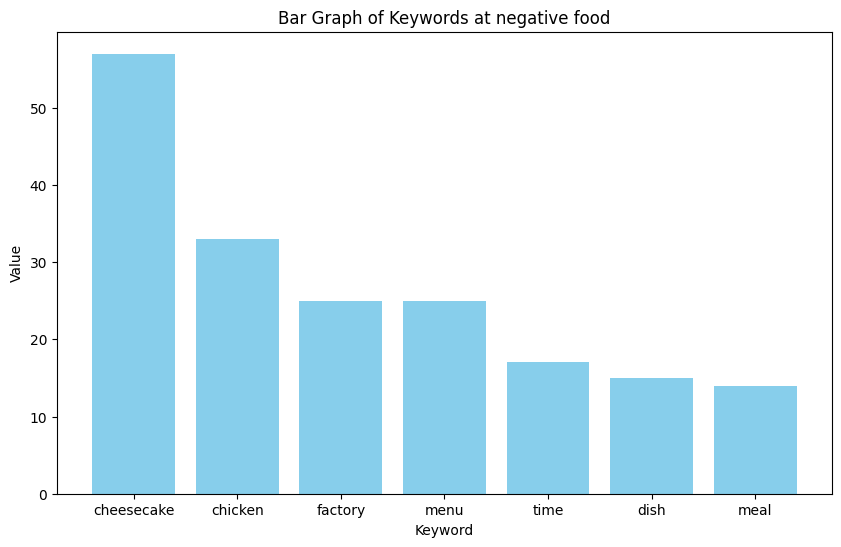

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Positive at hygiene
      Keyword  Value
0       place      2
1       drink      2
2     outdoor      1
3    location      1
4     parking      1
5  proportion      1
6        food      1


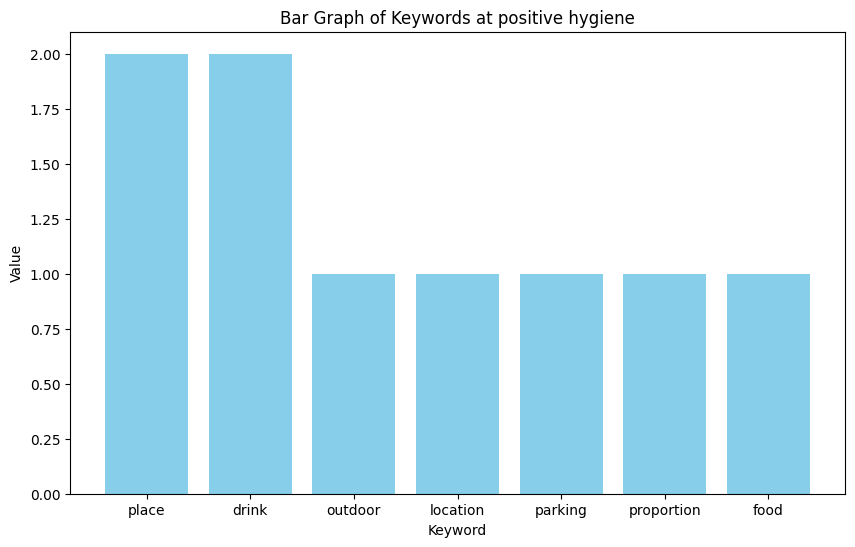

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Negative at hygiene
       Keyword  Value
3   silverware      2
6         food      2
0         dish      1
10     service      1
15       stuff      1
14         lot      1
13       dente      1


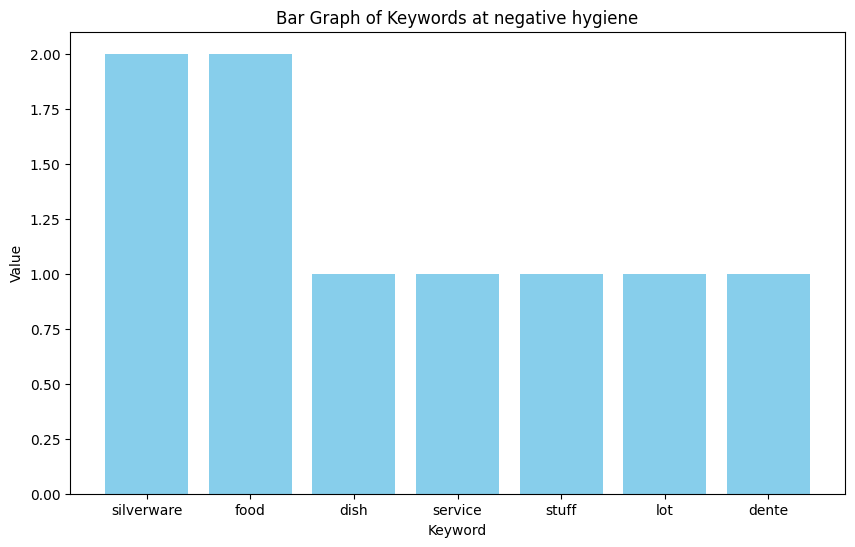

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Positive at location
       Keyword  Value
4         mall      3
1      parking      2
3  bridgewater      2
5      factory      2
8   cheesecake      2
0        space      1
2      problem      1


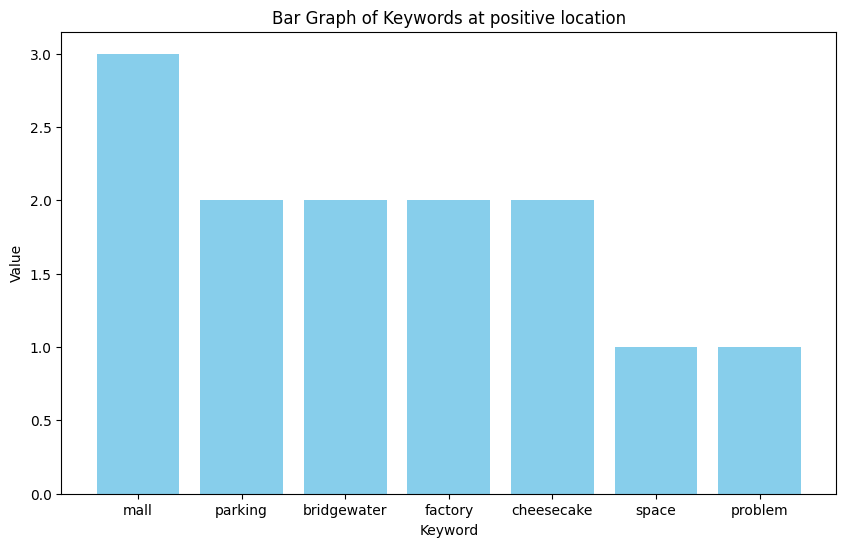

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Negative at location
        Keyword  Value
1          mall      6
0          time      5
14  bridgewater      4
7       factory      4
6    cheesecake      3
20          new      2
24      central      1


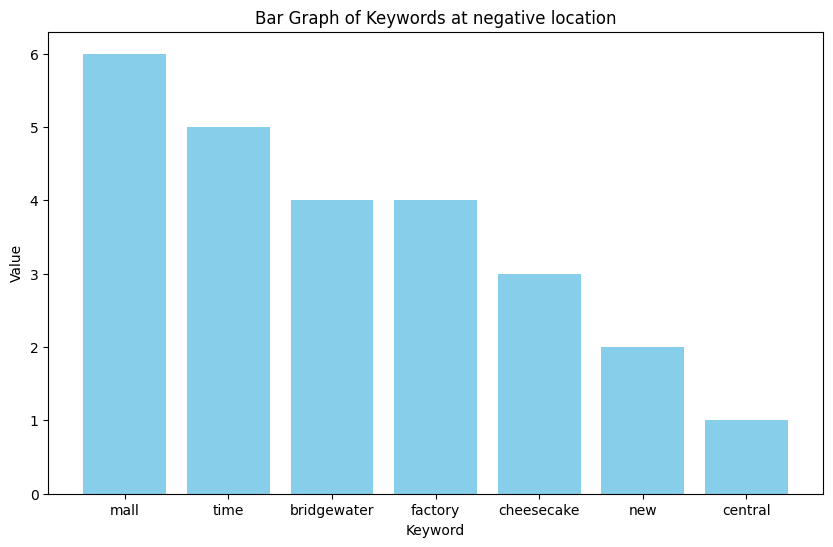

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Positive at service
       Keyword  Value
1       server     31
33        food     25
0     waitress     22
10      waiter     19
13        time     12
12       order     10
23  cheesecake     10


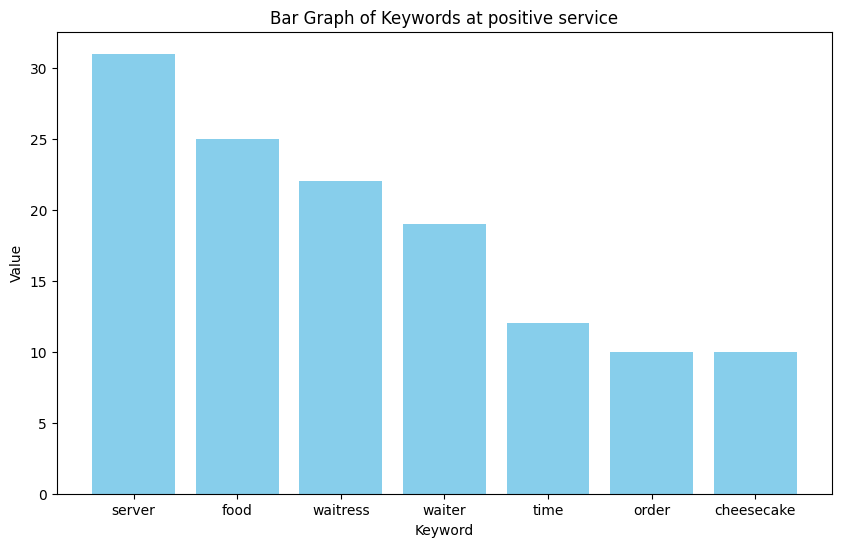

CheeseFactory at 400 Commons Way Suite 270, Bridgewater, NJ 08807
Negative at service
    Keyword  Value
9      time     31
1     order     30
47   minute     24
32     food     24
12  manager     21
2    server     20
24   waiter     18


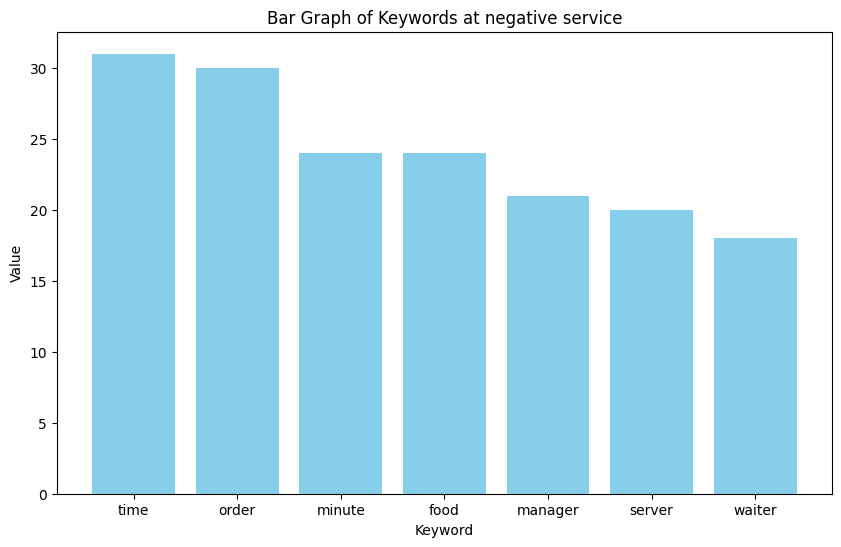

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Positive at atmosphere
    Keyword  Value
2     place     11
0    dinner      5
20   family      5
12   friend      4
4     table      4
34     time      3
29  service      3


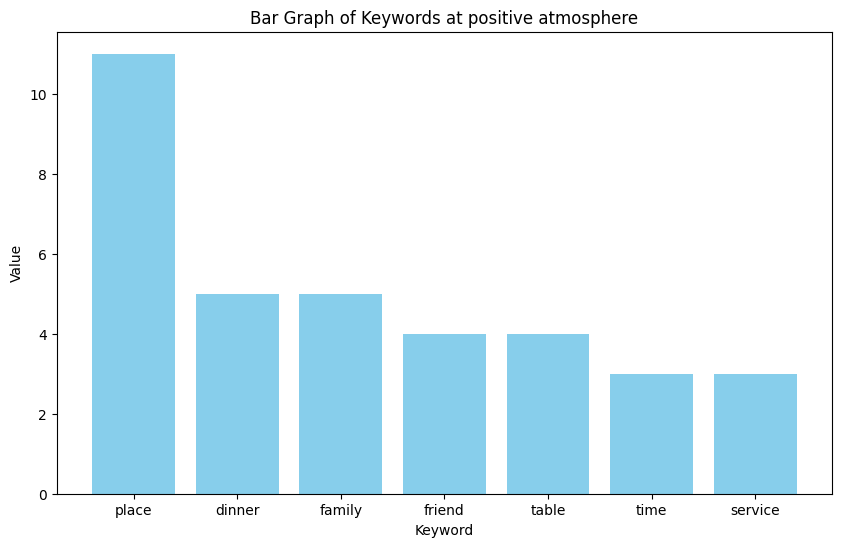

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Negative at atmosphere
       Keyword  Value
6        table      5
4       family      4
7          bar      3
12  experience      2
2   restaurant      2
5          lot      2
18       night      2


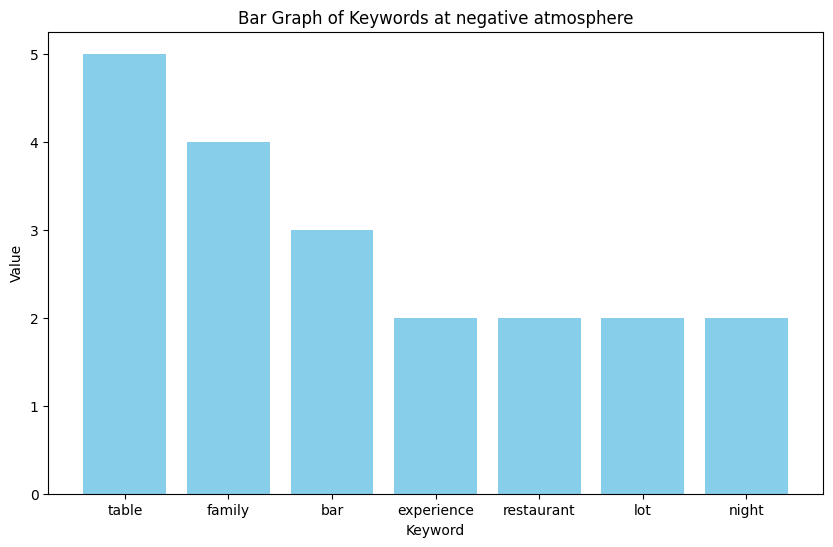

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Positive at food
       Keyword  Value
11  cheesecake     87
23     service     41
13     factory     31
39       drink     27
62        menu     21
19     chicken     21
33       place     19


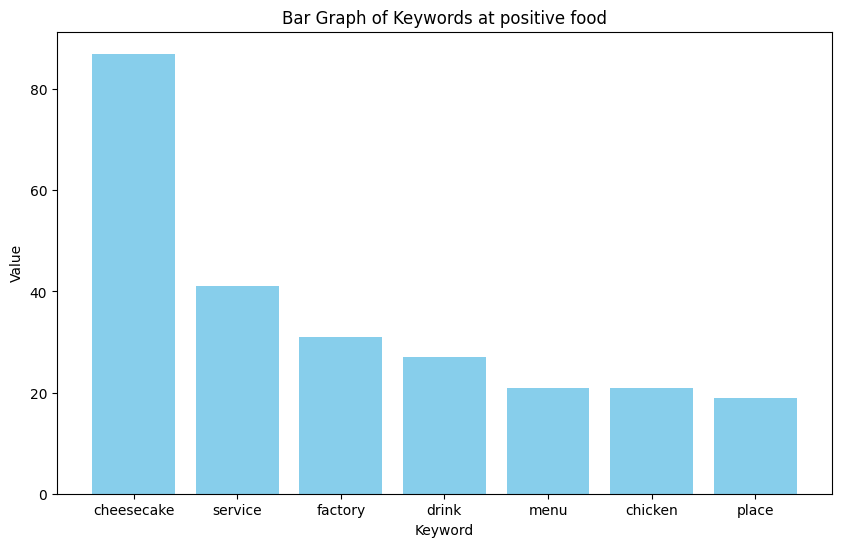

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Negative at food
       Keyword  Value
9   cheesecake     75
14     chicken     46
3      factory     35
23        time     22
27       pasta     22
56        menu     19
21      burger     19


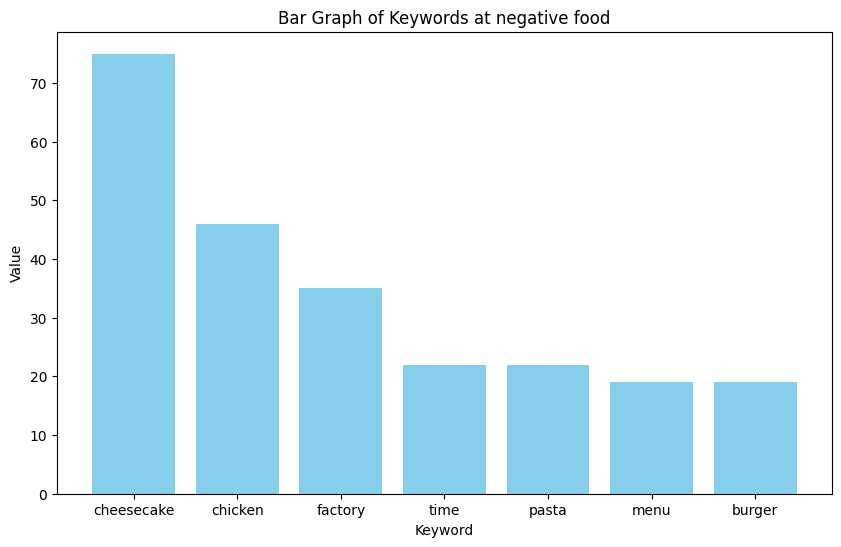

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Positive at hygiene
    Keyword  Value
5     place      2
0    casino      1
1    server      1
2     table      1
3      lead      1
4    waiter      1
6  interior      1


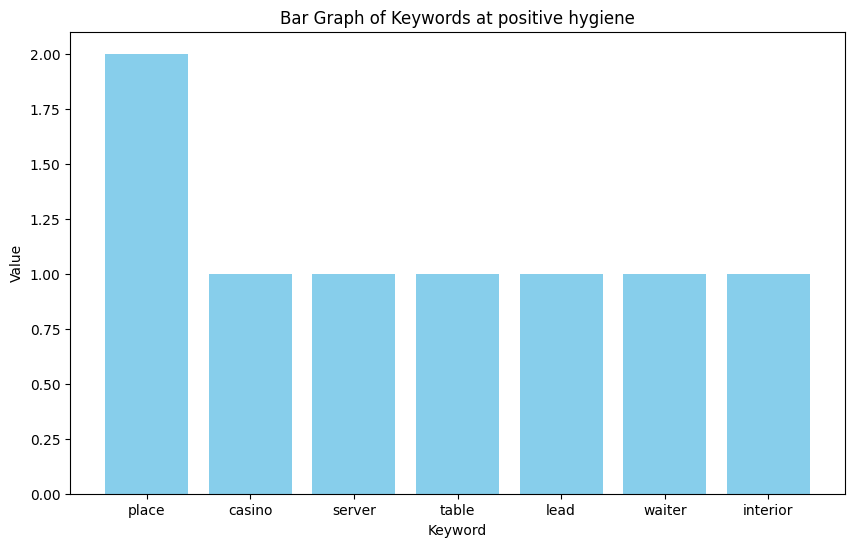

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Negative at hygiene
      Keyword  Value
1       table      4
0     minimum      1
2  silverware      1
3     martini      1
4       place      1
5      toilet      1
6    bathroom      1


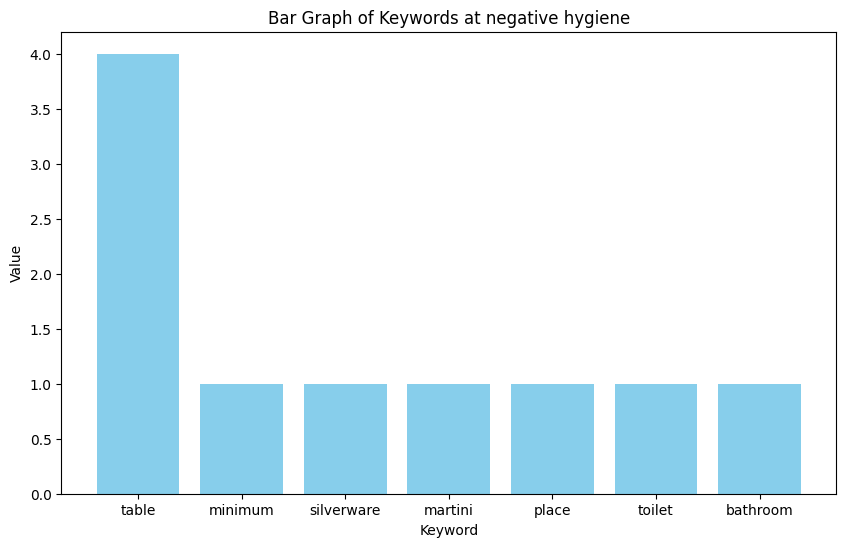

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Positive at location
         Keyword  Value
6        factory      5
10    cheesecake      5
2           mall      4
8   quakerbridge      3
18          hill      2
17        cherry      2
0        opinion      1


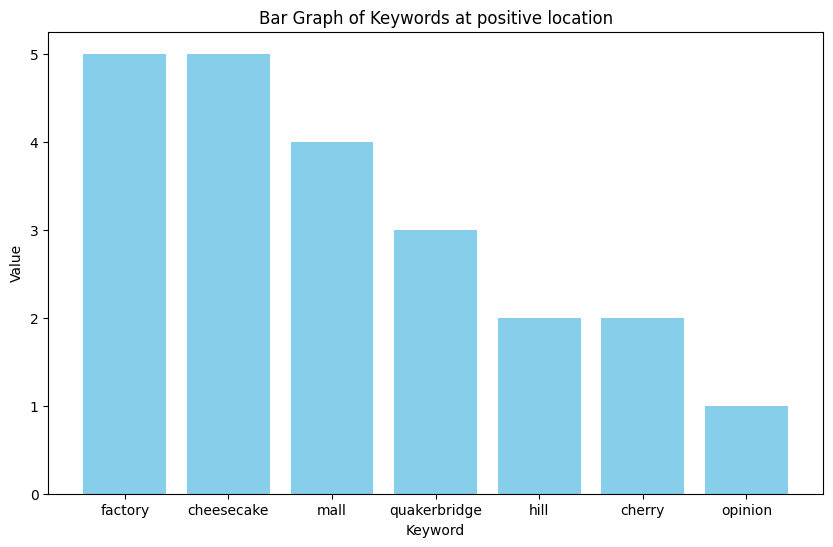

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Negative at location
         Keyword  Value
1           mall      9
5           time      6
3     cheesecake      5
4        factory      5
12            nj      3
2   quakerbridge      3
0         dinner      2


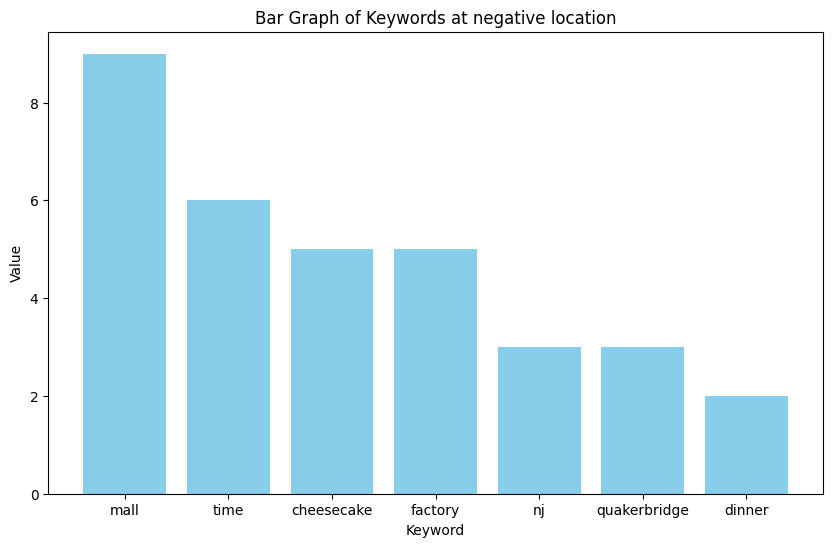

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Positive at service
     Keyword  Value
14    server     29
49     staff     24
2     waiter     19
36      food     16
22      time     15
1   waitress     13
33    minute     13


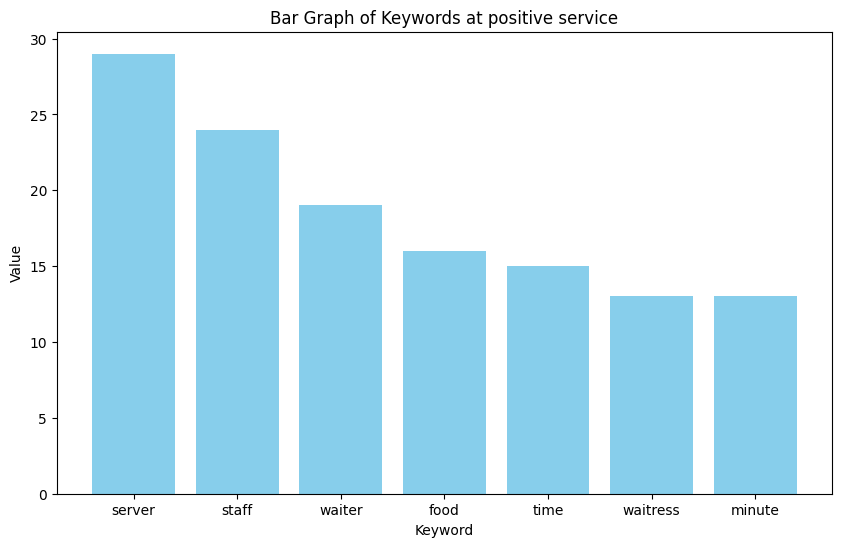

CheeseFactory at 3320 US-1 Unit 161, Lawrenceville, NJ 08648
Negative at service
     Keyword  Value
0     minute     45
28     order     40
5       food     38
1      table     36
35    server     34
8       time     30
36  waitress     23


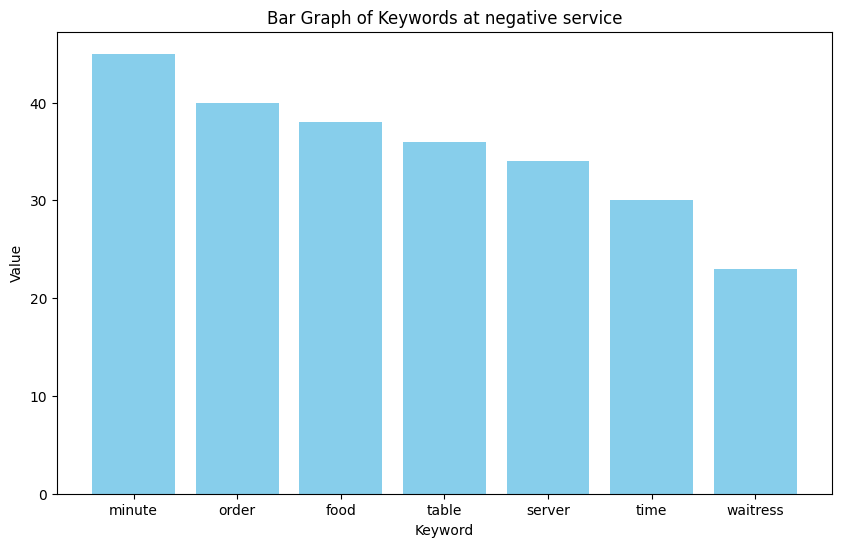

CheeseFactory at 
Positive at atmosphere
       Keyword  Value
1        place     24
12      family      7
7   experience      5
4     birthday      4
16   bartender      3
21        meal      3
41         day      2


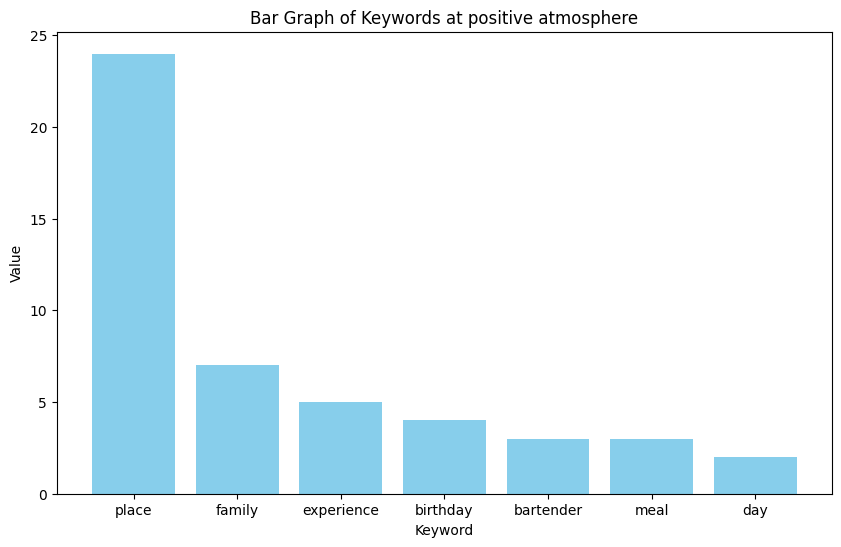

CheeseFactory at 
Negative at atmosphere
       Keyword  Value
0     birthday      4
6   restaurant      4
3       family      3
30         bar      2
15       table      2
18      dinner      2
23      dining      2


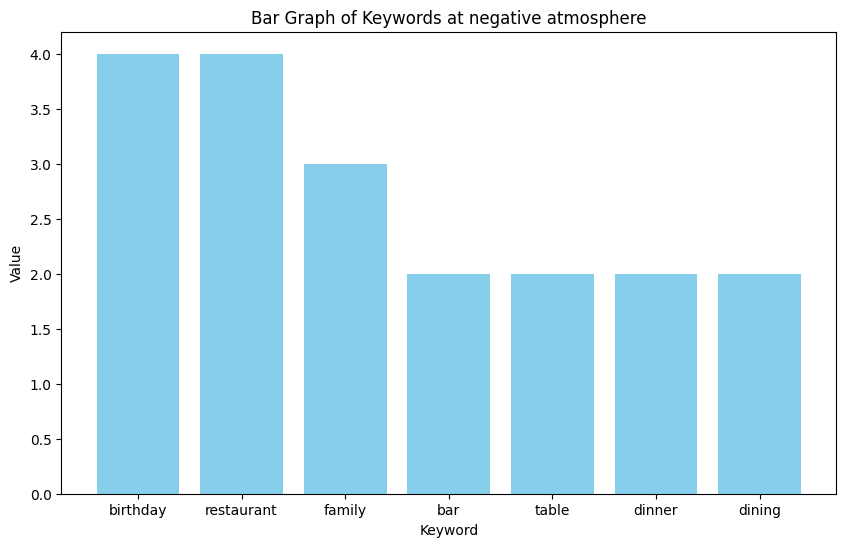

CheeseFactory at 
Positive at food
        Keyword  Value
34   cheesecake     97
76      service     42
33      factory     33
21         meal     28
1       chicken     27
110        menu     25
17       cheese     21


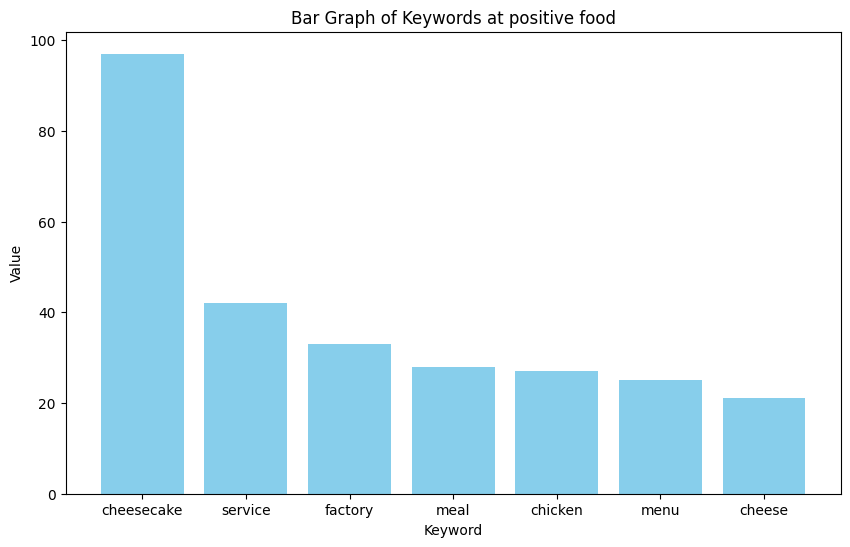

CheeseFactory at 
Negative at food
       Keyword  Value
29  cheesecake     71
13     chicken     39
33        menu     33
37     factory     33
75        meal     23
66      cheese     23
1        pasta     22


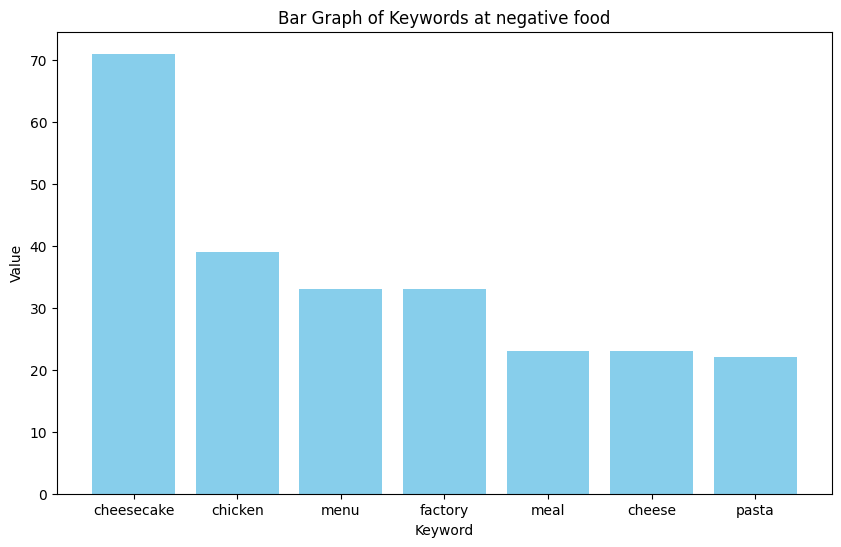

CheeseFactory at 
Positive at hygiene
          Keyword  Value
1           place      2
16     restaurant      2
0   establishment      1
20          decor      1
19          party      1
18         minute      1
17     appearance      1


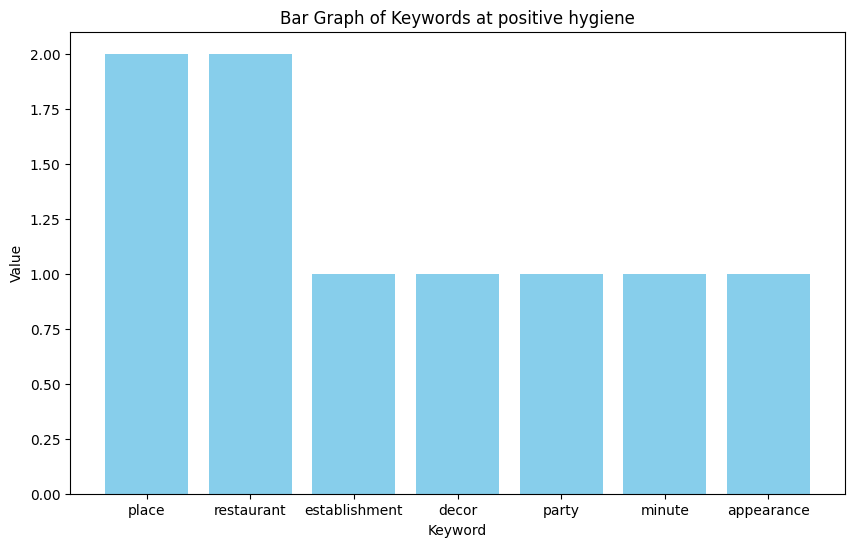

CheeseFactory at 
Negative at hygiene
      Keyword  Value
9       table      4
6  silverware      3
0       chair      2
3        fork      2
1       spoon      1
2       knife      1
4       dirty      1


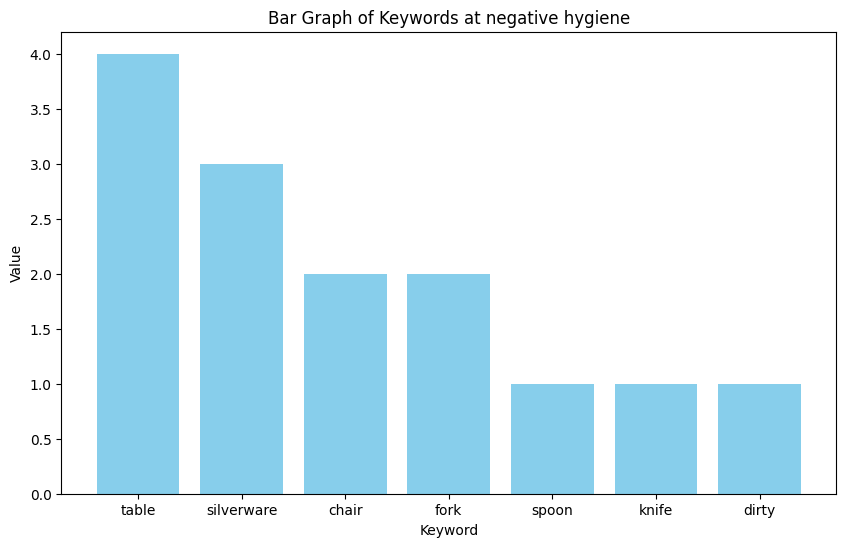

CheeseFactory at 
Positive at location
      Keyword  Value
0    customer      1
1      profit      1
2      cgerry      1
3     factory      1
4        hill      1
5  cheesecake      1
6       level      1


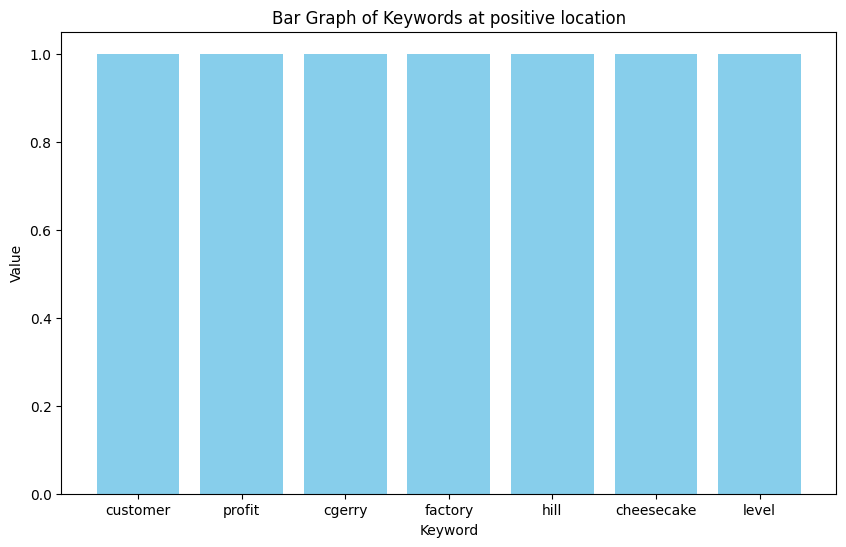

CheeseFactory at 
Negative at location
       Keyword  Value
0       cherry      6
1         hill      6
13     factory      3
7       dinner      2
14  experience      2
27       today      2
3        lunch      2


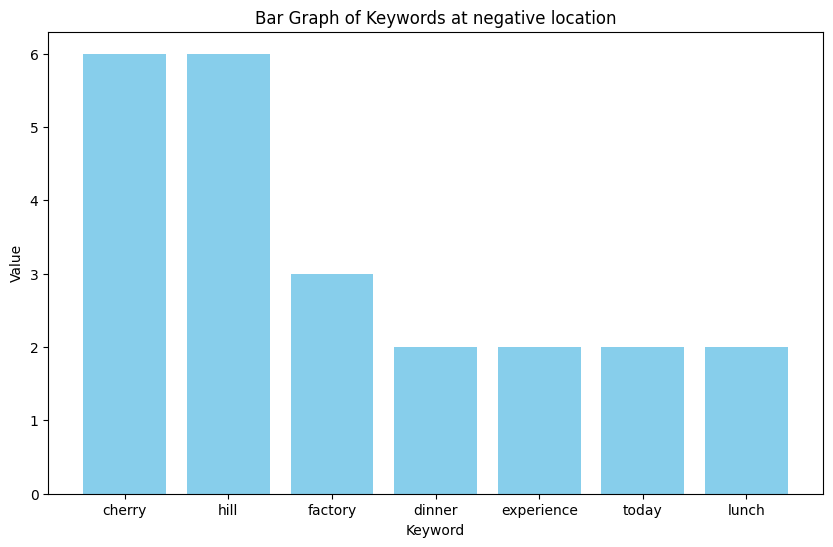

CheeseFactory at 
Positive at service
     Keyword  Value
4     server     49
7   waitress     37
5      staff     23
30      food     23
34     table     23
68      wait     18
56     order     13


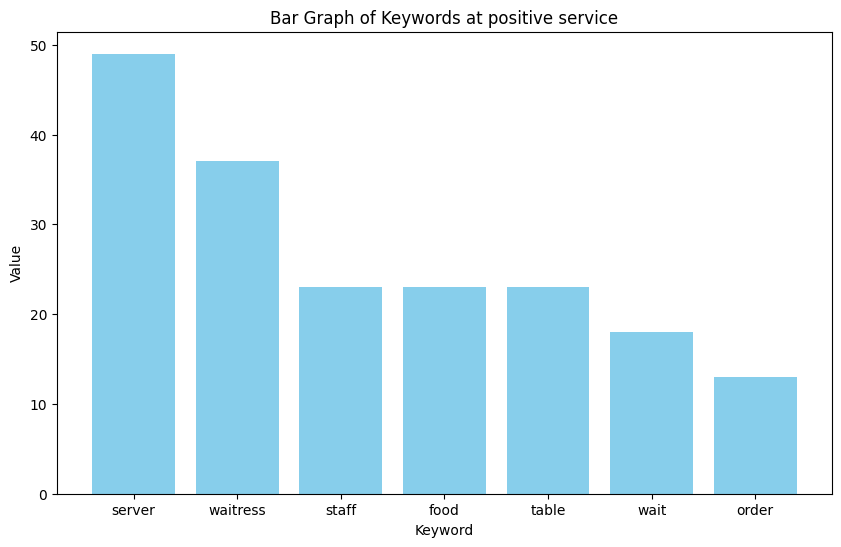

CheeseFactory at 
Negative at service
     Keyword  Value
6      table     34
31      hour     28
11    minute     26
19      food     26
32  waitress     23
14     order     21
9     server     20


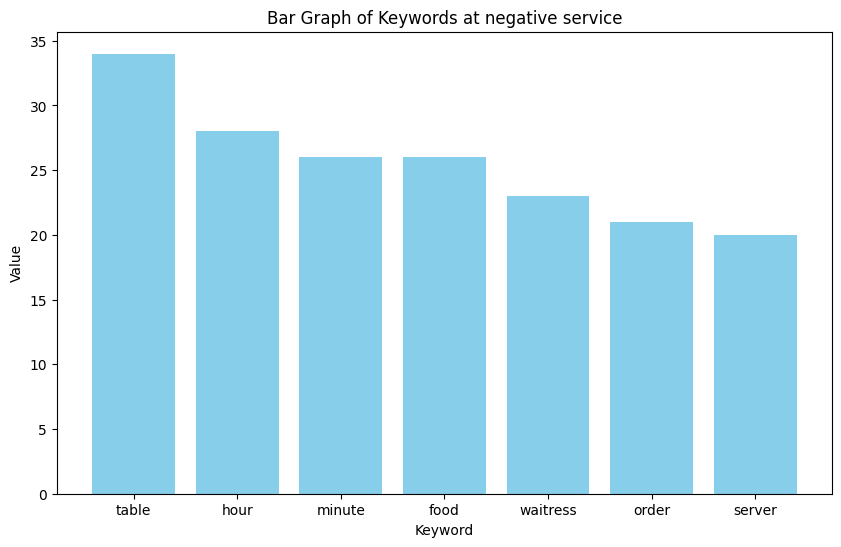

In [29]:
import pandas as pd
categories = ['atmosphere', 'food', 'hygiene', 'location', 'service']
for d in alldata:
    intersectionP=set(d["overall"][categories[0]]["Positive"][1].keys())
    intersectionN=set(d["overall"][categories[0]]["Negative"][1].keys())
    for label in categories:
        intersectionP.intersection_update(d["overall"][label]["Positive"][1].keys())
        intersectionN.intersection_update(d["overall"][label]["Negative"][1].keys())
    for label in categories:
        newdict={}
        for word in d["overall"][label]["Positive"][1]:
            if word not in intersectionP and word!=label:
                newdict[word]=d["overall"][label]["Positive"][1][word]
        df = pd.DataFrame(list(newdict.items()), columns=['Keyword', 'Value'])

        df_sorted = df.sort_values(by='Value', ascending=False)
        print("CheeseFactory at "+d["address"])
        print("Positive at "+label)
        df_sorted=df_sorted.head(7)
        print(df_sorted)
        plt.figure(figsize=(10, 6))
        plt.bar(df_sorted['Keyword'], df_sorted['Value'], color='skyblue')
        plt.xlabel('Keyword')
        plt.ylabel('Value')
        plt.title('Bar Graph of Keywords at positive '+label)
        plt.show()

        newdict={}
        for word in d["overall"][label]["Negative"][1]:
            if word not in intersectionP and word!=label:
                newdict[word]=d["overall"][label]["Negative"][1][word]
        df = pd.DataFrame(list(newdict.items()), columns=['Keyword', 'Value'])

        df_sorted = df.sort_values(by='Value', ascending=False)
        print("CheeseFactory at "+d["address"])
        print("Negative at "+label)
        df_sorted=df_sorted.head(7)
        print(df_sorted)
        plt.figure(figsize=(10, 6))
        plt.bar(df_sorted['Keyword'], df_sorted['Value'], color='skyblue')
        plt.xlabel('Keyword')
        plt.ylabel('Value')
        plt.title('Bar Graph of Keywords at negative '+label)
        plt.show()